# Say2Forest by Jargoñ - Niokolokoba Forest Monitoring  
&copy; Jargoñ 2023



In this report, we analyze the forest cover in the Niokolokoba region. Through various geospatial data techniques, we're able to predict forest cover, calculate carbon emissions from deforestation, and estimate the carbon stock in the region. We use machine learning models and satellite imagery to make our predictions.



## Methodology
The methodology involves several steps:
1. **Data Collection**: Satellite imagery is collected for the Niokolokoba region.
2. **Forest Prediction**: Machine learning models are used to predict forest cover for subsequent years.
3. **Carbon Calculations**: Using the predicted forest cover, we calculate potential carbon emissions and carbon stock.
4. **Visualization**: The data is visualized on a map, providing an interactive tool to monitor forests.


## Objectif
Analyser la dynamique de la forêt de Niokolokoba en termes de déforestation, reforestation, émissions de carbone et stock de carbone à l'aide d'images satellites et de prédictions par apprentissage automatique.

---

## 1. Collecte de Données
- Images satellites de la forêt de Niokolokoba de 2013 à 2020.
- Prédictions de couverture forestière stockées en fichiers '.tif' pour chaque année.

---

## 2. Analyse Préliminaire
- Visualisation des images avec `rasterio` et `matplotlib`.

---

## 3. Calcul des Émissions de Carbone
- Identification des zones déforestées chaque année.
- Émissions calculées en utilisant la densité moyenne du carbone.

---

## 4. Calcul du Stock de Carbone
- Estimation du carbone stocké dans la couverture forestière existante.

---

## 5. Visualisation sur Carte
- Carte interactive créée avec `Folium` montrant les prédictions et les calculs.

---

## 6. Analyse de la Déforestation et Reforestation
- Zones de déforestation et de reforestation identifiées et visualisées.

---

## 7. Interface Utilisateur
- Commandes de couche, légendes, info-bulles et popups ajoutés pour l'interactivité.

---

## 8. Défis et Solutions
- Alignement des images et représentation correcte du stock de carbone parmi les défis relevés.

---

## 9. Conclusion
Des informations précieuses sur la santé de la forêt de Niokolokoba ont été obtenues, avec une carte interactive pour les parties prenantes.

---

Ce rapport résume le travail effectué. Des ajustements peuvent être apportés selon les besoins ou analyses supplémentaires.

## Calcul et visualisation de l'NDVI

Nous déterminons d'abord la santé de la végétation à l'aide de l'NDVI (Indice de Végétation par Différence Normalisée). Cet indice utilise l'imagerie satellite, en particulier les bandes NIR (proche infrarouge) et Rouge, pour fournir une mesure de la santé de la végétation.

En calculant l'NDVI, nous obtenons une représentation visuelle où la végétation saine apparaît en vert et les zones avec peu ou pas de végétation apparaissent en nuances de rouge.

Une fois l'NDVI obtenu, nous segmentons davantage l'imagerie en zones végétales (montrées en blanc) et non végétales (montrées en noir) pour identifier clairement les régions de végétation.

---

In [ ]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt

def compute_ndvi(nir_path, red_path):
    with rasterio.open(nir_path) as nir_src:
        nir_data = nir_src.read(1)
    with rasterio.open(red_path) as red_src:
        red_data = red_src.read(1)
    
    # NDVI calculation
    ndvi = (nir_data - red_data) / (nir_data + red_data + 1e-8)
    return ndvi

def threshold_segmentation(ndvi_data, threshold=0.2):
    # Binary segmentation based on NDVI threshold
    # Vegetation areas will be marked as 1 and non-vegetation as 0
    return (ndvi_data > threshold).astype(np.uint8)

# Directory containing your files
dir_path = "."

# Retrieve B3 and B4 files
b3_files = sorted([os.path.join(dir_path, f) for f in os.listdir(dir_path) if 'B3' in f])
b4_files = sorted([os.path.join(dir_path, f) for f in os.listdir(dir_path) if 'B4' in f])

for b3_path, b4_path in zip(b3_files, b4_files):
    ndvi_data = compute_ndvi(b4_path, b3_path)  # B4 is NIR and B3 is Red
    
    # Display NDVI
    plt.imshow(ndvi_data, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar(label='NDVI')
    plt.title(f"NDVI for {os.path.basename(b4_path)}")
    plt.axis('off')
    plt.show()
    
    segmented_data = threshold_segmentation(ndvi_data)
    
    # Display Segmentation
    plt.imshow(segmented_data, cmap='gray')
    plt.colorbar(label='Segmentation')
    plt.title(f"Segmentation for {os.path.basename(b4_path)}")
    plt.axis('off')
    plt.show()


## Fusion des images raster

Pour obtenir une vue complète d'une zone, il est parfois nécessaire de fusionner ou d'assembler plusieurs images satellites. Ici, nous combinons deux images de l'année 2013 pour démontrer ce processus.

L'affichage côte à côte montre les deux images originales et l'image fusionnée résultante.

---

In [ ]:
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import os
import matplotlib.pyplot as plt

# Define paths
dir_path = "."
b3_files = sorted([os.path.join(dir_path, f) for f in os.listdir(dir_path) if 'B3' in f])

# Get the B3 files for 2013 (or any other year you want to test)
b3_files_year = [file for file in b3_files if "2013" in file]

# Check if there are at least two files
if len(b3_files_year) < 2:
    raise ValueError("There are not enough B3 files for the year 2013 to merge.")

# Open the two raster images
src1 = rasterio.open(b3_files_year[0])
src2 = rasterio.open(b3_files_year[1])

# Merge them directly using the rasterio.merge.merge() function
merged_data, merged_transform = merge([src1, src2])

# Display the result
fig, axs = plt.subplots(1, 3, figsize=(20, 20))

show(src1, ax=axs[0], cmap='gray', title="Image 1")
show(src2, ax=axs[1], cmap='gray', title="Image 2")
show(merged_data, ax=axs[2], transform=merged_transform, cmap='gray', title="Merged")

plt.tight_layout()
plt.show()


### Modélisation de la couverture forestière à l'aide de l'apprentissage profond

#### 1. **Prétraitement des données**:
- Nous définissons les chemins vers les fichiers mosaïques qui contiennent les images satellite.
- Les 6 premières années de données sont utilisées pour l'entraînement et les 2 dernières pour l'évaluation.

#### 2. **Étiquetage des données (Data Labeling)**:
- À partir des images NDVI (Normalized Difference Vegetation Index), nous étiquetons les zones comme forêt ou non-forêt.
- Les régions avec une valeur NDVI élevée sont considérées comme étant des forêts, tandis que celles avec une valeur NDVI faible sont considérées comme non-forêts.

#### 3. **Extraction des patches**:
- Nous extrayons des patches ou segments de l'image.
- Les patches avec une valeur NDVI élevée sont classés comme forêt, tandis que ceux avec une faible valeur NDVI sont classés comme non-forêt.
- Ces patches servent de données d'entraînement pour notre modèle.

#### 4. **Augmentation des données**:
- Pour augmenter la quantité de données d'entraînement et rendre le modèle plus robuste, nous utilisons des techniques d'augmentation de données, telles que la rotation et le retournement des images.

#### 5. **Définition du modèle**:
Nous utilisons un modèle de réseau neuronal convolutionnel (CNN) avec l'architecture suivante :
\```
_________________________________________________________________
Layer (type)                 Output Shape              Param #
=================================================================
Conv2D (Conv2D)              (None, 48, 48, 32)        320
_________________________________________________________________
MaxPooling2D (MaxPooling2D)  (None, 24, 24, 32)        0
_________________________________________________________________
Conv2D (Conv2D)              (None, 22, 22, 64)        18496
_________________________________________________________________
MaxPooling2D (MaxPooling2D)  (None, 11, 11, 64)        0
_________________________________________________________________
Flatten (Flatten)            (None, 7744)              0
_________________________________________________________________
Dense (Dense)                (None, 64)                495680
_________________________________________________________________
Dense (Dense)                (None, 1)                 65
=================================================================
\```

#### 6. **Entraînement du modèle**:
- Nous compilons le modèle en utilisant l'optimiseur 'adam' et la fonction de perte 'binary_crossentropy'.
- Le modèle est entraîné sur les données d'entraînement pendant 10 époques.
- Nous validons également le modèle en utilisant les données d'évaluation.

#### 7. **Évaluation du modèle**:
- Après l'entraînement, nous évaluons les performances du modèle sur les données d'évaluation.
- Nous calculons plusieurs métriques telles que la précision, le rappel, le score F1 et la justesse.

#### 8. **Sauvegarde du modèle**:
- Enfin, nous sauvegardons le modèle entraîné pour une utilisation ultérieure.

---

Notez que la description ci-dessus est une simplification de haut niveau du code pour aider les utilisateurs finaux à comprendre les étapes sans entrer dans les détails techniques.


## Chargement et visualisation de la couverture forestière prévue

Après avoir calculé l'NDVI et fusionné les images, nous utilisons un ensemble d'images de couverture forestière prédites. Ces prédictions nous donnent un aperçu de l'évolution de la couverture forestière au fil des ans.

Pour chaque année prédite, nous visualisons :
- L'NDVI, indiquant la santé de la végétation.
- La bande NIR, un composant de l'image satellite utile pour l'analyse de la végétation.
- La couverture forestière prédite, montrant les zones de forêt en vert.

---

## Prédiction de la couverture forestière à l'aide de notre modèle

Nous utilisons un modèle pré-entraîné pour prédire la couverture forestière des images satellite. Les prédictions sont basées sur les bandes de couleur de l'imagerie satellite ainsi que sur d'autres caractéristiques pertinentes. Le modèle génère une carte binaire où les régions prédites comme étant des forêts sont marquées en blanc, tandis que les autres régions sont en noir.

Une fois ces prédictions générées, nous les combinons avec les données NDVI et d'autres métriques pour obtenir une image complète de la santé et de la couverture de la forêt.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import zipfile

# If you're in Jupyter Notebook, use the following line:
%matplotlib inline

predicted_dir = "./predicted"

# Path to the zipped .npy file
zipped_npy_path = os.path.join(predicted_dir, 'predicted_images.zip')

with zipfile.ZipFile(zipped_npy_path, 'r') as zip_ref:
    # Assuming there's only one .npy file in the zip, extract its name
    npy_file_name = zip_ref.namelist()[0]
    
    # Load the .npy file directly from the zip
    with zip_ref.open(npy_file_name) as file:
        predicted_images = np.load(file)

# The rest of your files appear to be local, so you can continue loading them as you were before:
accuracies = np.load(os.path.join(predicted_dir, 'accuracies.npy'))
precisions = np.load(os.path.join(predicted_dir, 'precisions.npy'))
recalls = np.load(os.path.join(predicted_dir, 'recalls.npy'))
f1_scores = np.load(os.path.join(predicted_dir, 'f1_scores.npy'))

predicted_image_files = sorted([os.path.join(predicted_dir, f) for f in os.listdir(predicted_dir) if f.endswith('.tif')])
years = [os.path.basename(f)[-8:-4] for f in predicted_image_files]

# Plotting the evaluation metrics
plt.figure(figsize=(10, 6))
plt.plot(years, accuracies, '-o', label='Accuracy')
plt.plot(years, precisions, '-o', label='Precision')
plt.plot(years, recalls, '-o', label='Recall')
plt.plot(years, f1_scores, '-o', label='F1 Score')
plt.legend()
plt.title('Evaluation Metrics Over Years')
plt.xlabel('Year')
plt.ylabel('Score')
plt.grid(True)
plt.savefig("./metrics_over_years.png")
plt.show()


## Métriques de conservation des forêts au fil du temps

Les forêts jouent un rôle crucial dans la séquestration du carbone, aidant à atténuer le changement climatique. Nous analysons nos données pour fournir des informations sur :
- L'étendue de la couverture forestière sur différentes années.
- La quantité de carbone stockée dans ces forêts.
- Les émissions de carbone résultant de la déforestation.

Les visualisations offrent un aperçu de la superficie de la couverture forestière, du carbone stocké dans la forêt (stock de carbone) et du carbone libéré en raison de la déforestation (émissions de carbone) au fil des ans.

---

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import zipfile
from flask import Flask, render_template

app = Flask(__name__)

# Directory paths
predicted_dir = "./predicted"
mosaic_dir = "./mosaics"

# Path to the zipped .npy file
zipped_npy_path = os.path.join(predicted_dir, 'predicted_images.zip')

# Define b3_files and b4_files
b3_files = sorted([os.path.join(mosaic_dir, f) for f in os.listdir(mosaic_dir) if 'B3' in f])
b4_files = sorted([os.path.join(mosaic_dir, f) for f in os.listdir(mosaic_dir) if 'B4' in f])

with zipfile.ZipFile(zipped_npy_path, 'r') as zip_ref:
    # Assuming there's only one .npy file in the zip, extract its name
    npy_file_name = zip_ref.namelist()[0]
    
    # Load the .npy file directly from the zip
    with zip_ref.open(npy_file_name) as file:
        predicted_images = np.load(file)

# Function to compute NDVI
def compute_ndvi(nir_band, red_band):
    return (nir_band - red_band) / (nir_band + red_band + 1e-8)

@app.route('/')
def index():
    # Create a list of dictionaries containing the NDVI and predicted forest cover images for each year
    data = []
    for idx, (b3_file, b4_file) in enumerate(zip(b3_files, b4_files)):
        # Load the NIR and RED bands
        with rasterio.open(b4_file) as nir_src:
            nir_band = nir_src.read(1)
        with rasterio.open(b3_file) as red_src:
            red_band = red_src.read(1)
        
        # Compute NDVI
        ndvi_data = compute_ndvi(nir_band, red_band)
        
        # Create a figure with three subplots
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        
        # Plot the NDVI data
        axs[0].imshow(ndvi_data, cmap='RdYlGn', vmin=-1, vmax=1)
        axs[0].set_title(f'NDVI {b3_file[-8:-4]}')
        axs[0].axis('off')

        # Plot the predicted forest cover data
        axs[1].imshow(predicted_images[idx], cmap='Greens', vmin=0, vmax=1)
        axs[1].set_title(f'Predicted Forest Cover {b3_file[-8:-4]}')
        axs[1].axis('off')
        
        # Plot the NIR band data
        axs[2].imshow(nir_band, cmap='gray')
        axs[2].set_title(f'NIR Band {b3_file[-8:-4]}')
        axs[2].axis('off')
        
        # Save the figure to a PNG file
        fig_path = os.path.join(predicted_dir, f'{b3_file[-8:-4]}.png')
        plt.savefig(fig_path)
        
        # Add the figure path to the list of dictionaries
        data.append({'year': b3_file[-8:-4], 'fig_path': fig_path})
        
        # Close the figure to free up memory
        plt.close(fig)
    
    # Render the HTML template with the list of dictionaries
    return render_template('index.html', data=data)

if __name__ == '__main__':
    app.run(debug=True)

## Visualisation de carte interactive

Pour une expérience interactive, nous créons une carte qui permet aux utilisateurs de voir diverses couches, notamment :
- L'imagerie satellite de la zone.
- La couverture forestière prévue pour chaque année.
- Les émissions de carbone dues à la déforestation.
- Le carbone stocké dans la forêt.

Cette carte fournit une vue complète du Parc National du Niokolo-Koba, mettant en évidence les zones de déforestation, de reforestation et la santé globale de la forêt.

---

In [ ]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Function to compute NDVI
def compute_ndvi(red_band, nir_band):
    return (nir_band - red_band) / (nir_band + red_band + 1e-8)

# Load the data
ndvi_images = []
nir_images = []
predicted_images = []
years = []

for b3_file, b4_file, pred_file in zip(b3_files, b4_files, predicted_image_files):
    year = os.path.basename(b3_file)[-8:-4]
    
    with rasterio.open(b3_file) as red_src:
        red_band = red_src.read(1)
        
    with rasterio.open(b4_file) as nir_src:
        nir_band = nir_src.read(1)
    
    with rasterio.open(pred_file) as pred_src:
        pred_img = pred_src.read(1)
        
    ndvi_img = compute_ndvi(red_band, nir_band)
    
    ndvi_images.append(ndvi_img)
    nir_images.append(nir_band)
    predicted_images.append(pred_img)
    years.append(year)

# Animation function
def animate(i):
    ax[0].clear()
    ax[1].clear()
    ax[2].clear()
    
    ax[0].imshow(ndvi_images[i], cmap='RdYlGn', vmin=-1, vmax=1)
    ax[0].set_title(f"NDVI: Year {years[i]}")
    
    ax[1].imshow(predicted_images[i], cmap='Greens', vmin=0, vmax=1)
    ax[1].set_title(f"Predicted Forest Cover: Year {years[i]}")
    
    ax[2].imshow(nir_images[i], cmap='gray')
    ax[2].set_title(f"NIR Band: Year {years[i]}")
    
    for a in ax:
        a.axis('off')

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ani = animation.FuncAnimation(fig, animate, frames=len(years), repeat=True)

# Display the animation
HTML(ani.to_jshtml())



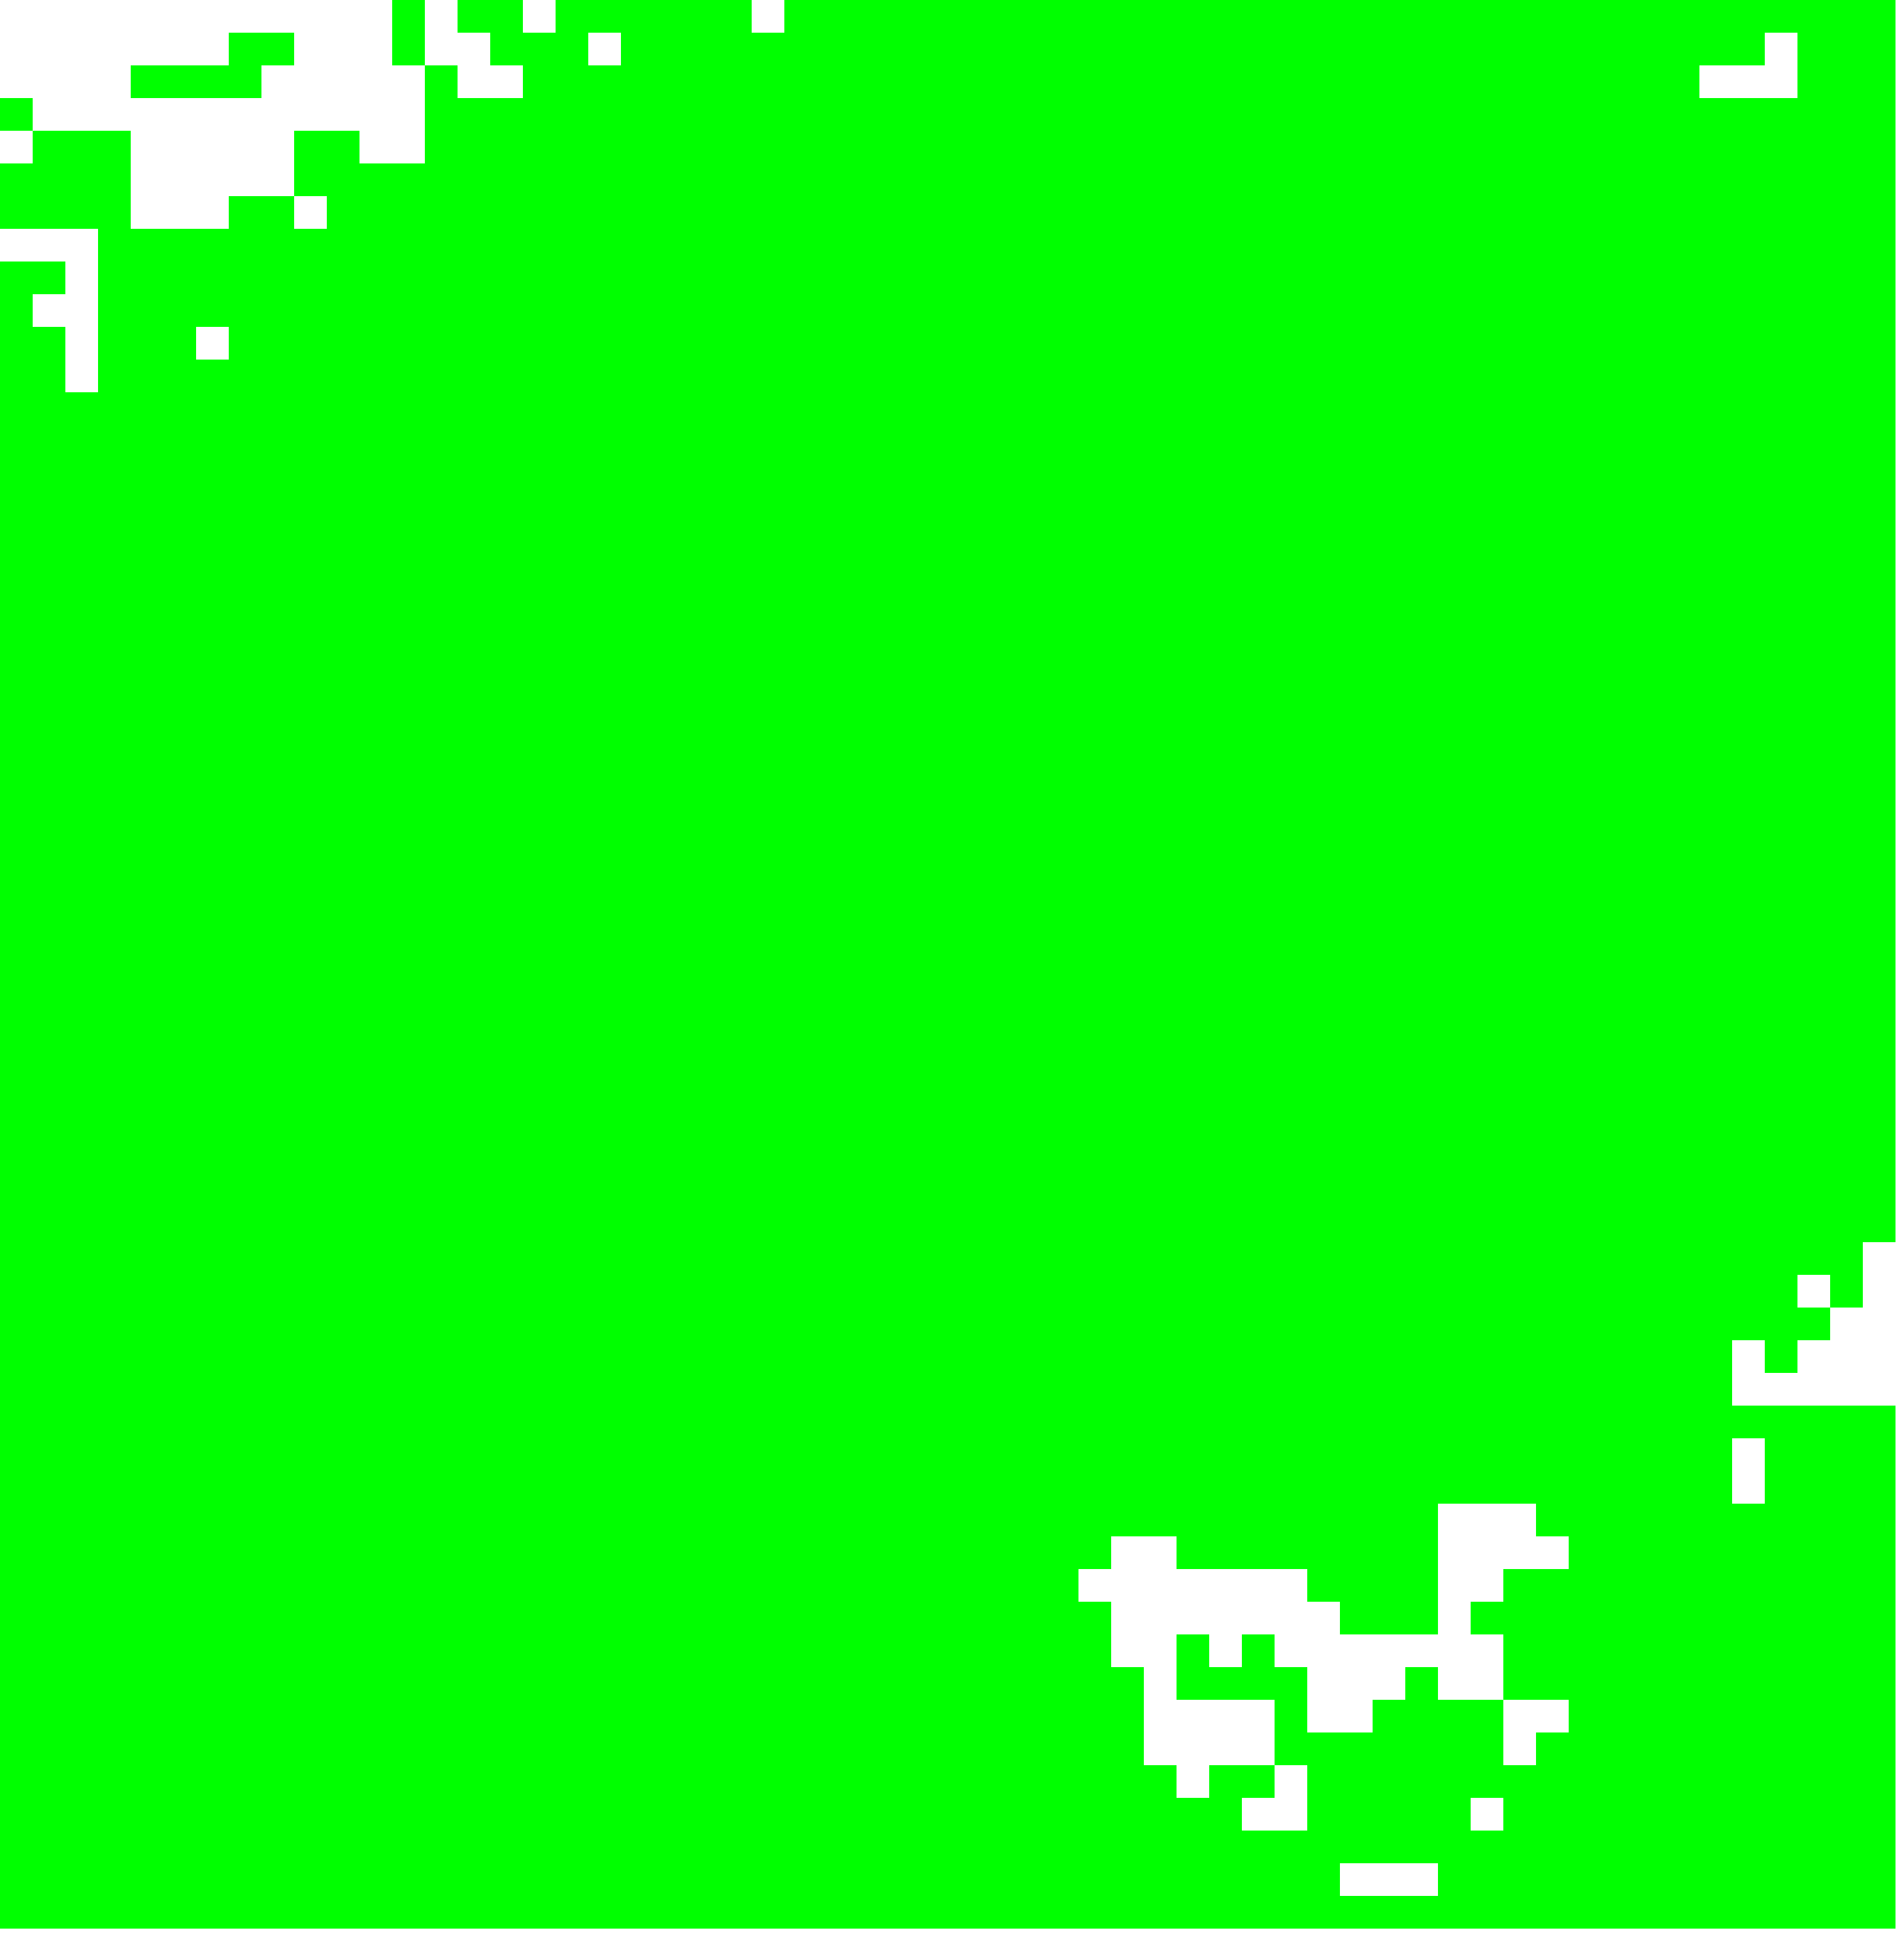
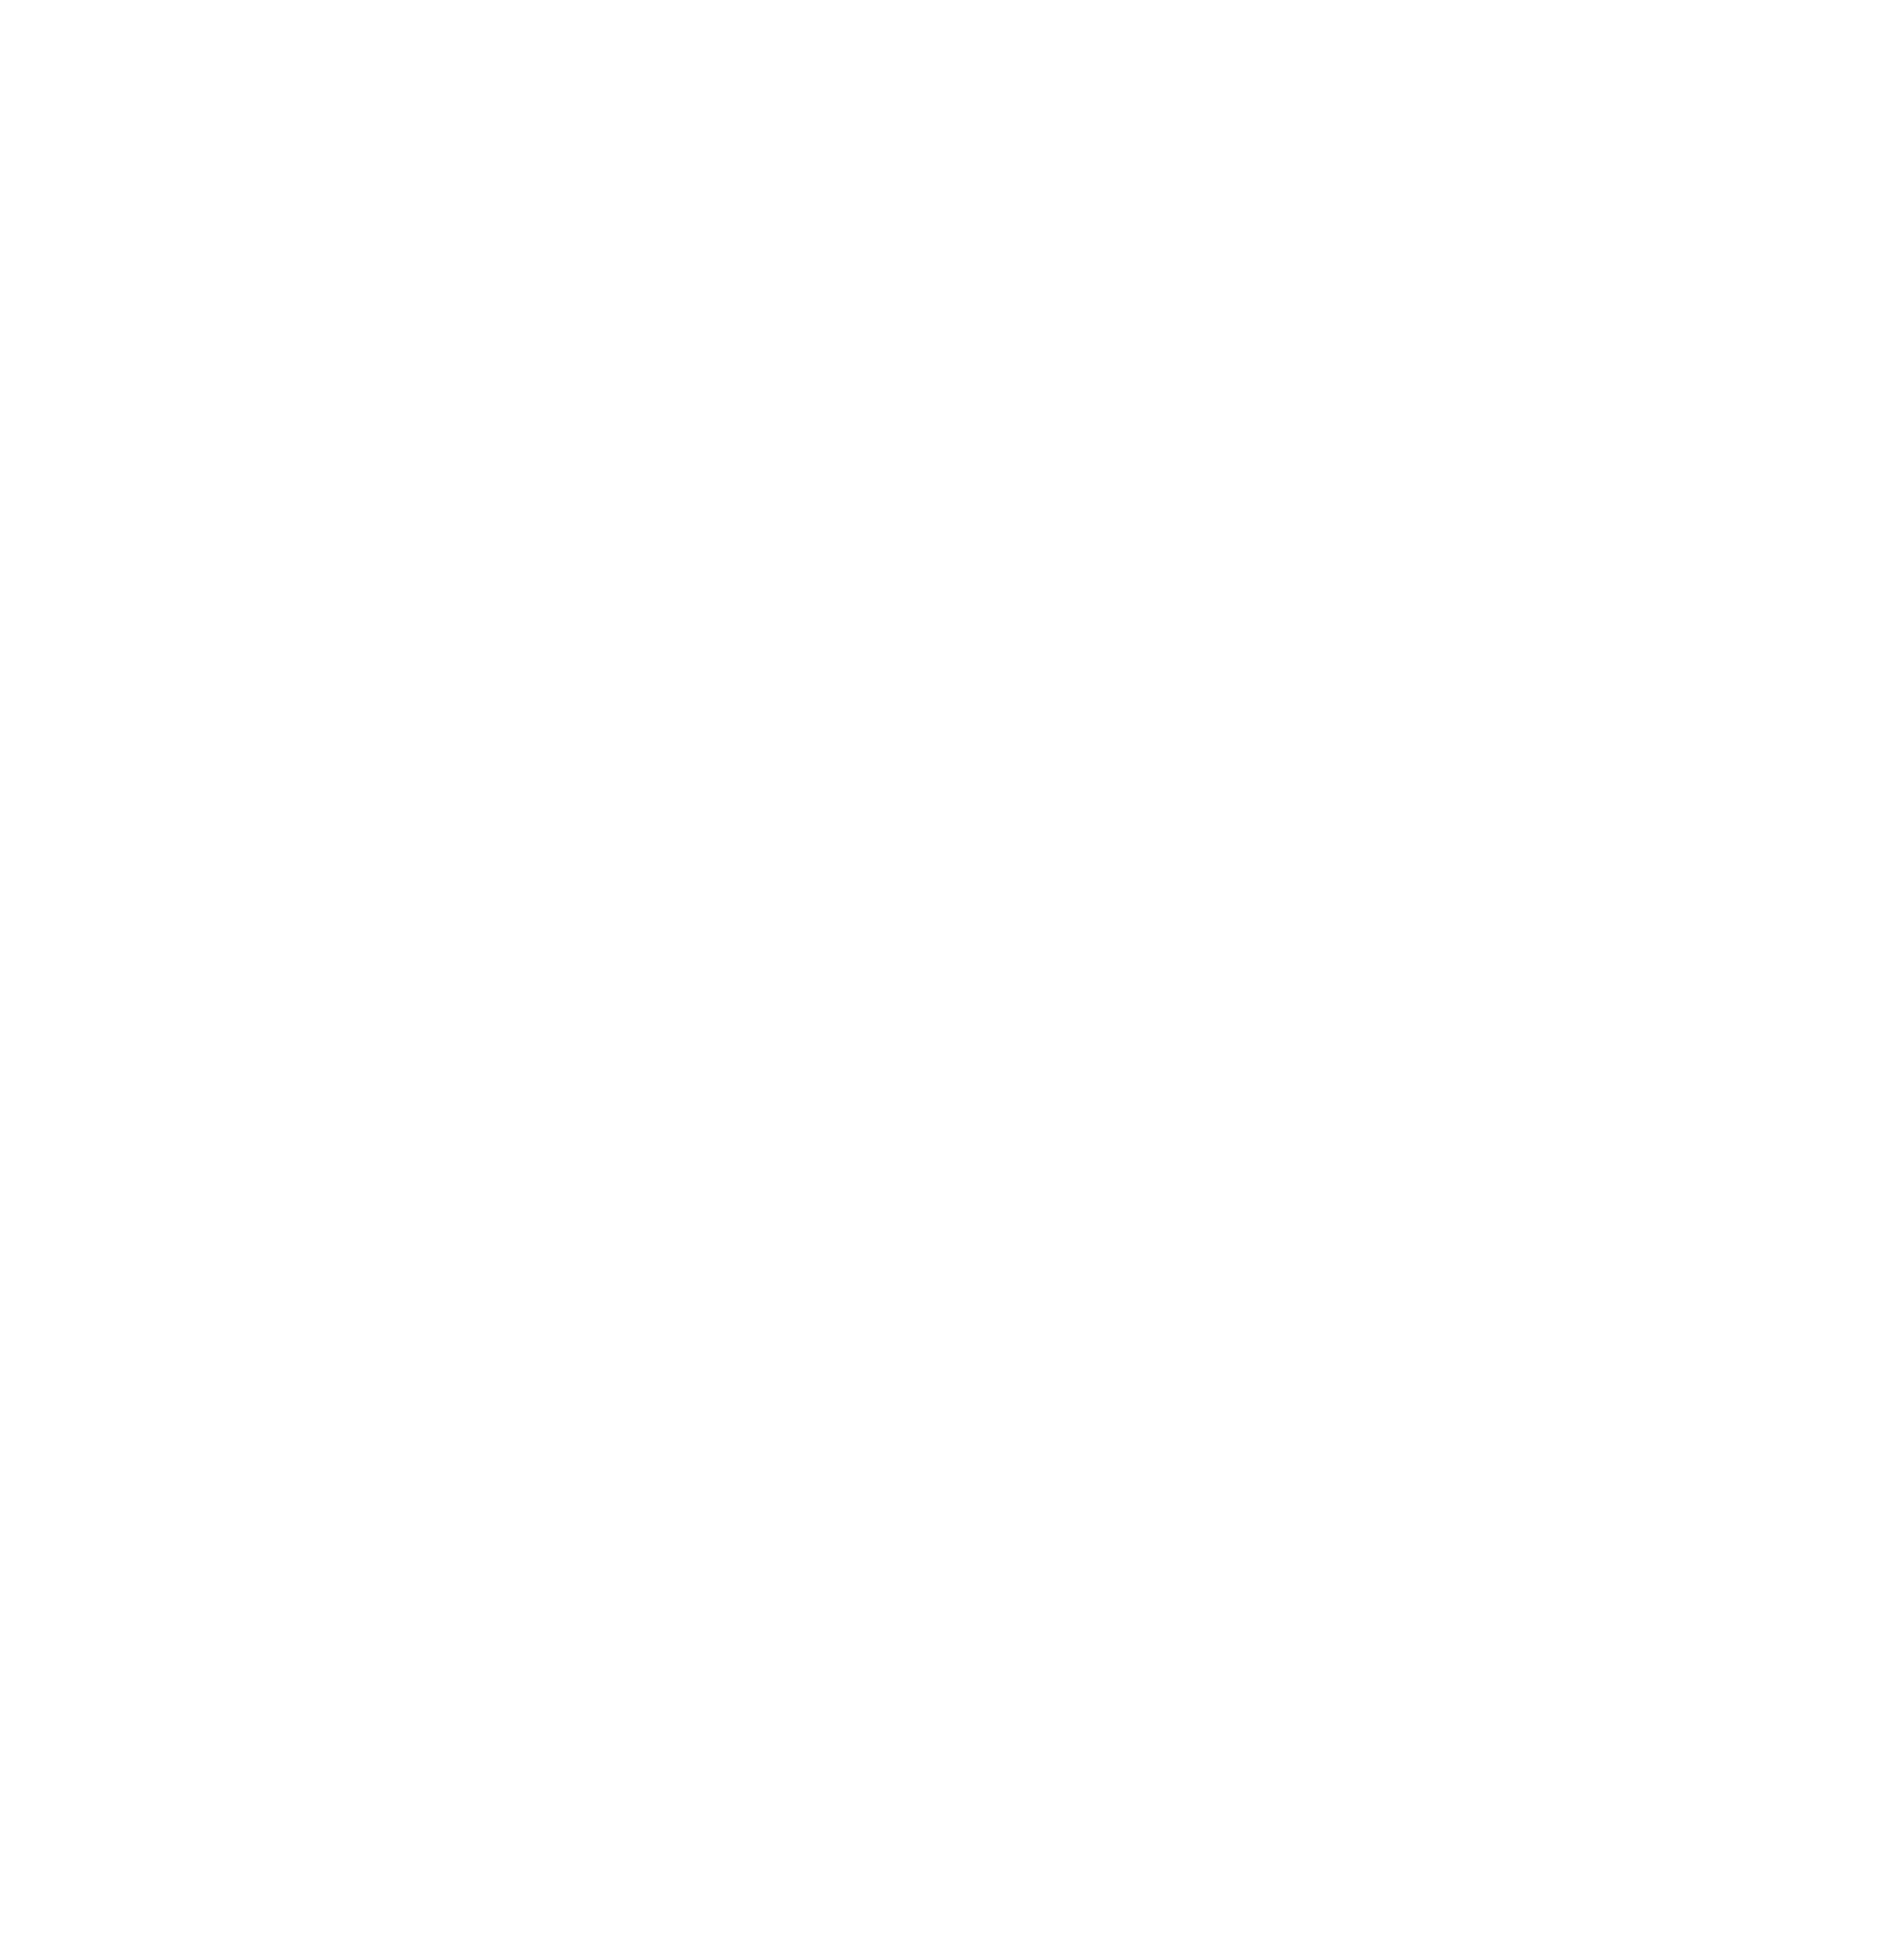
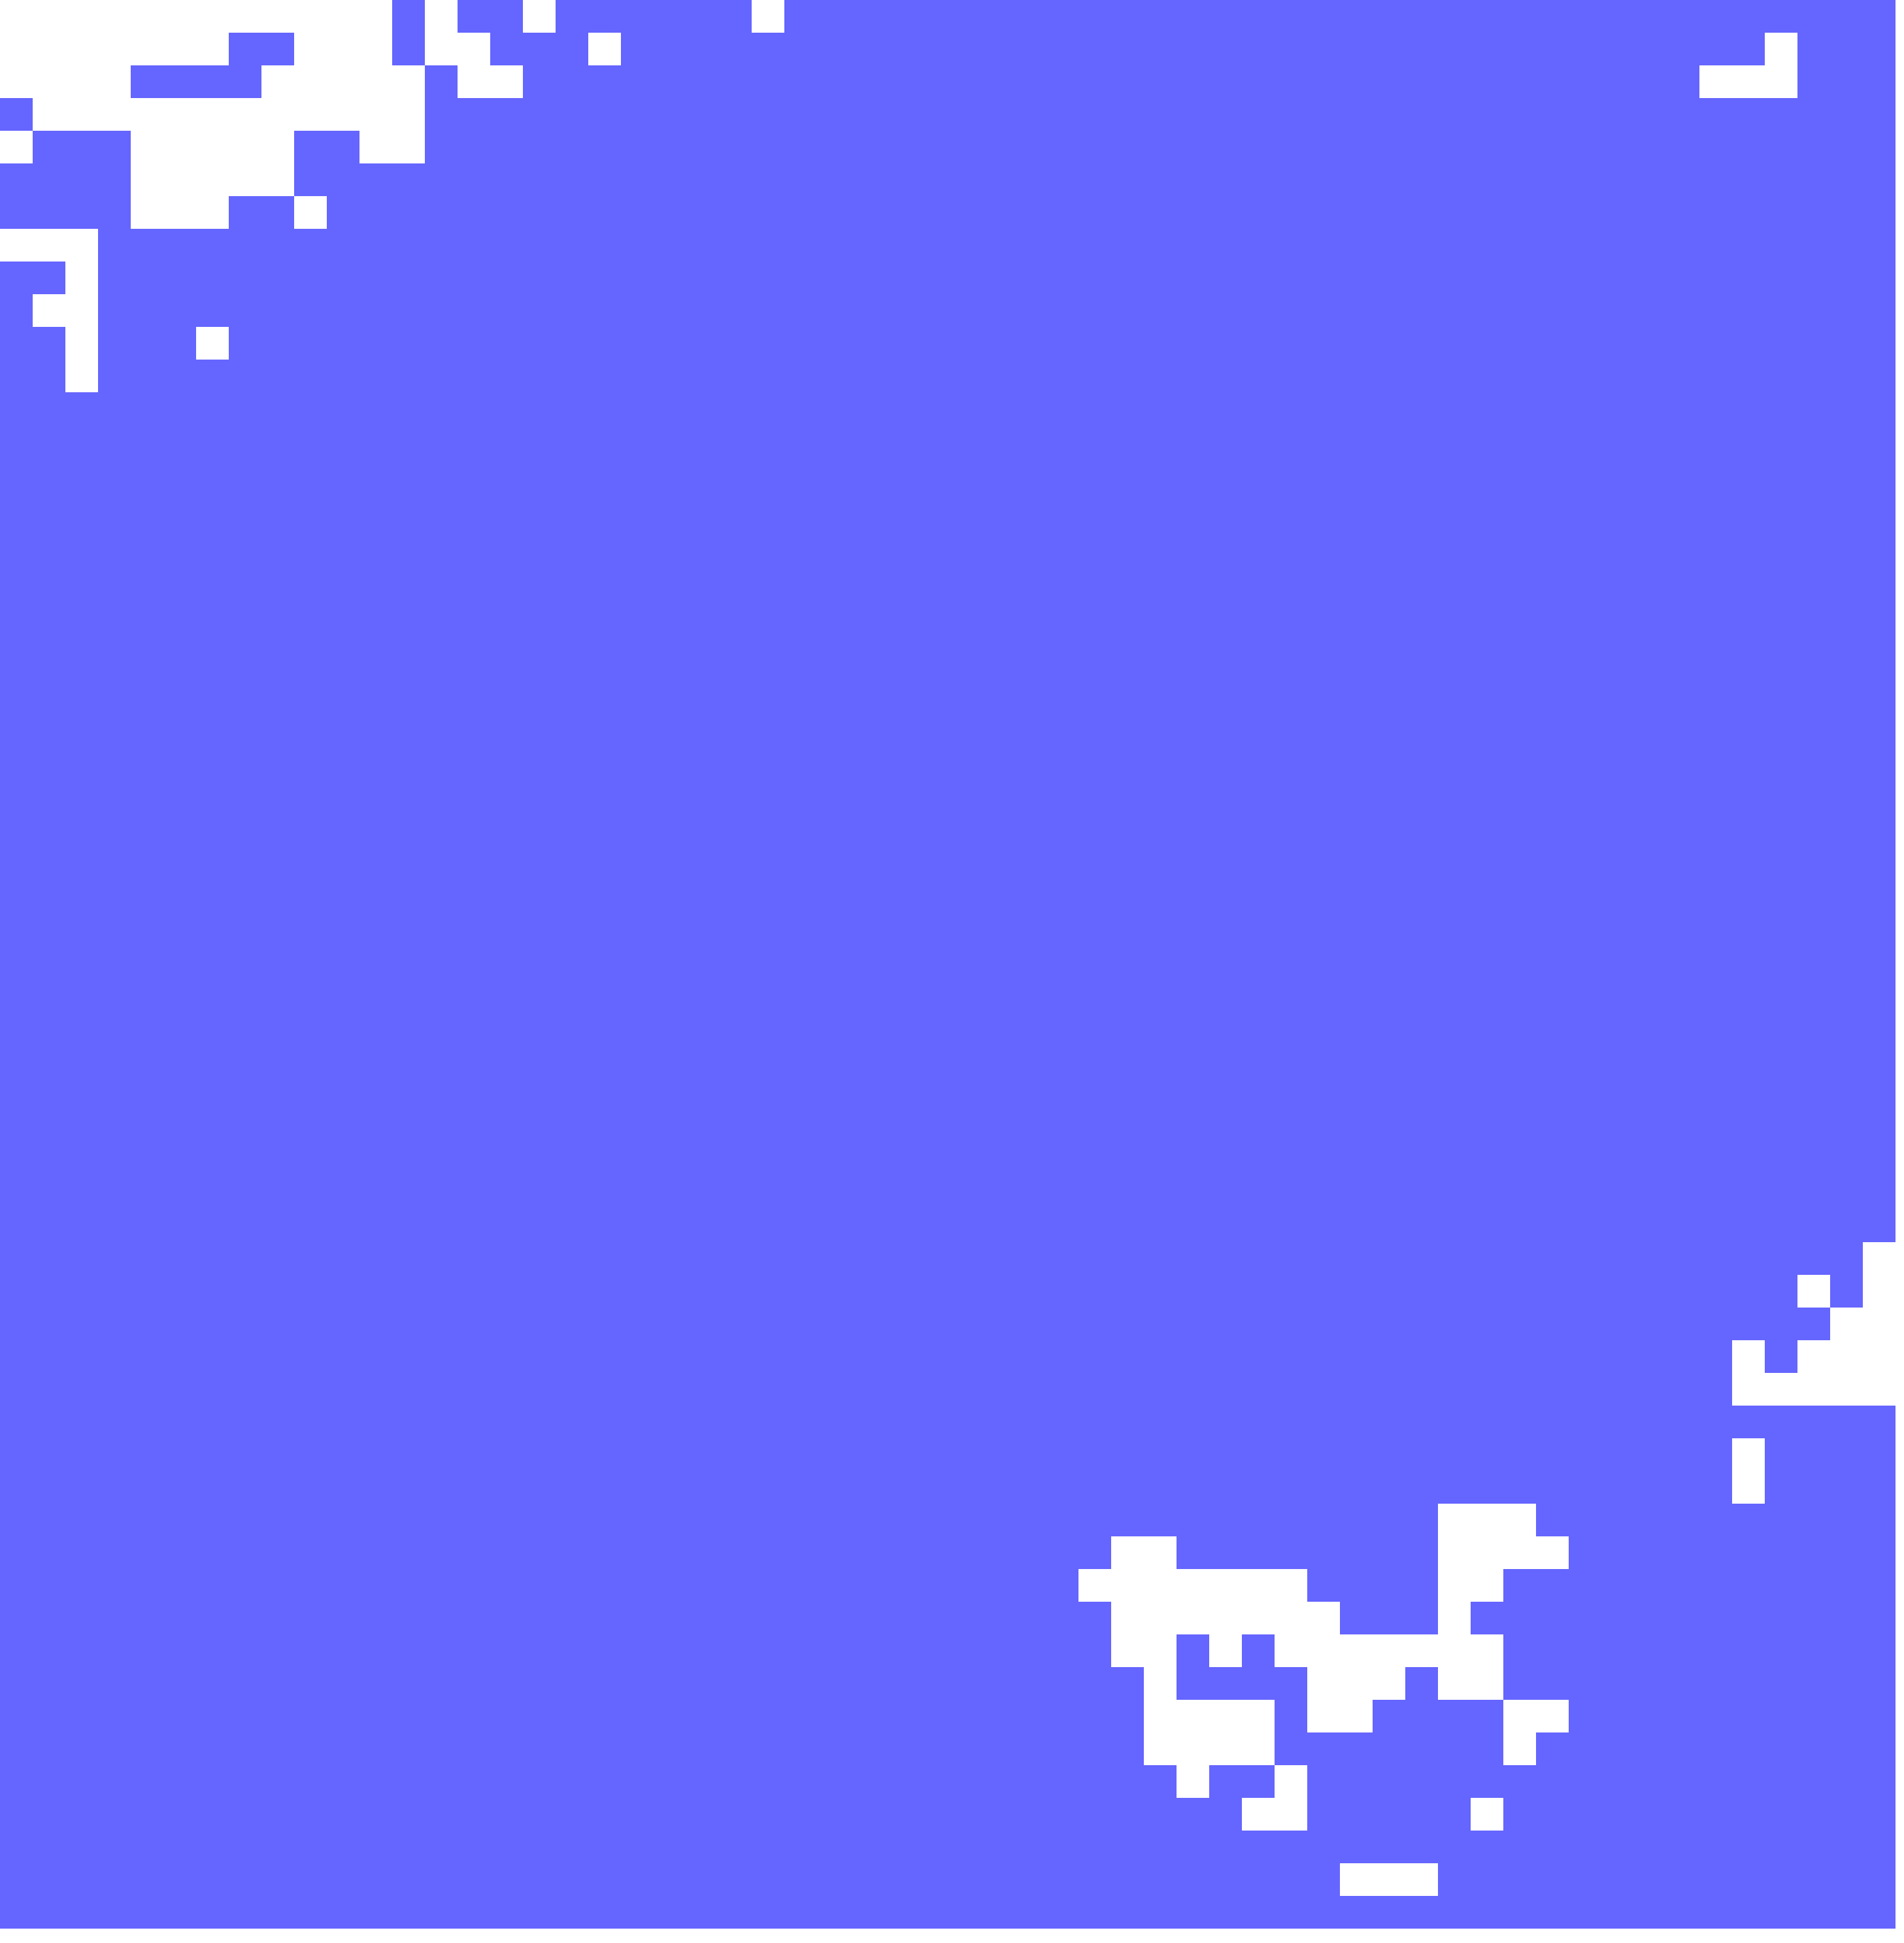
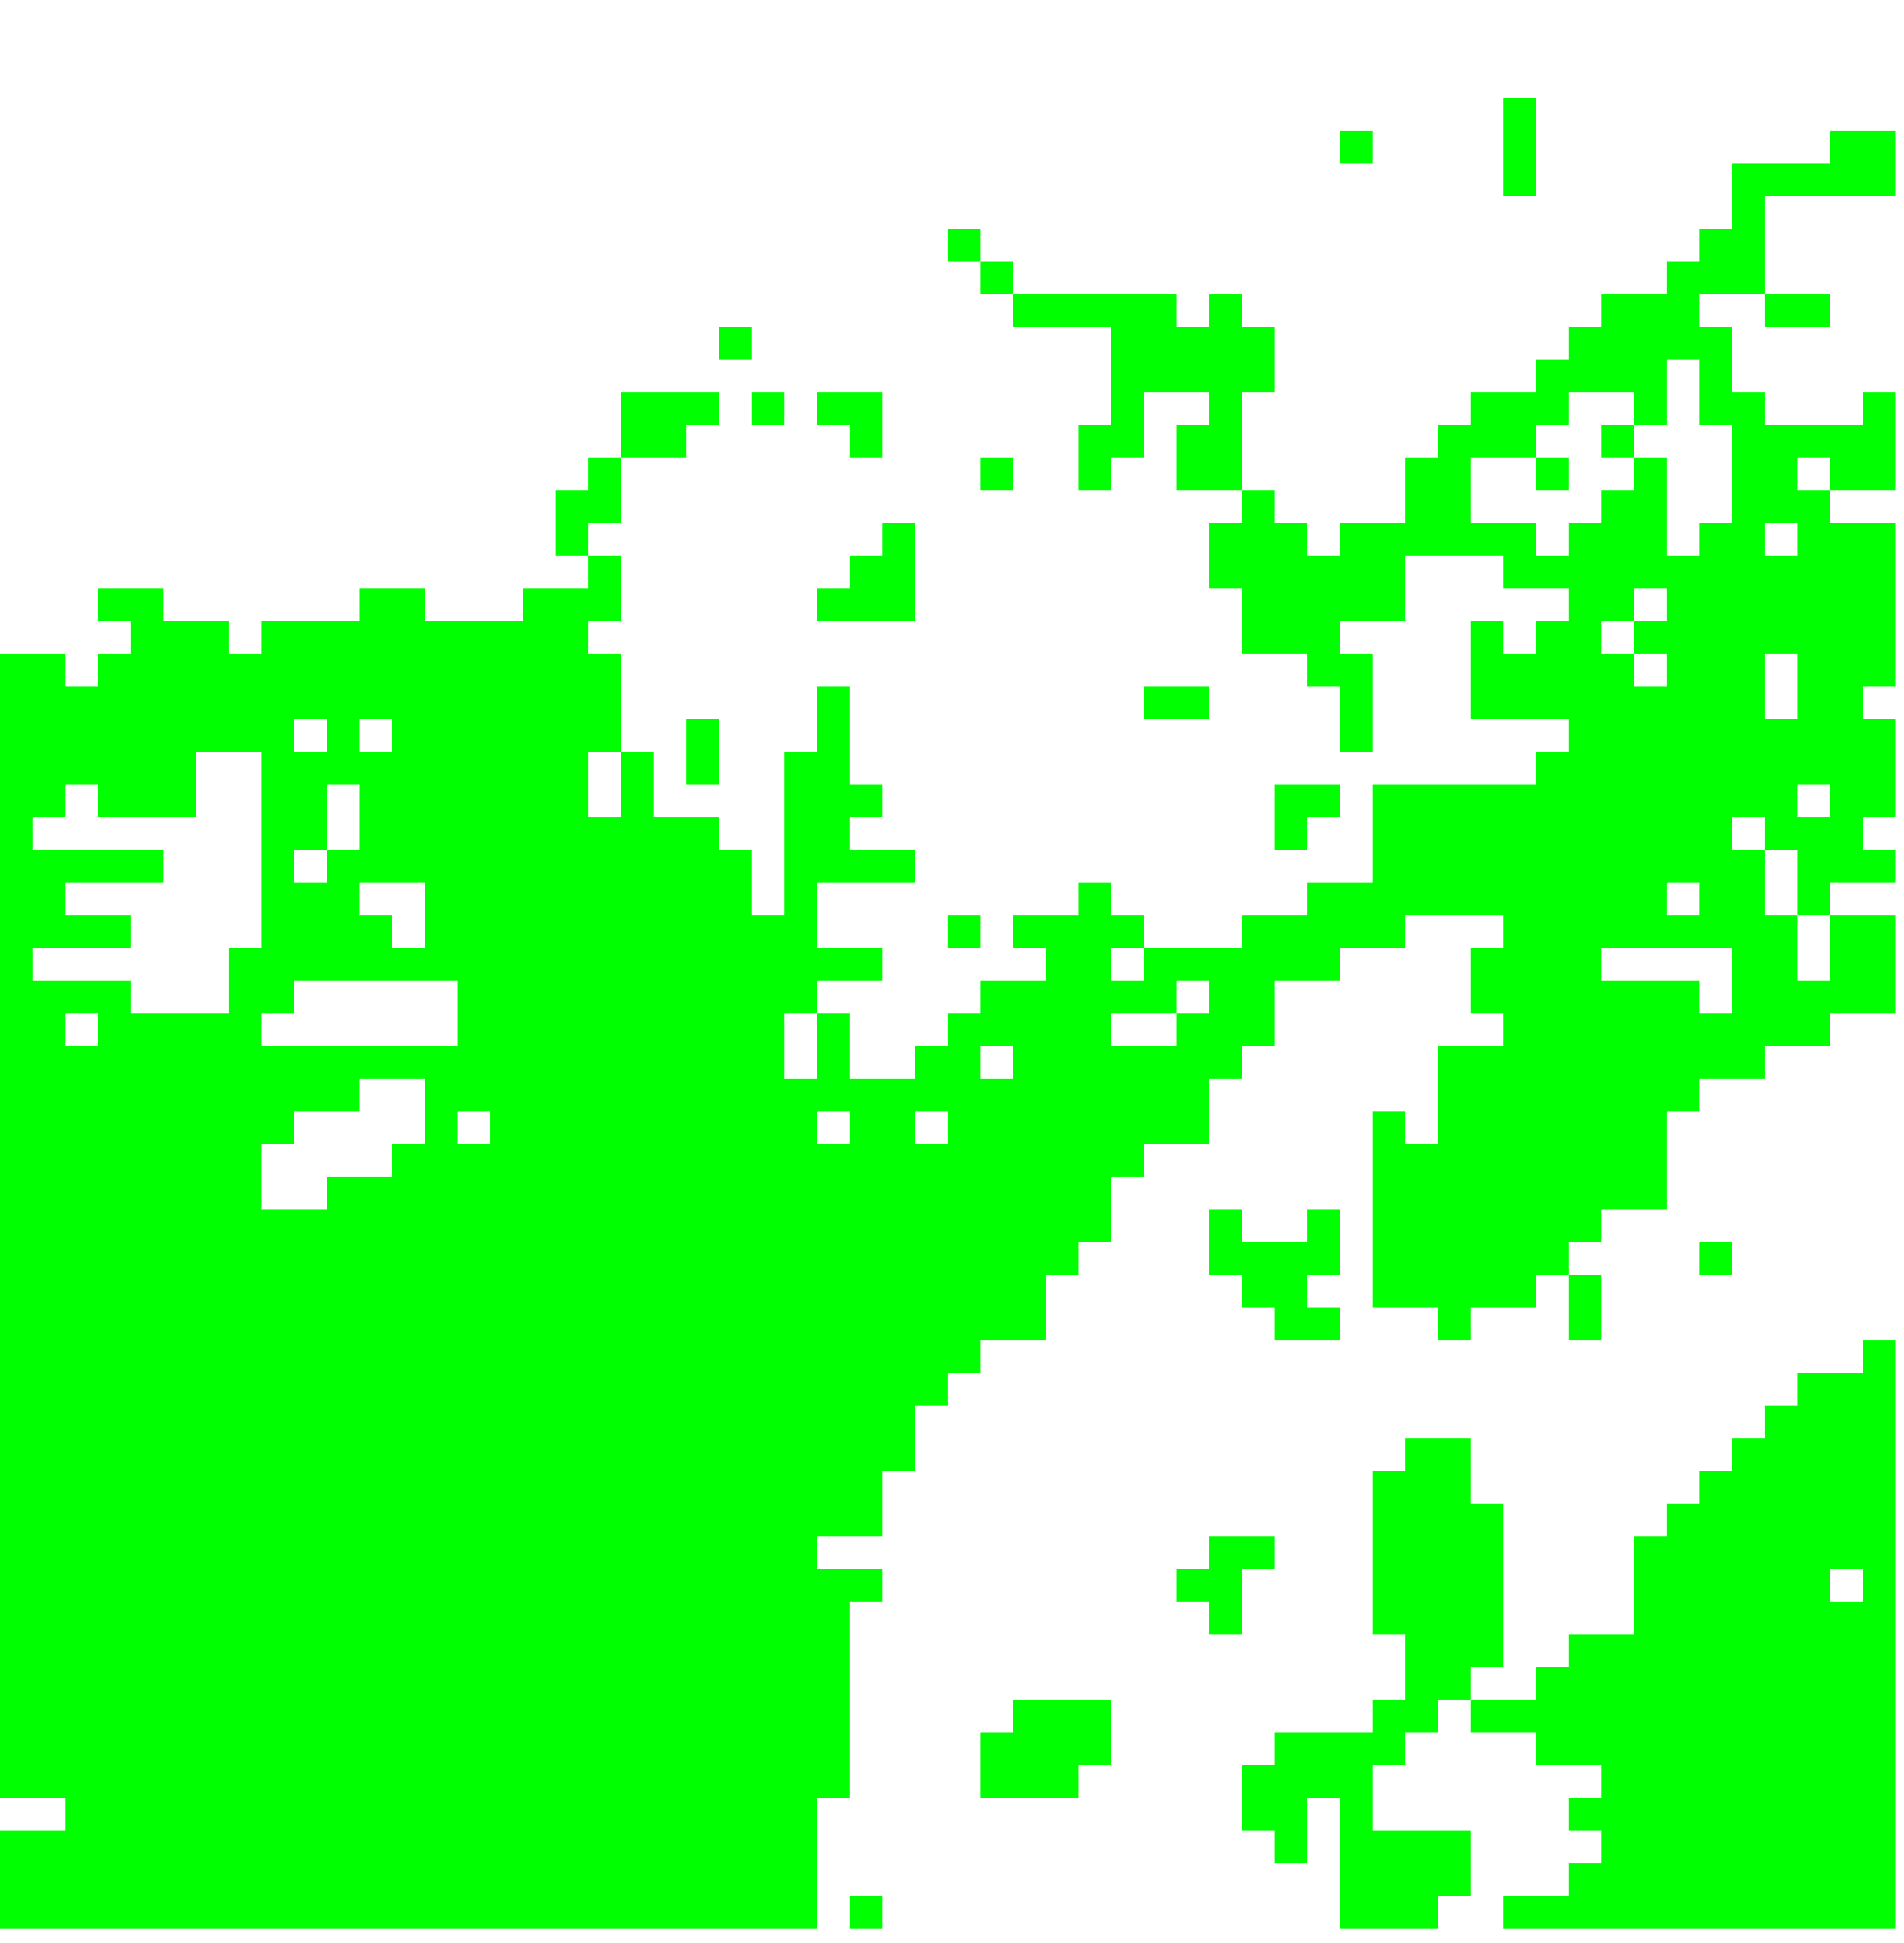
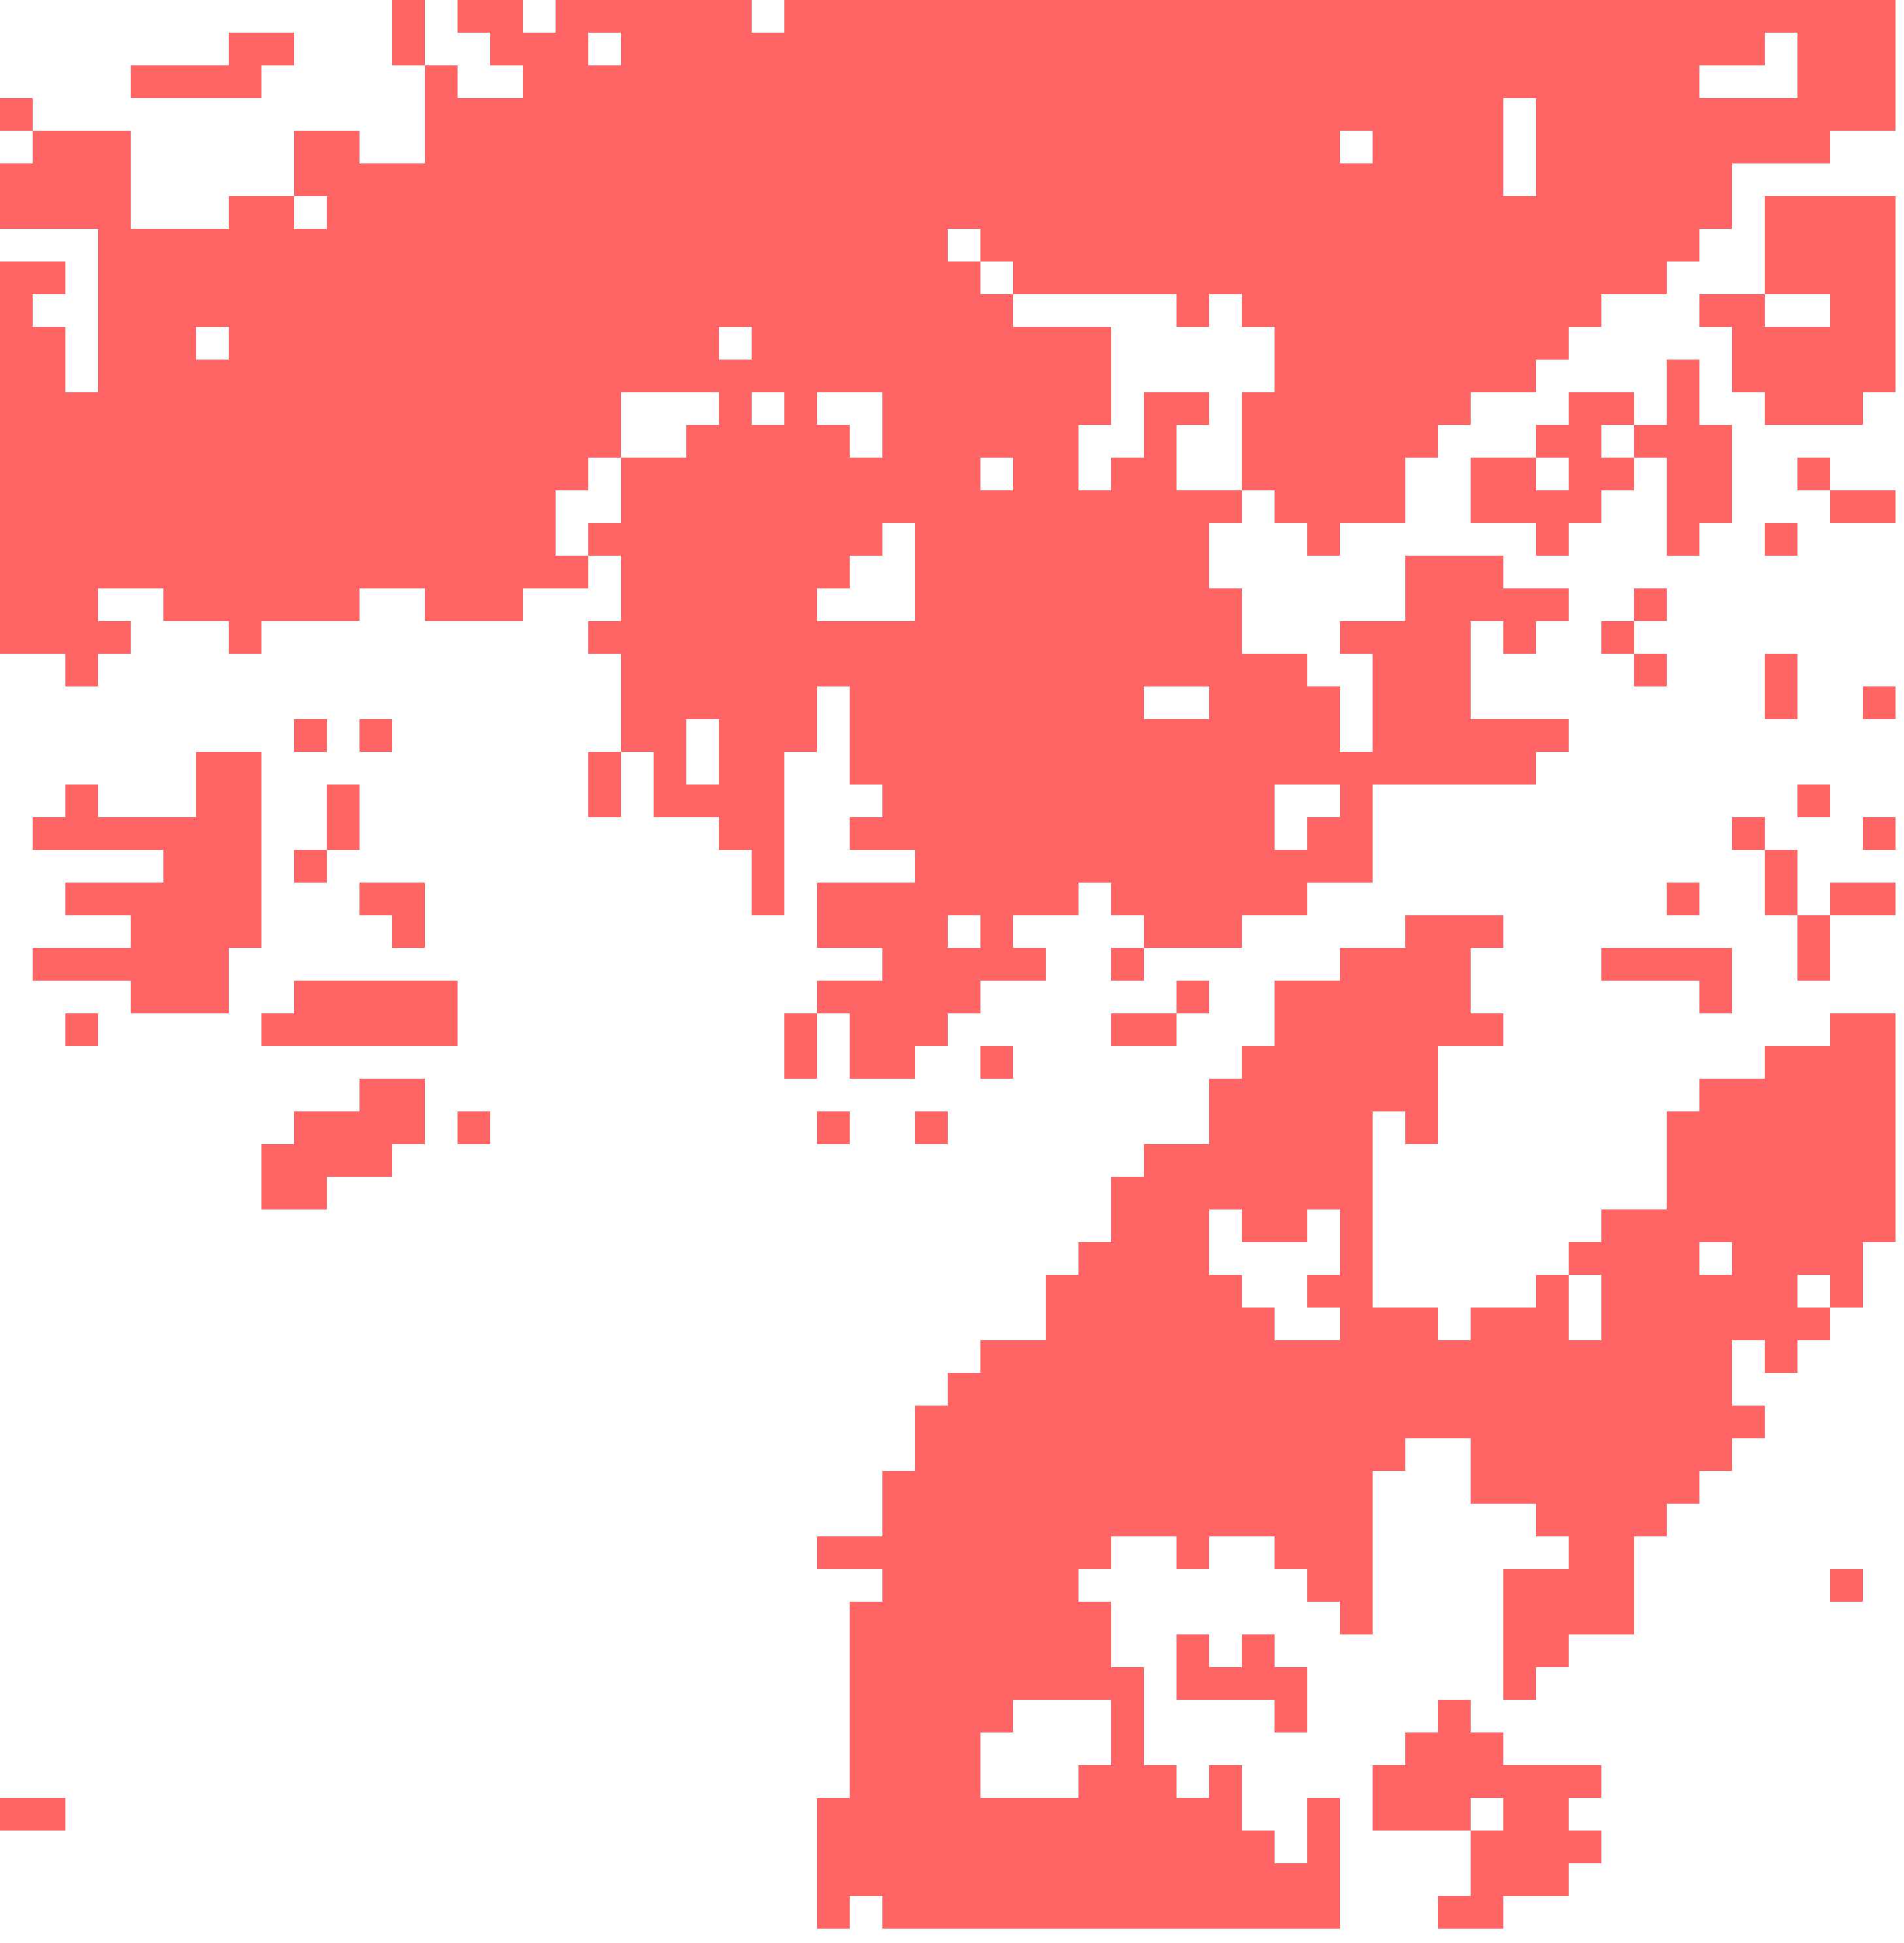
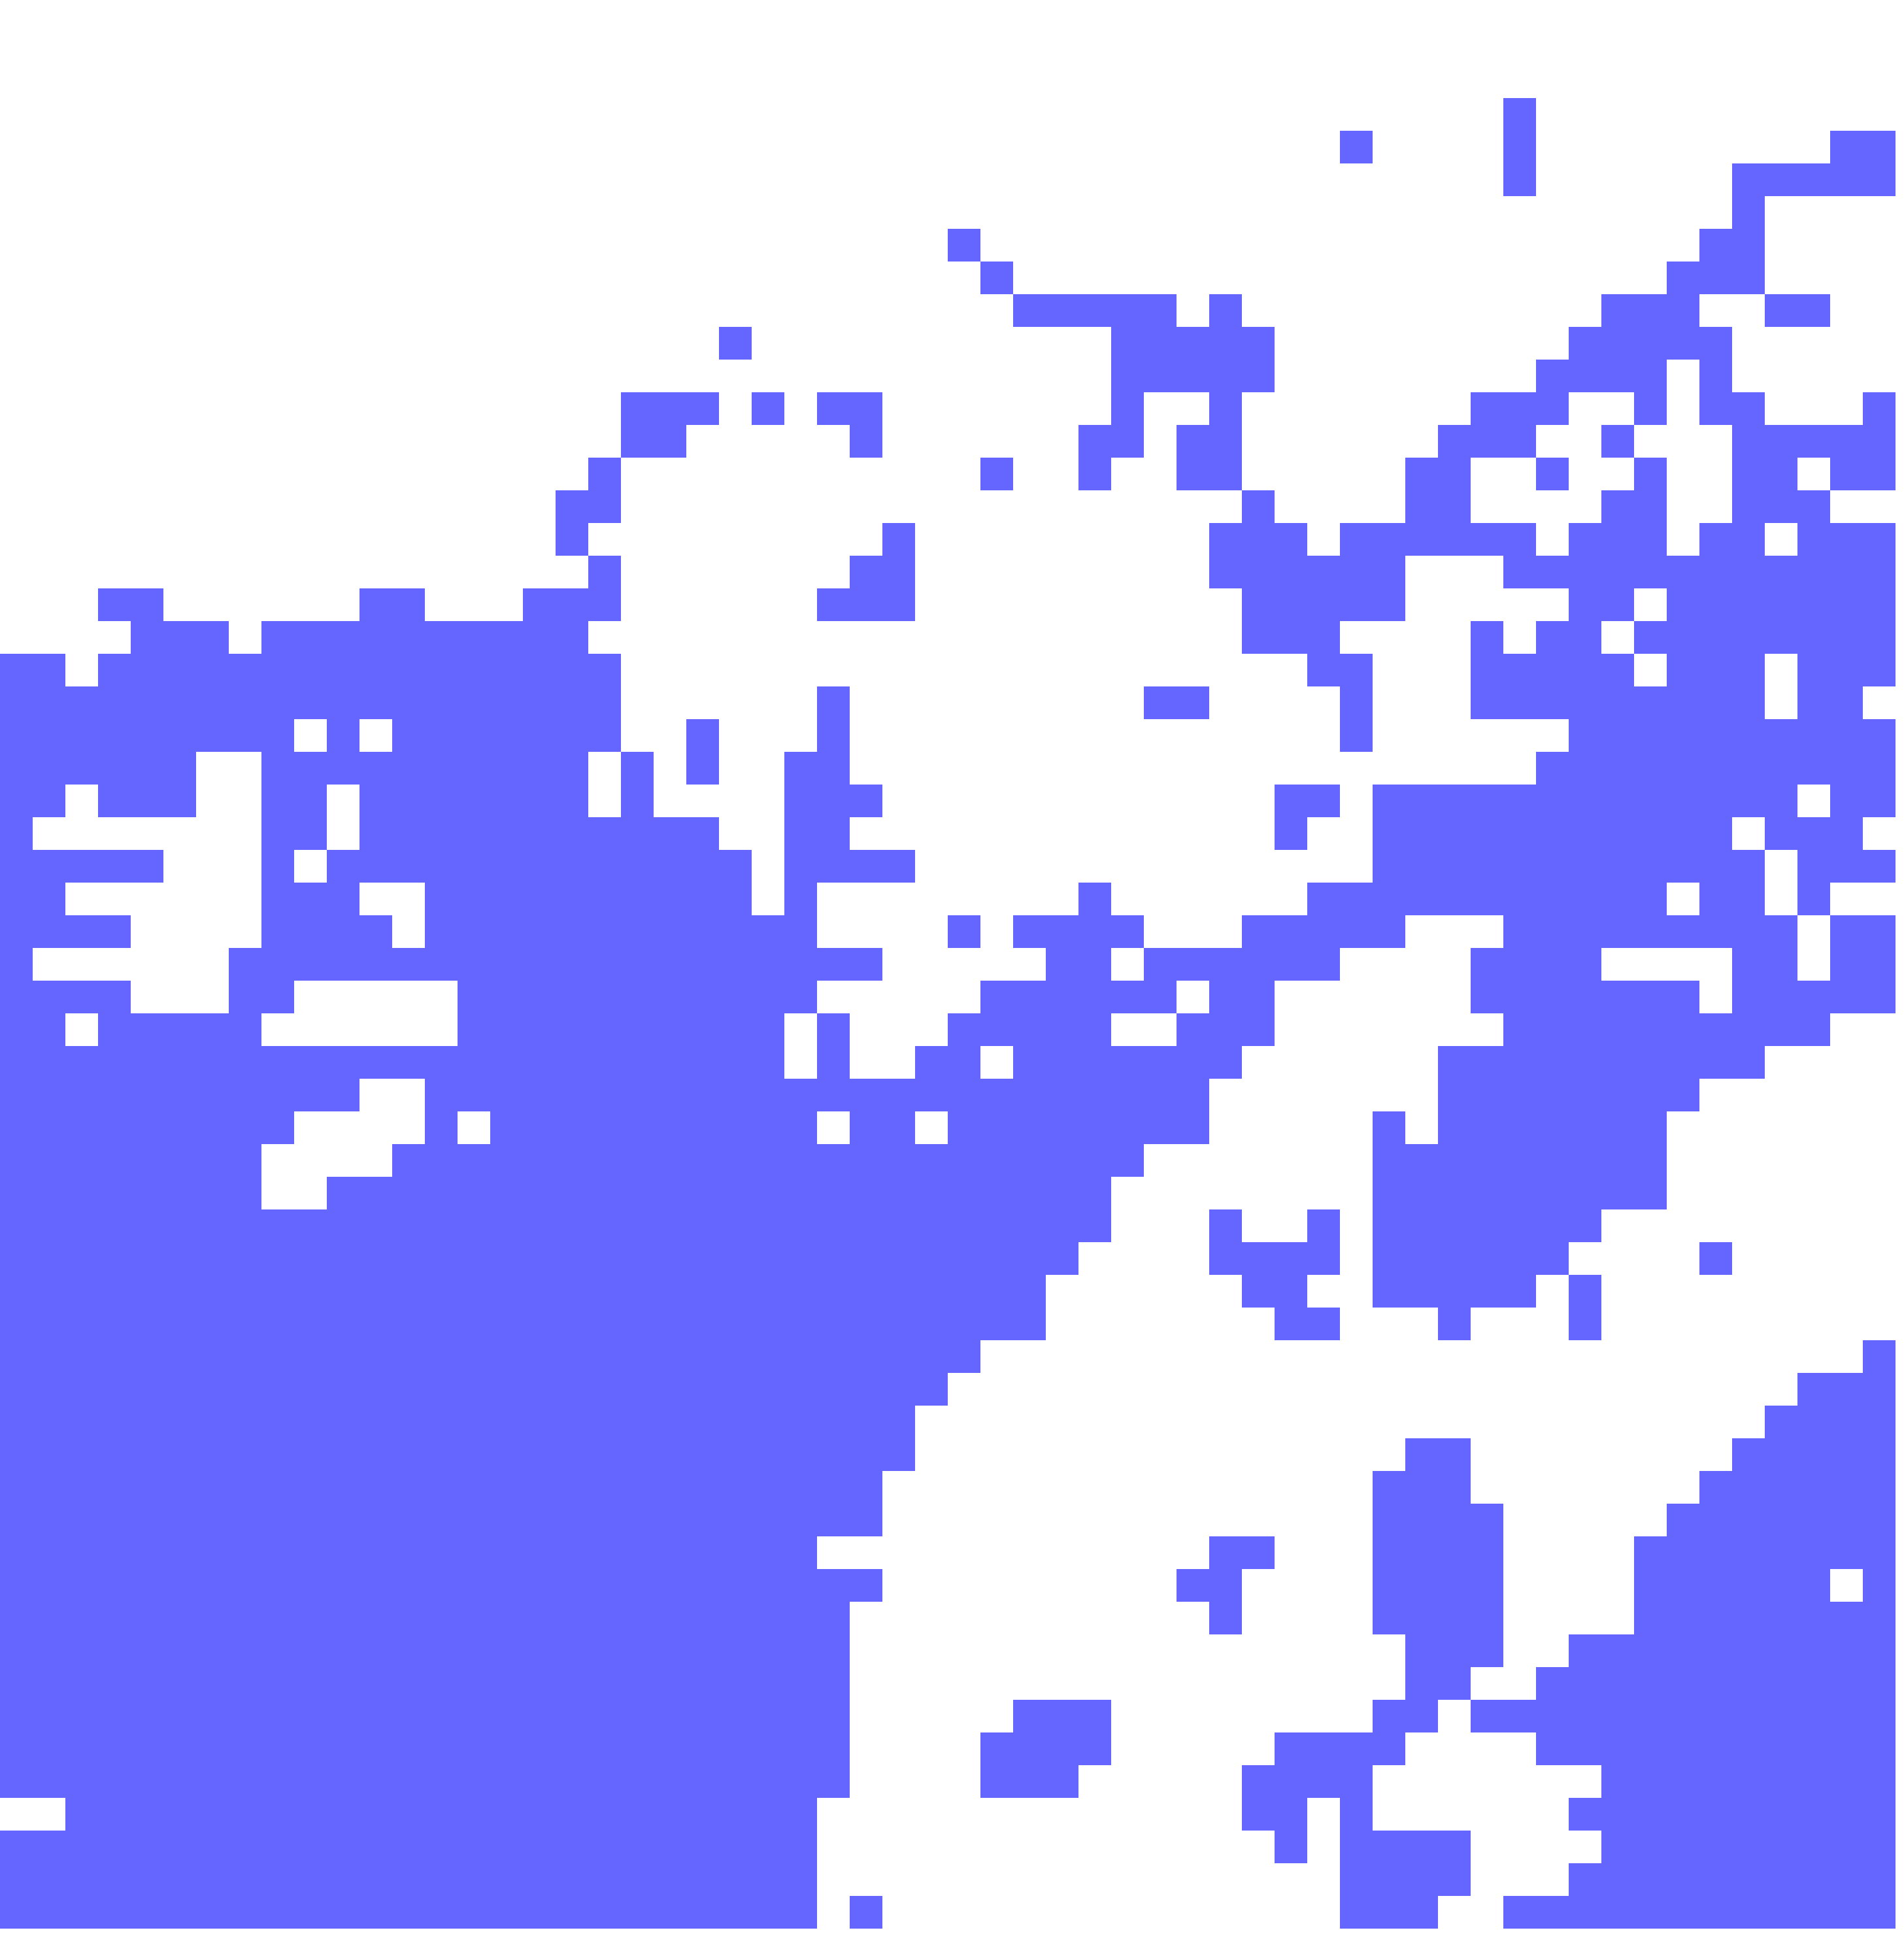
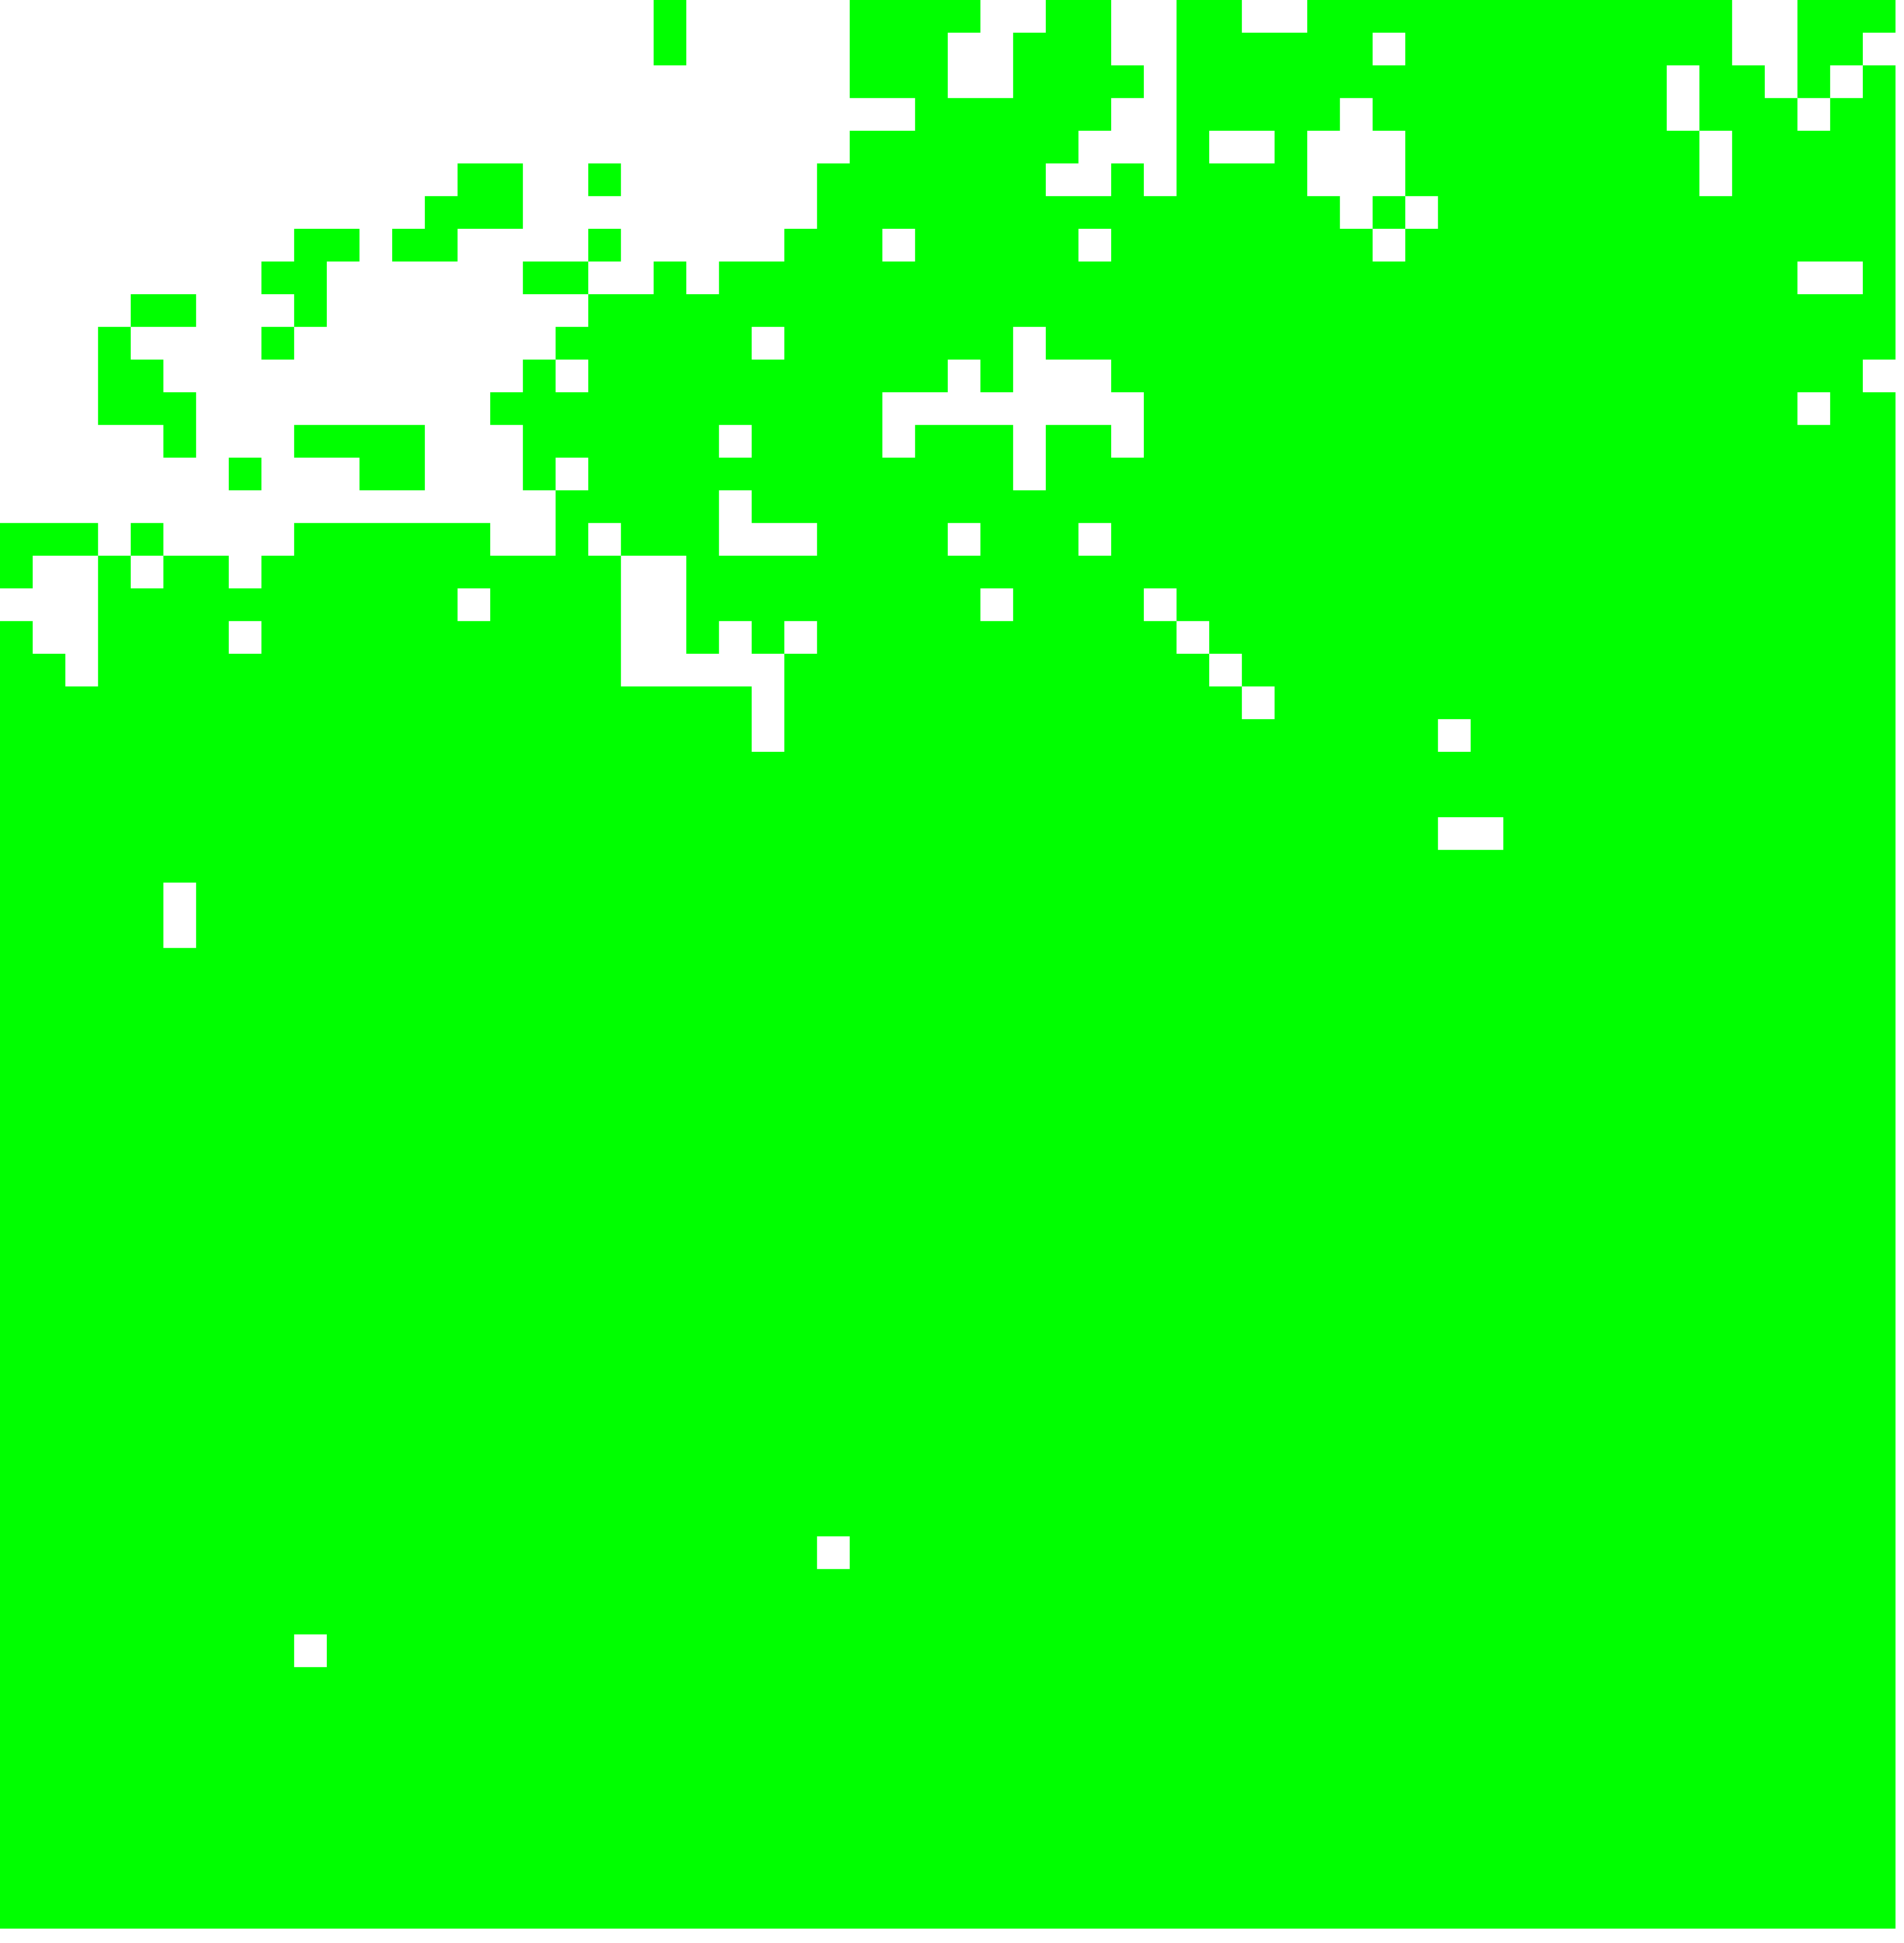
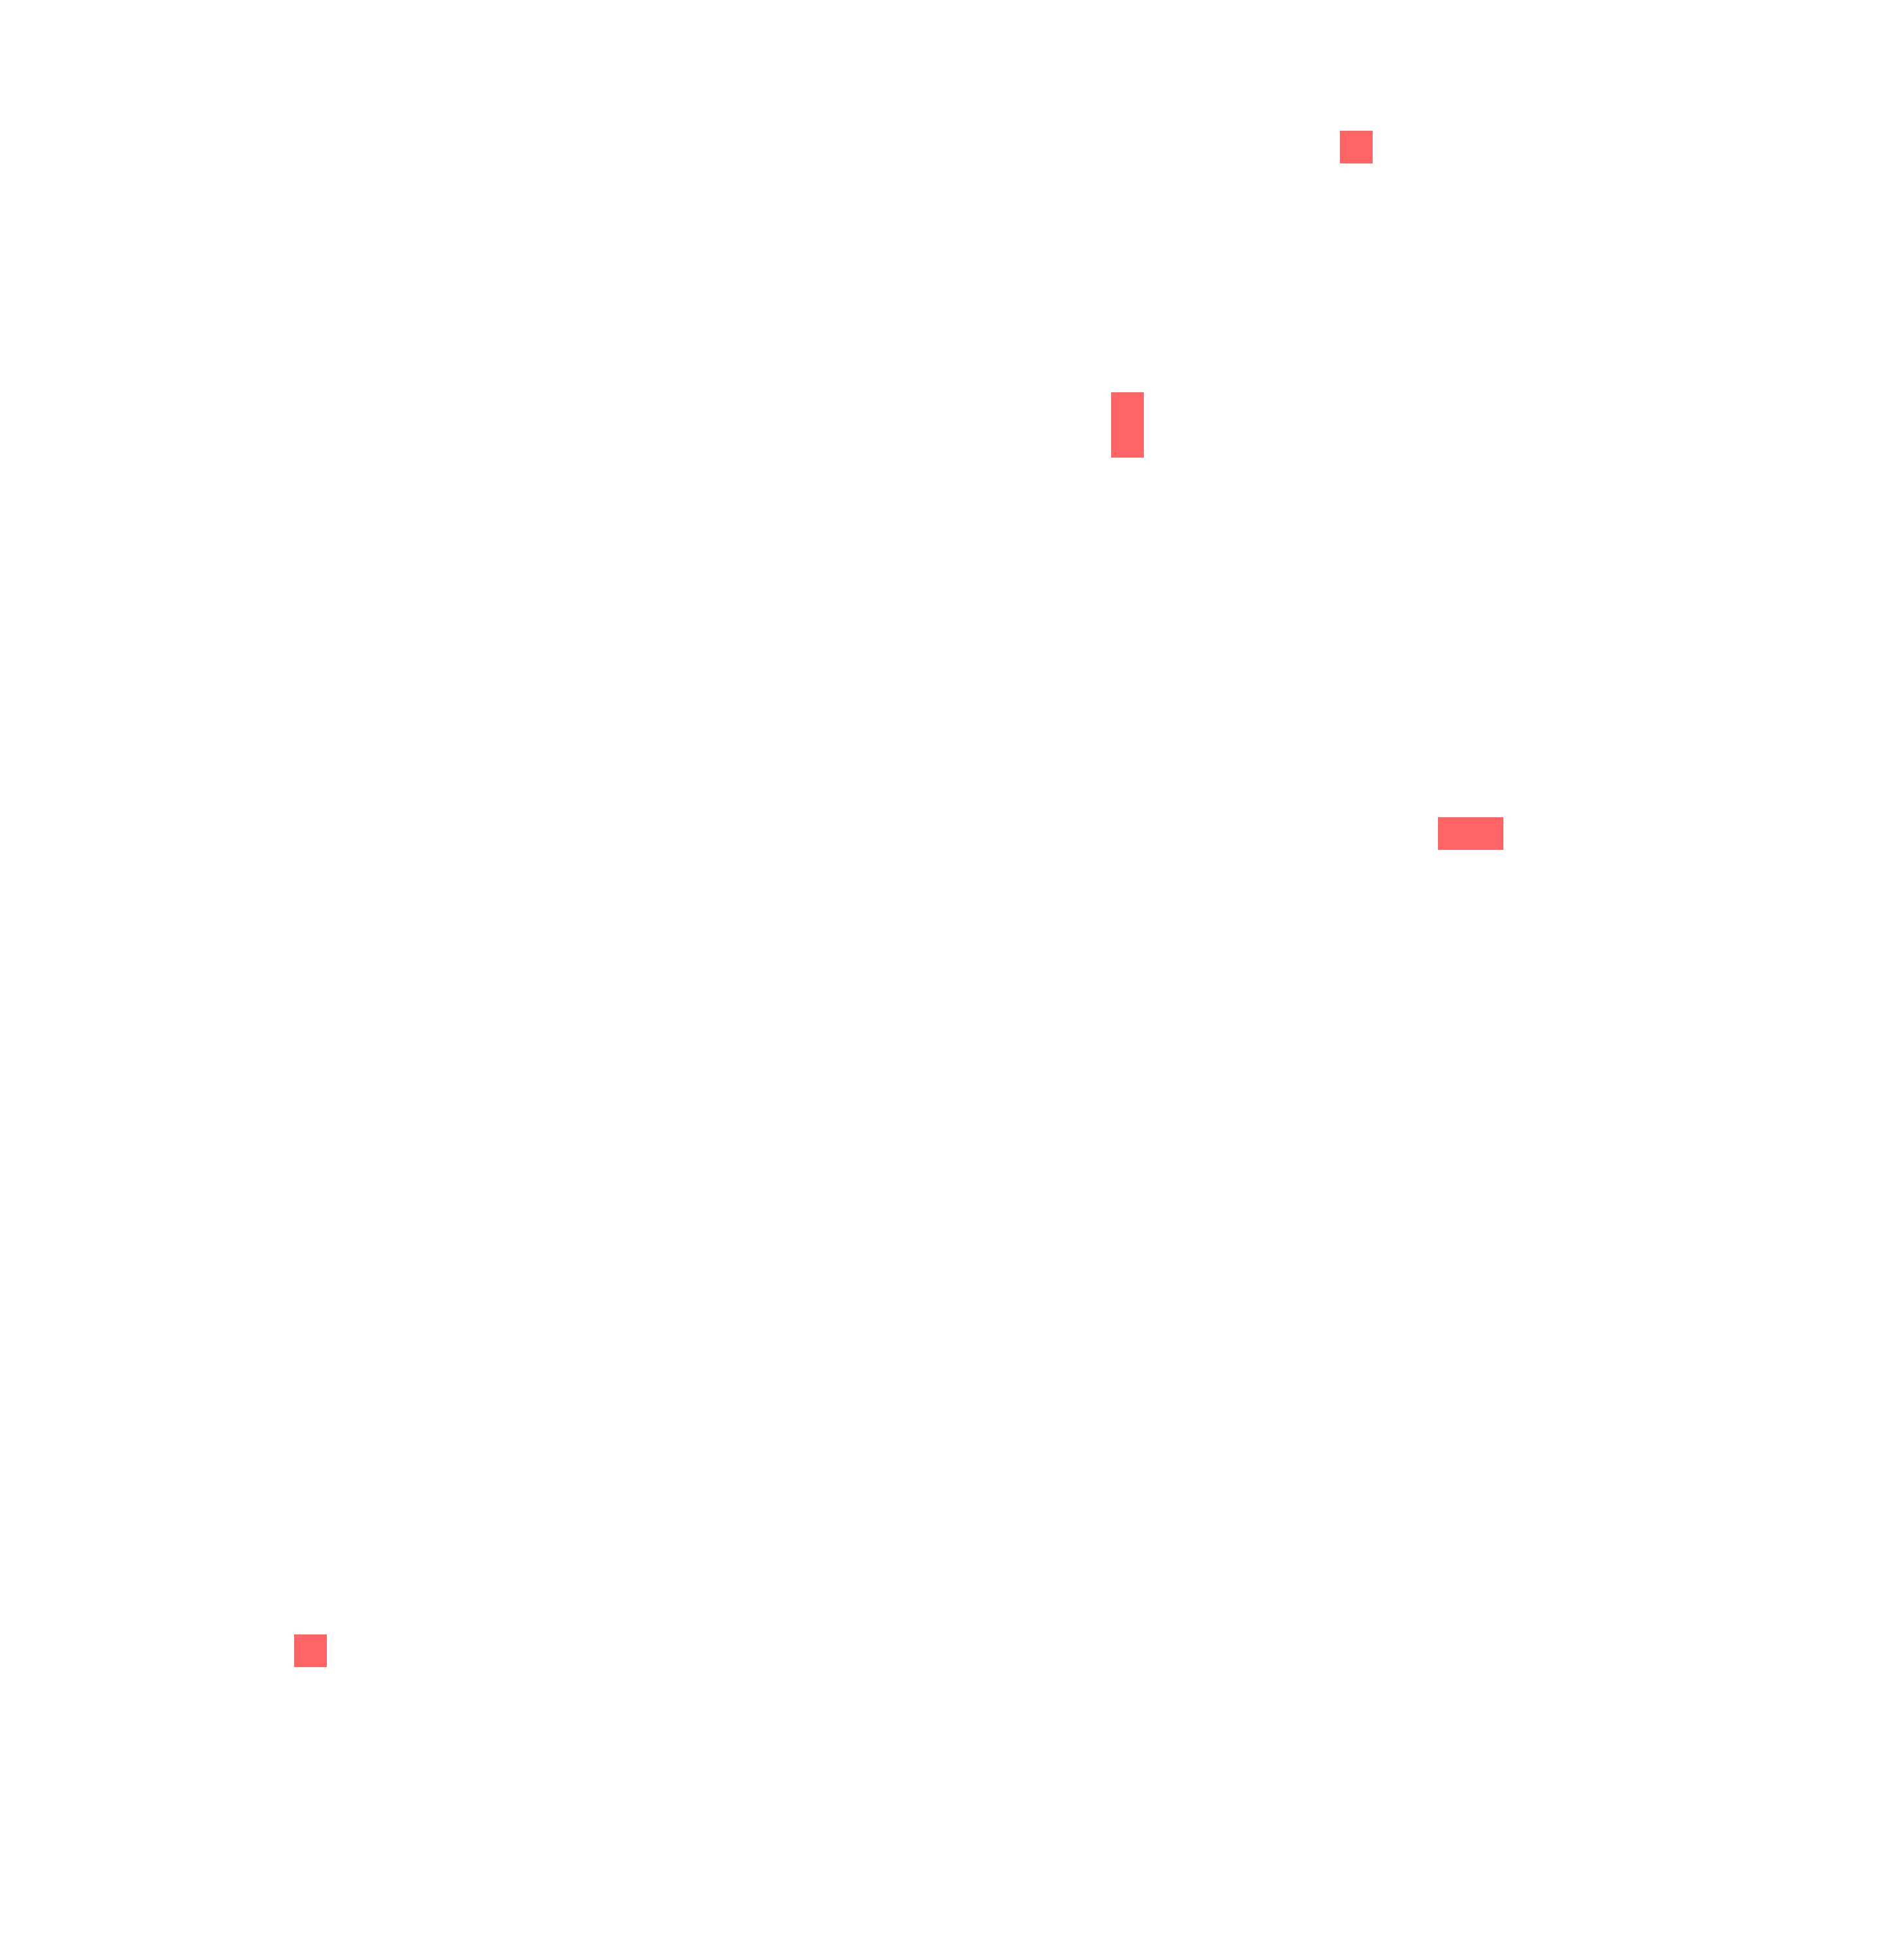
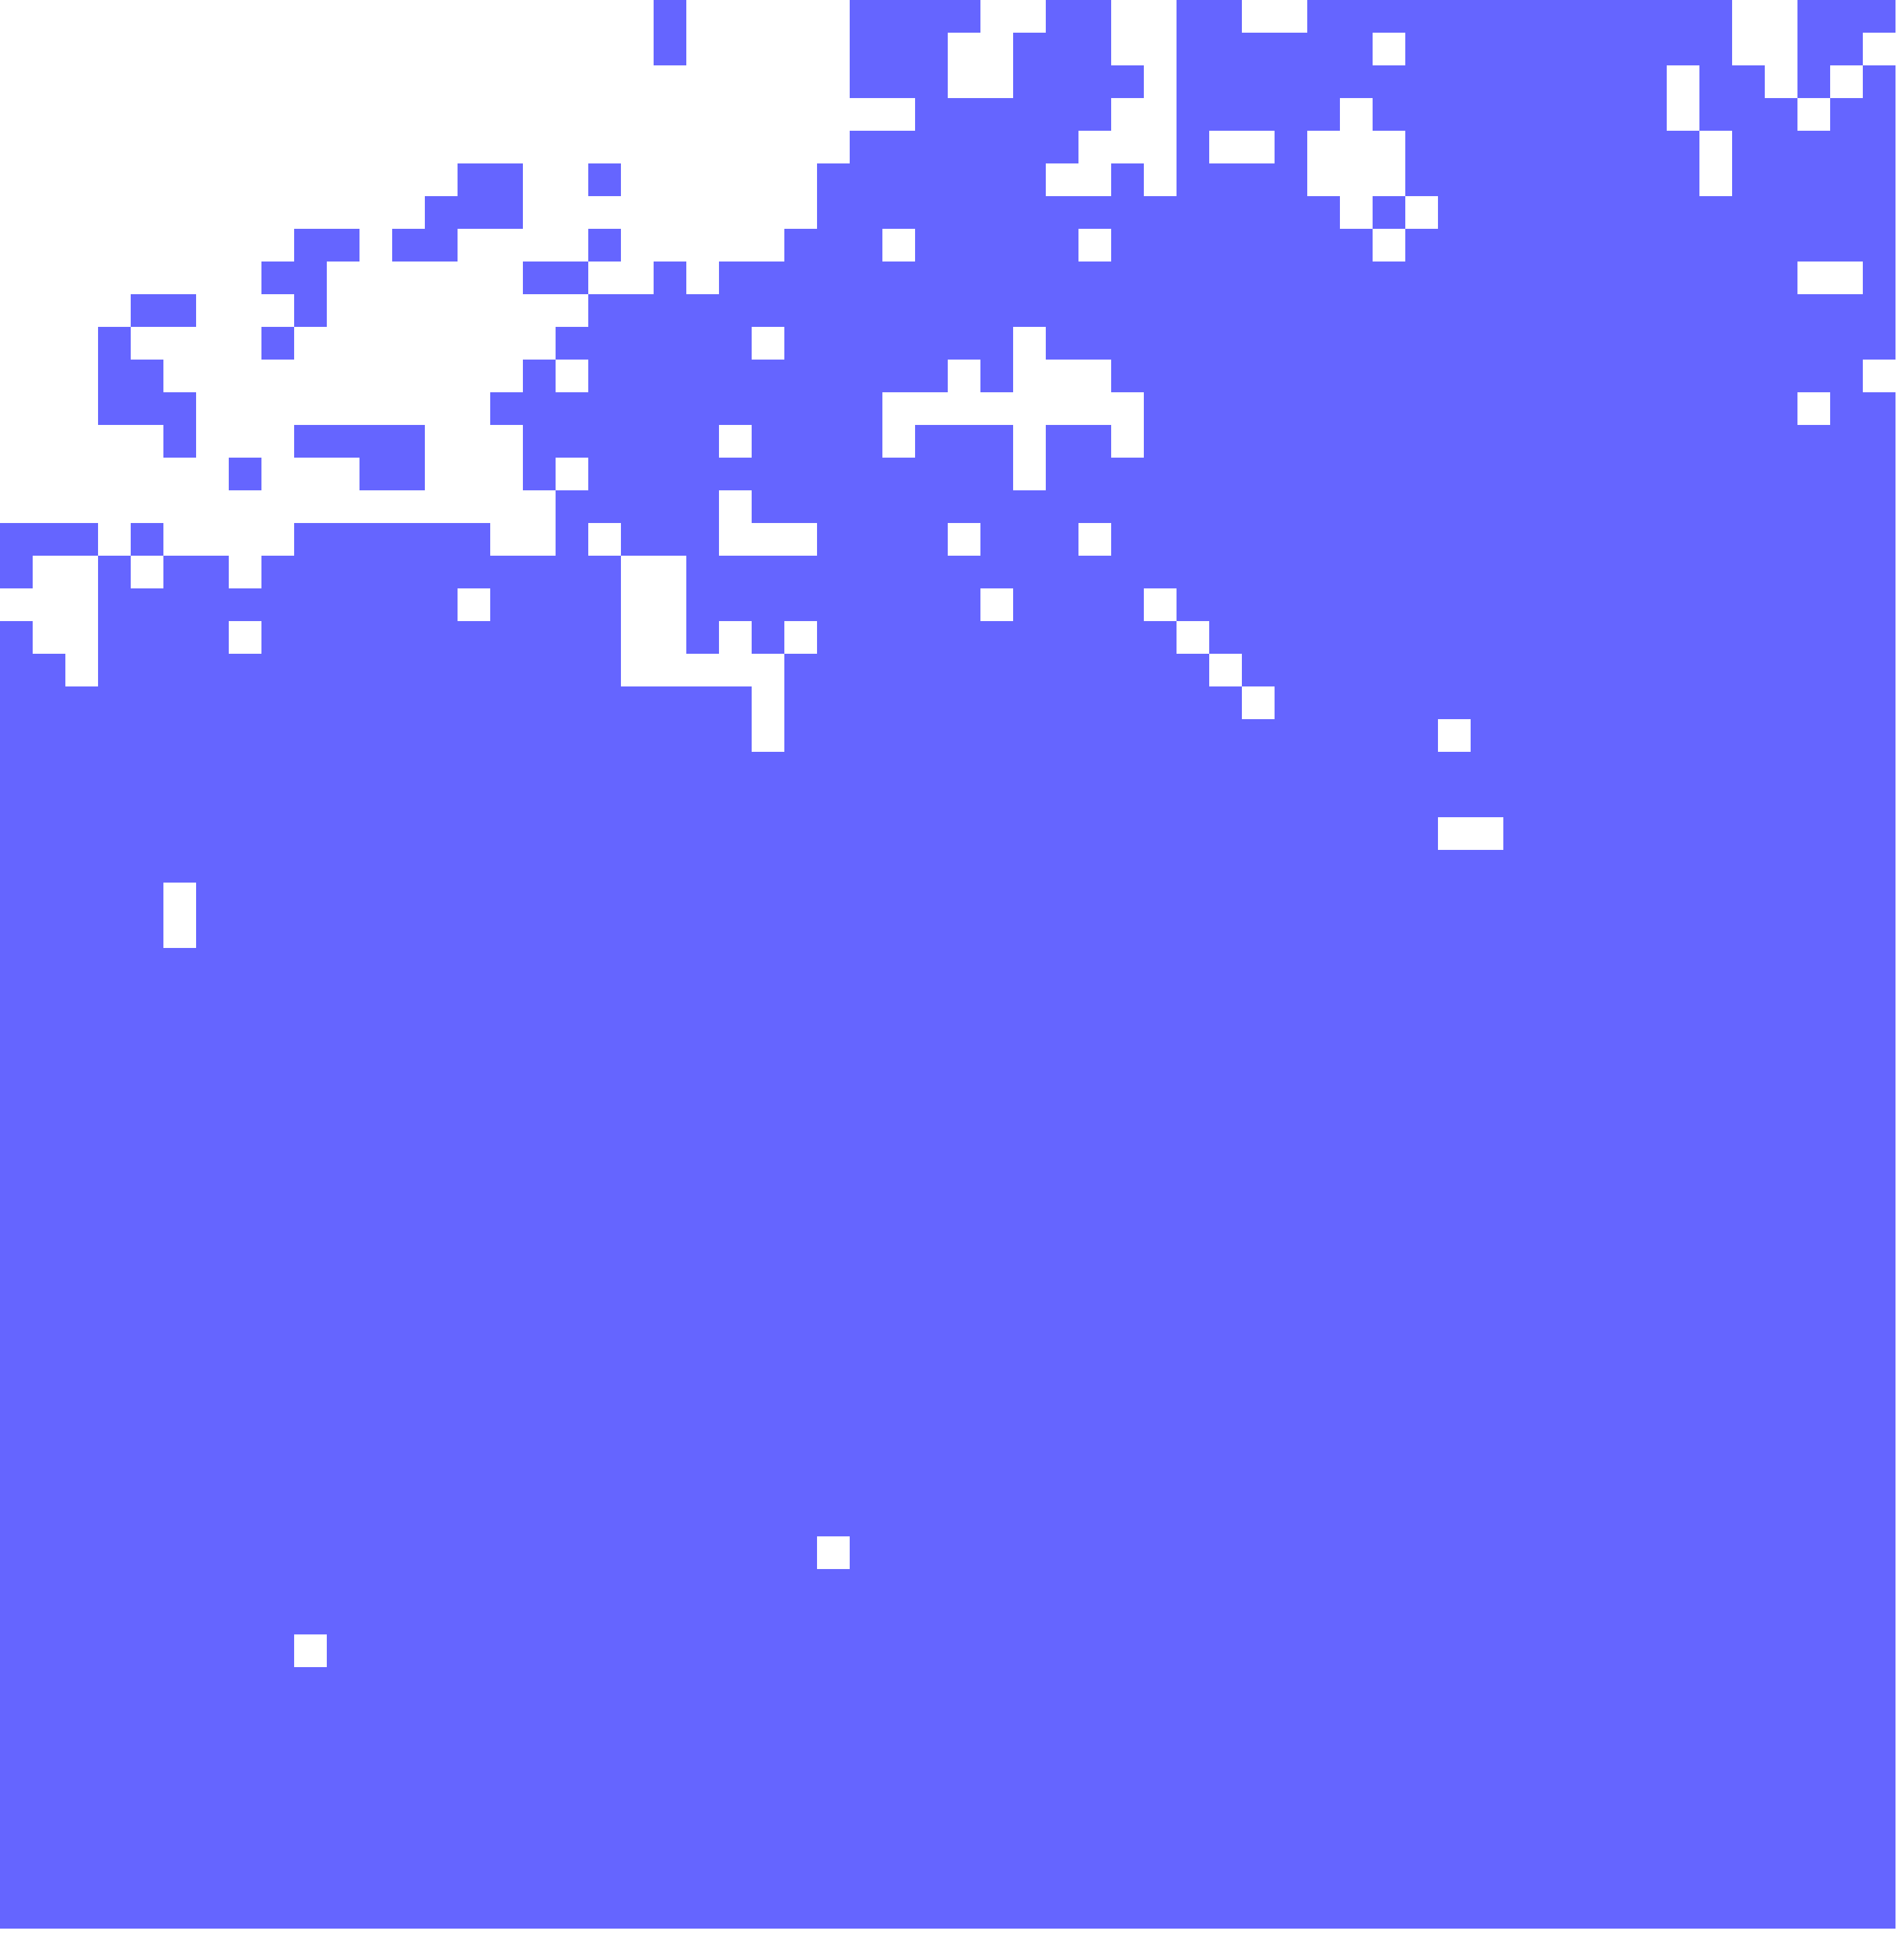
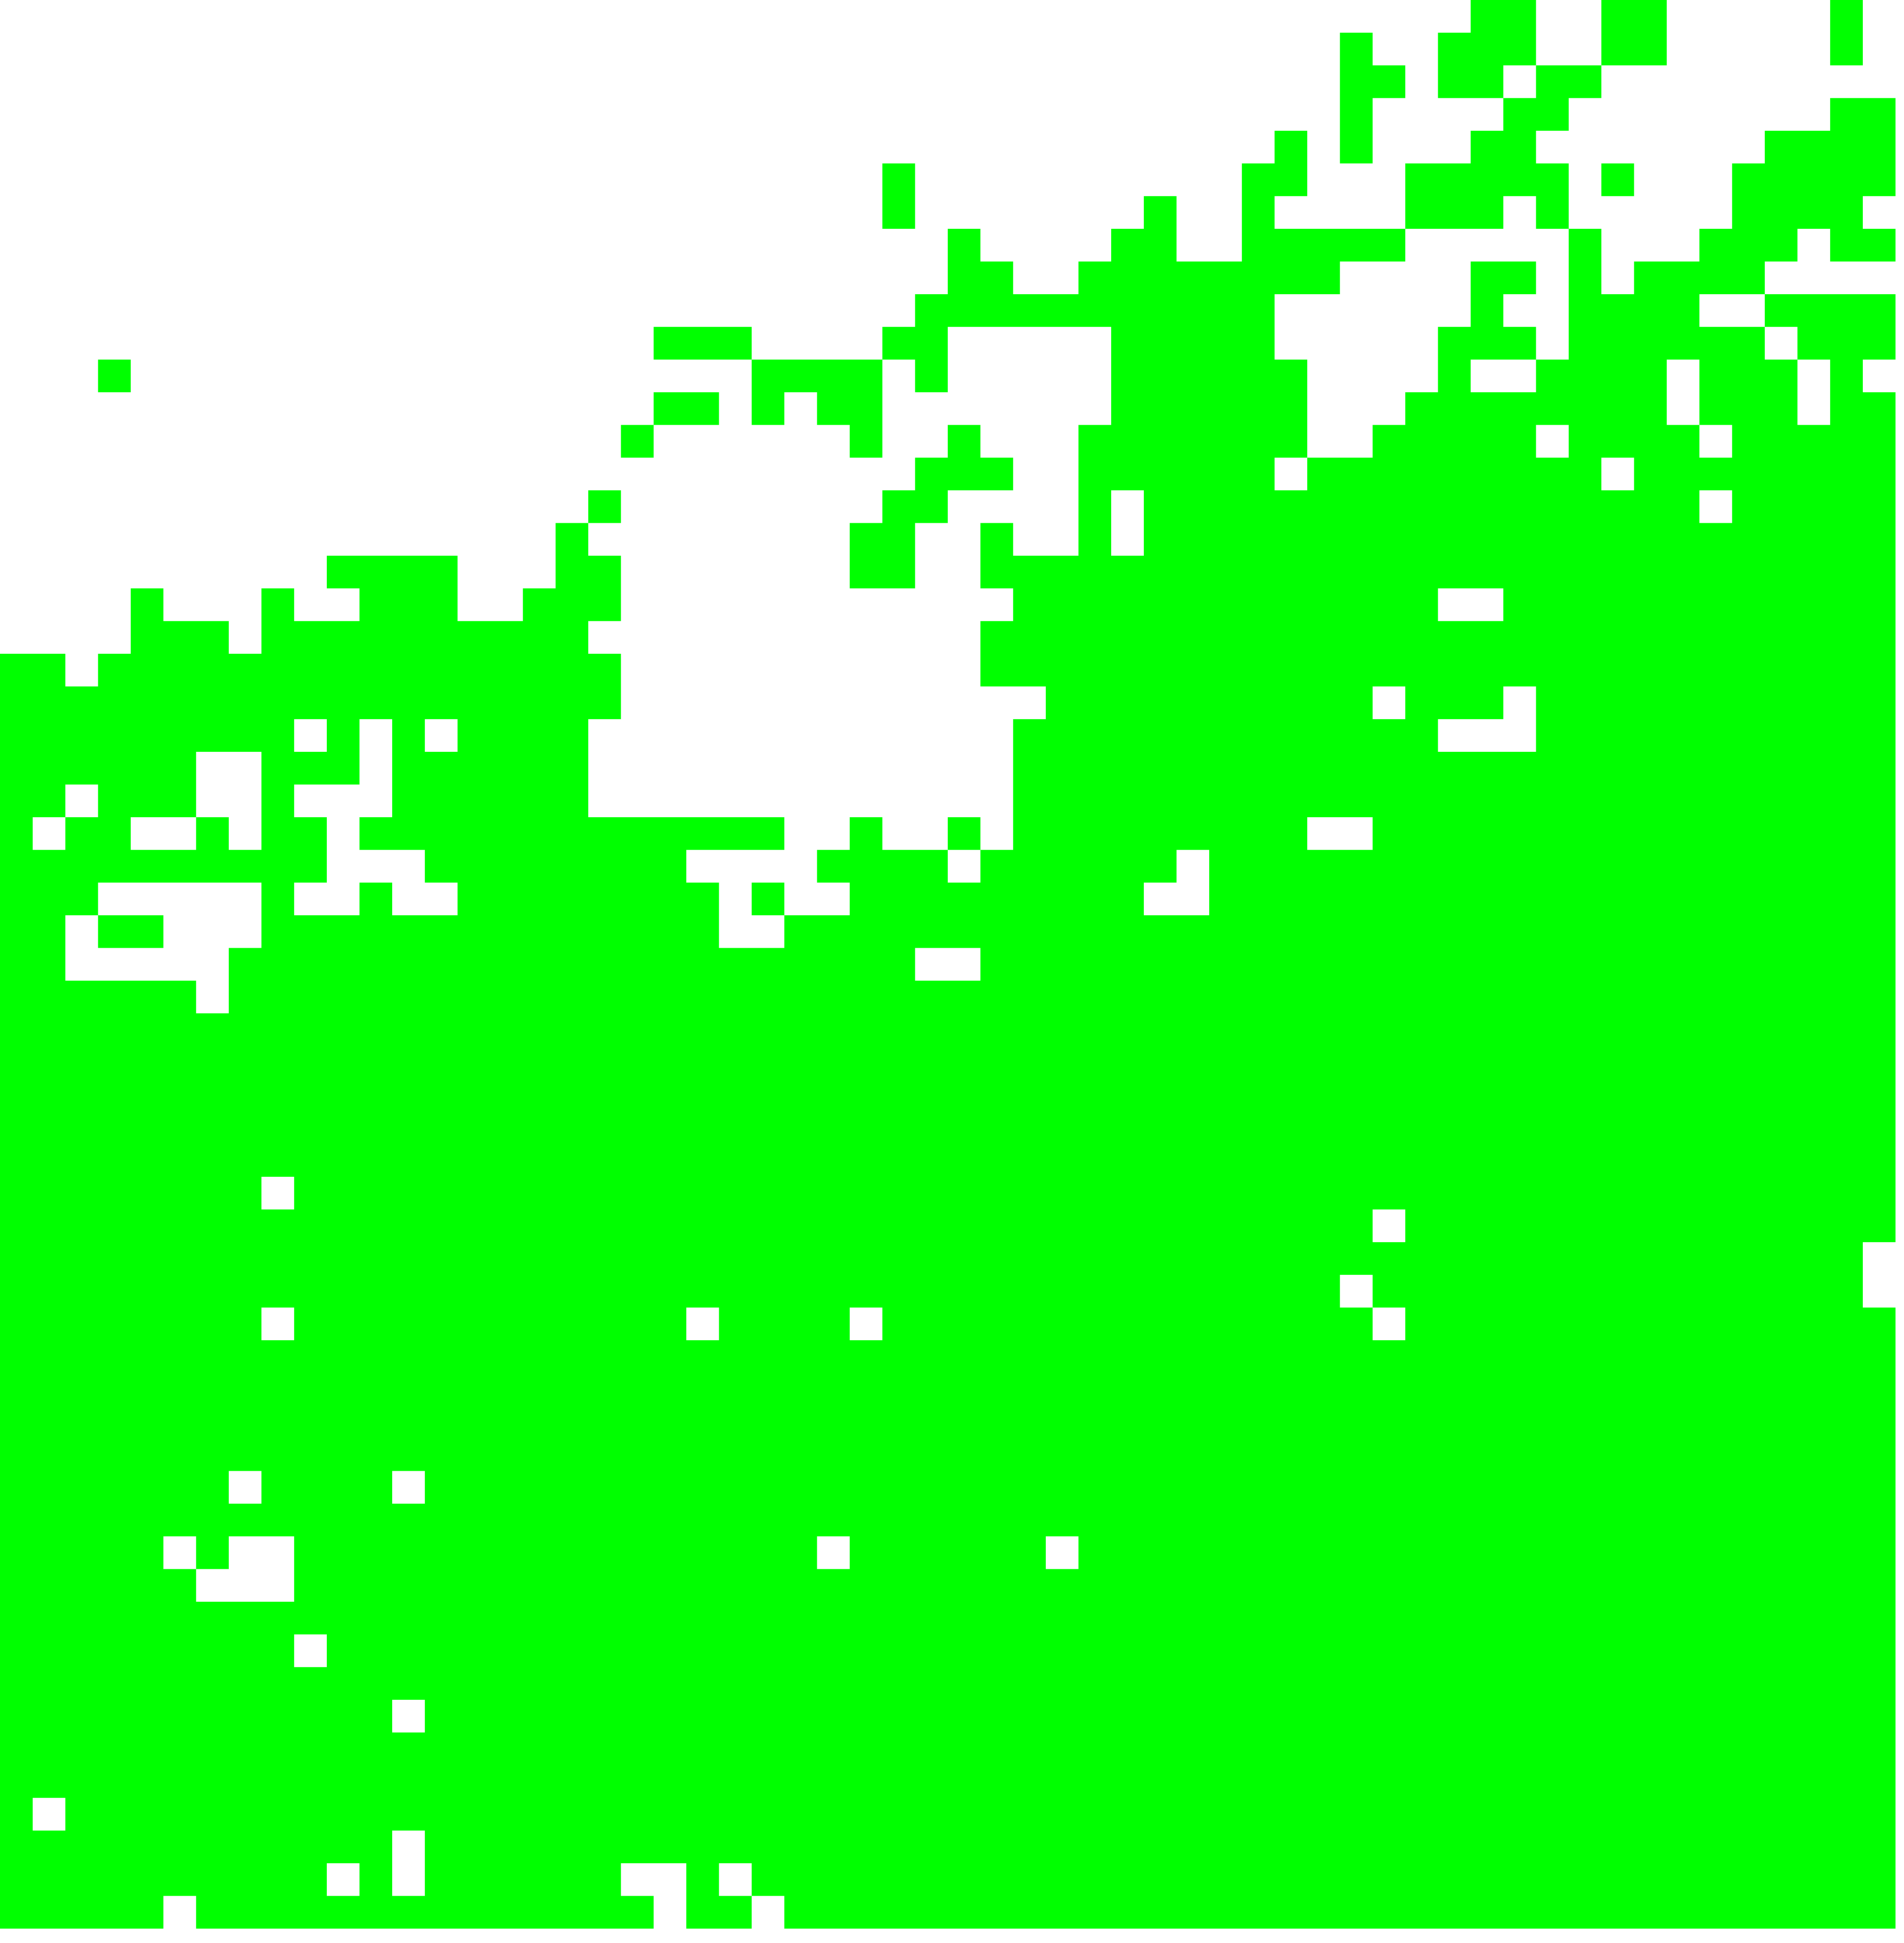
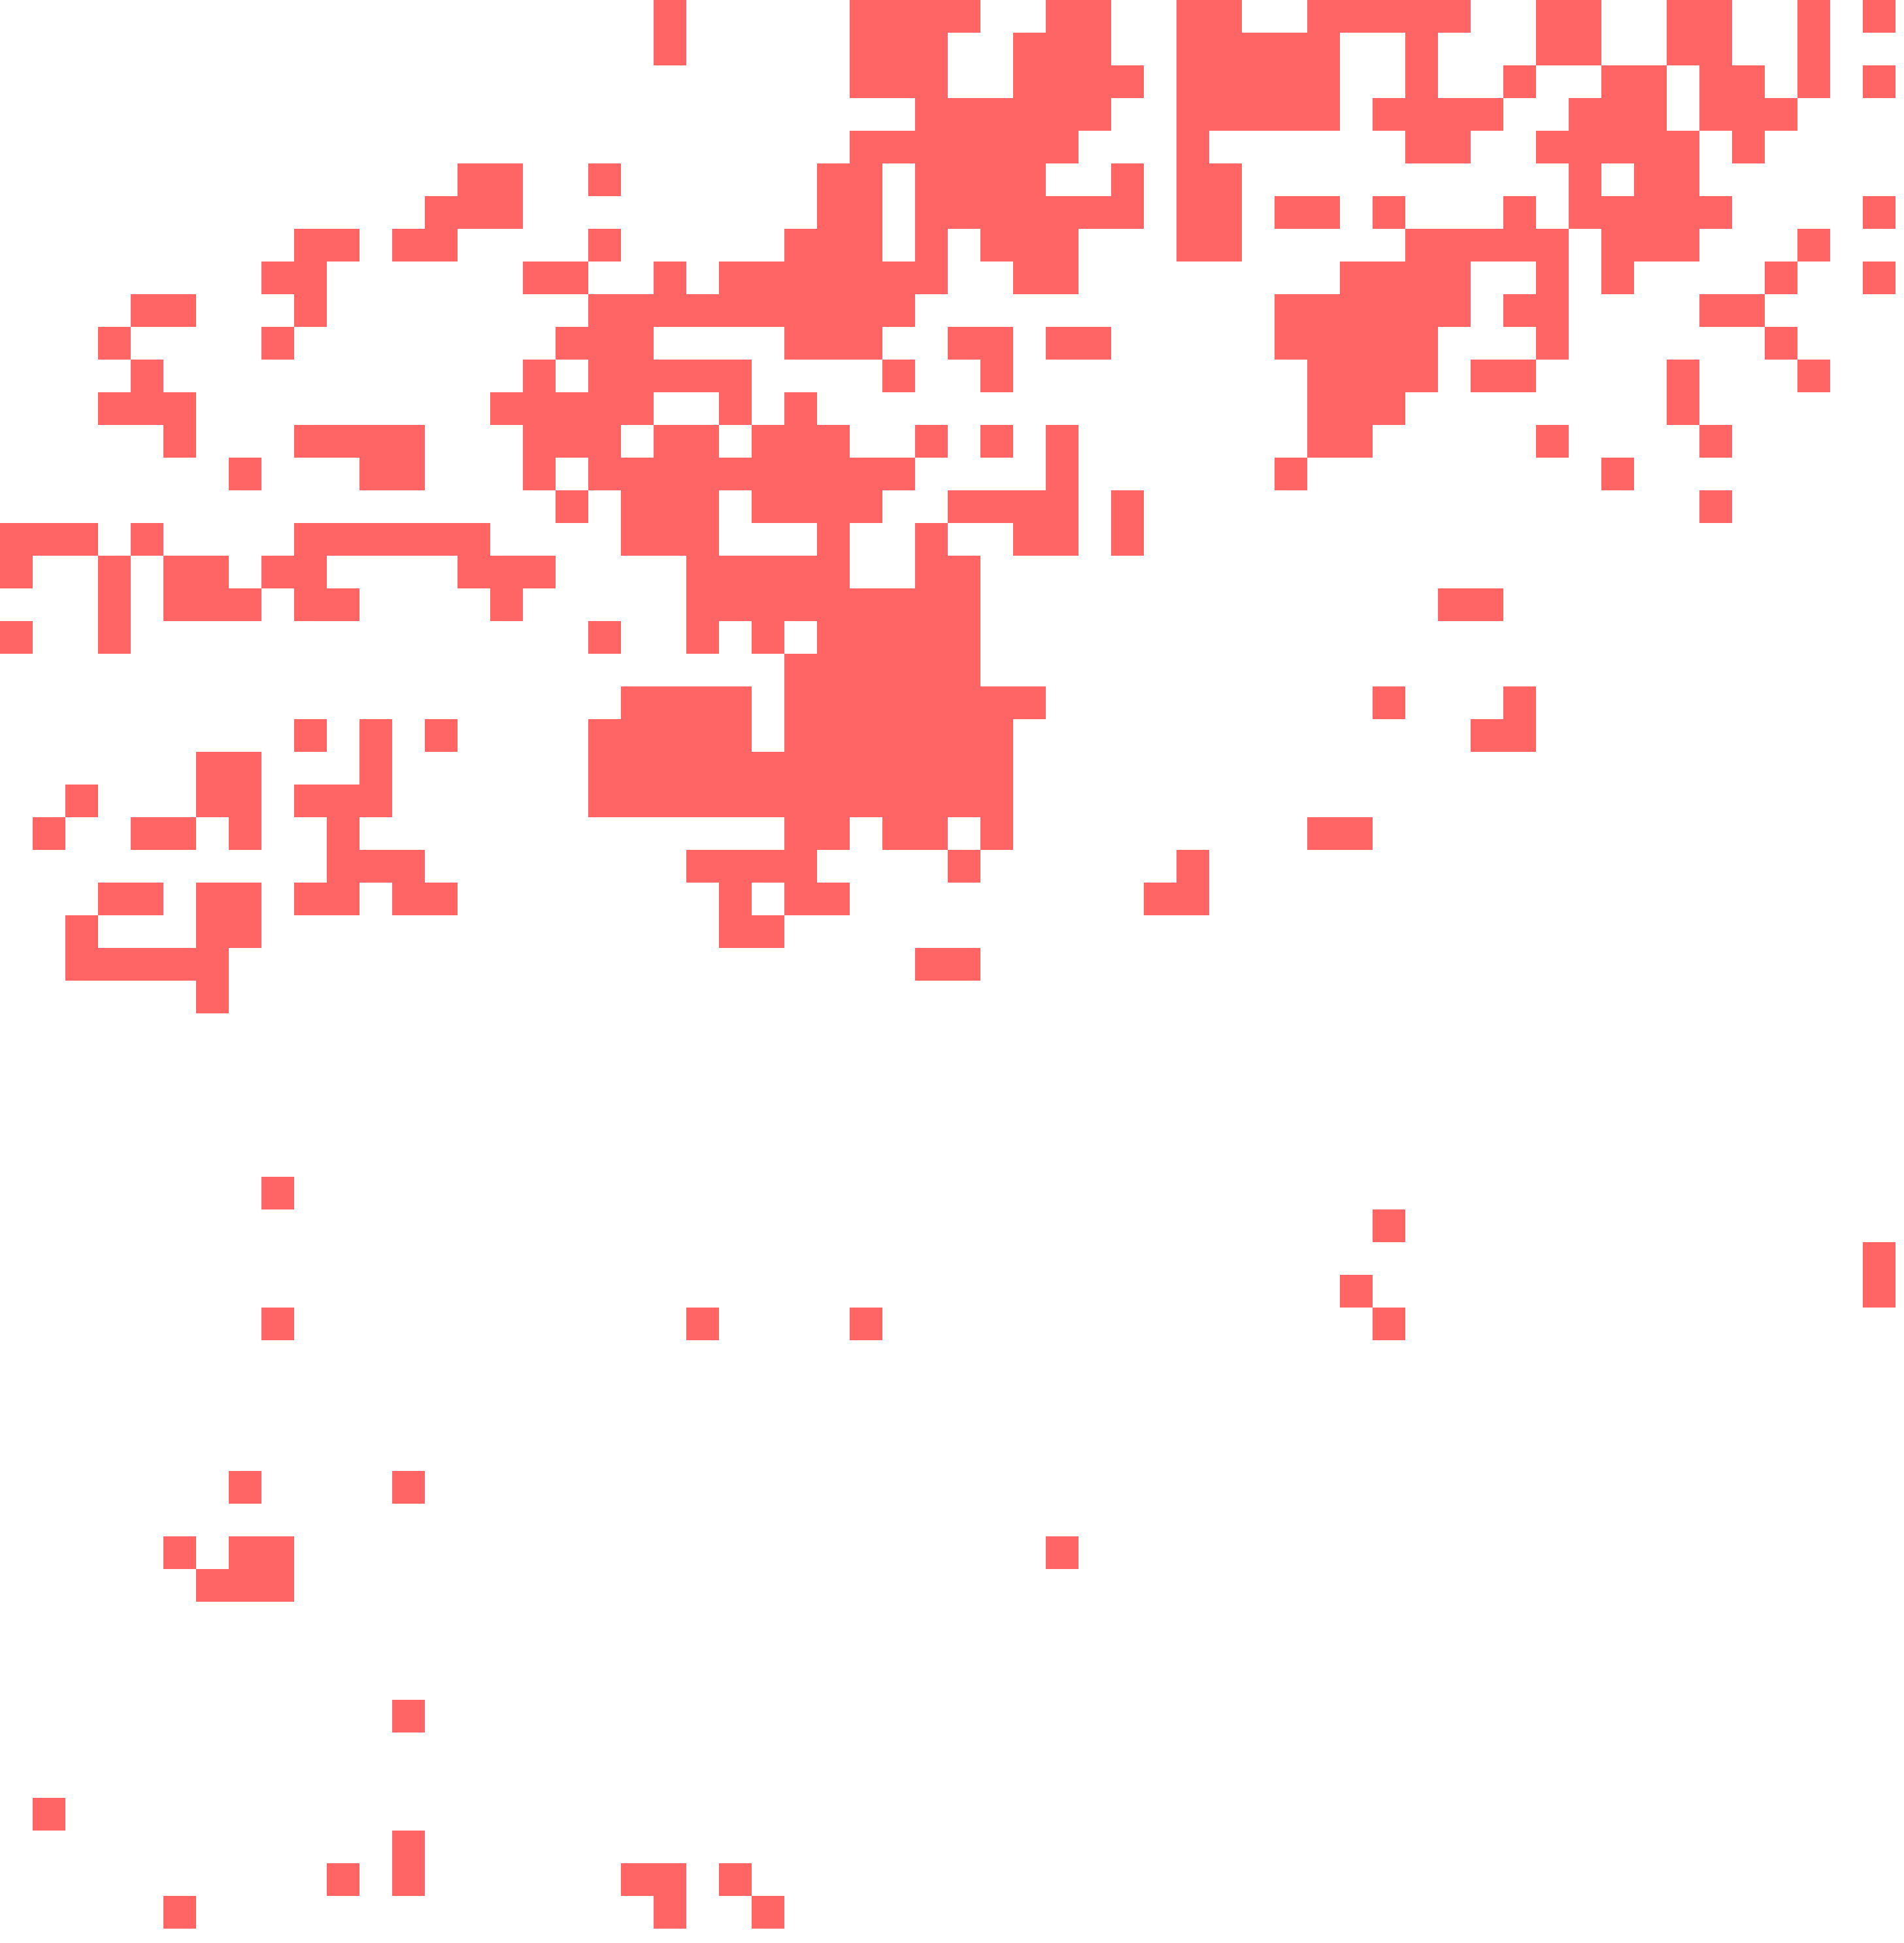
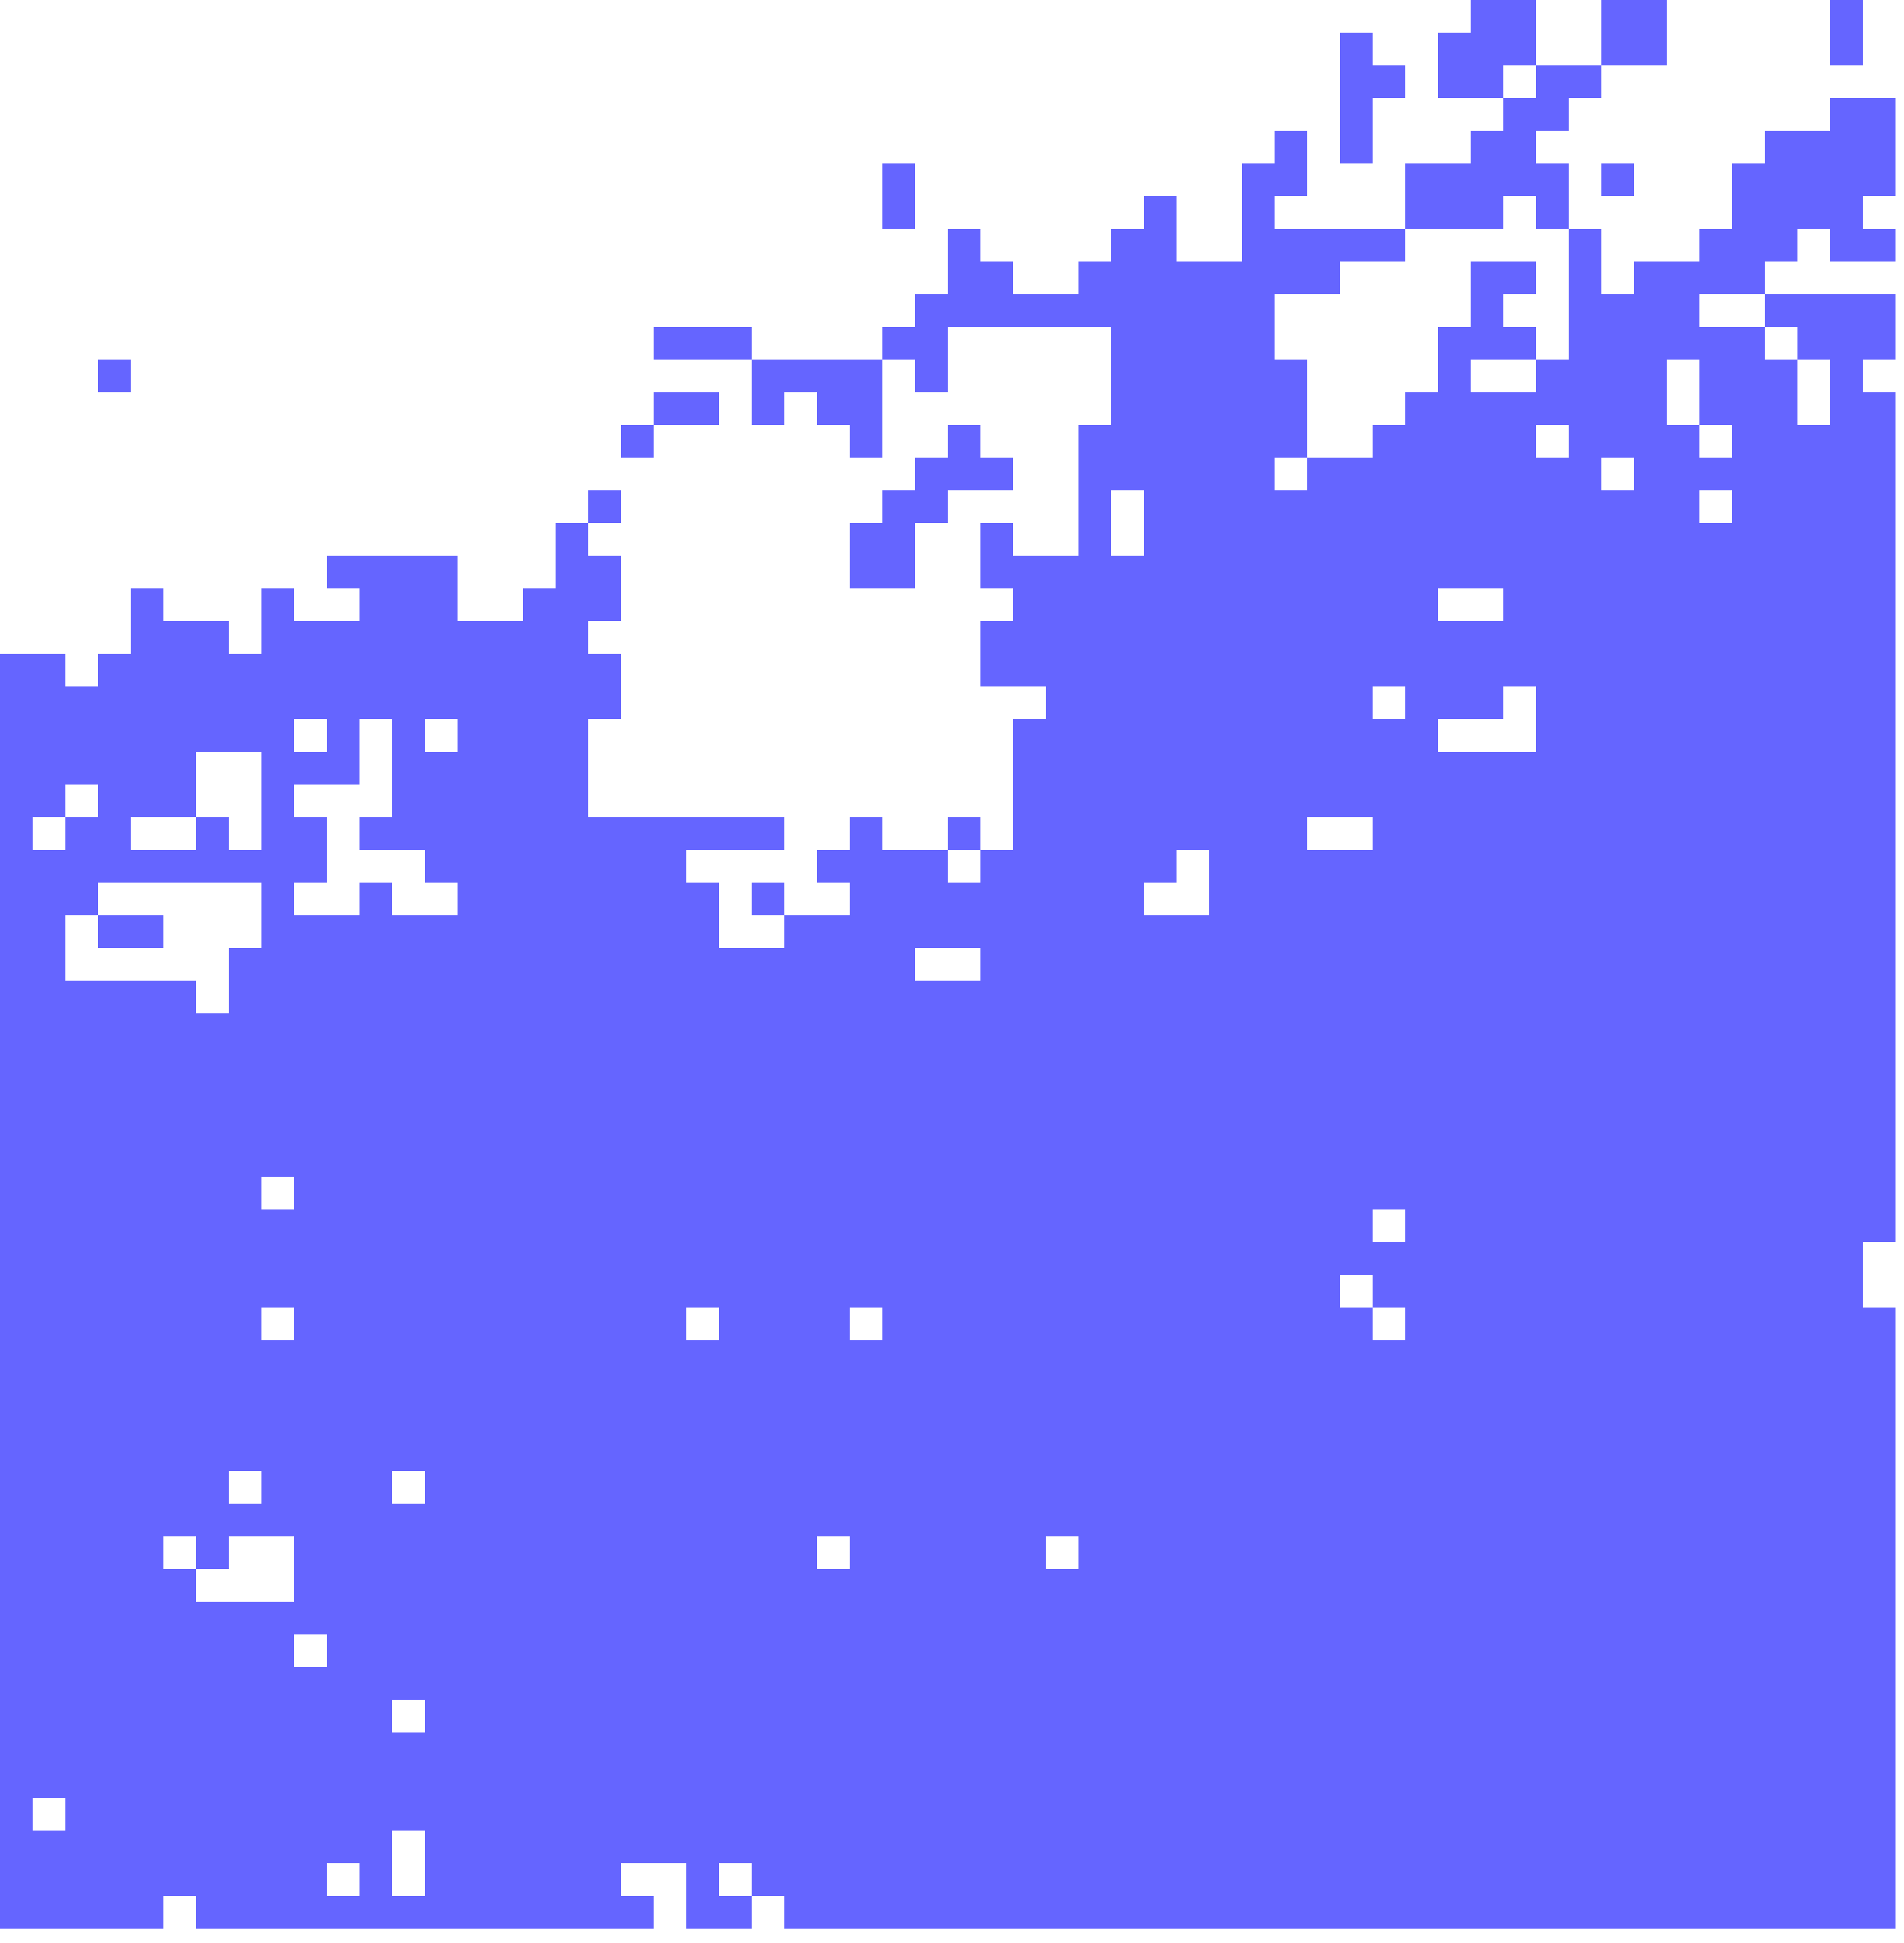
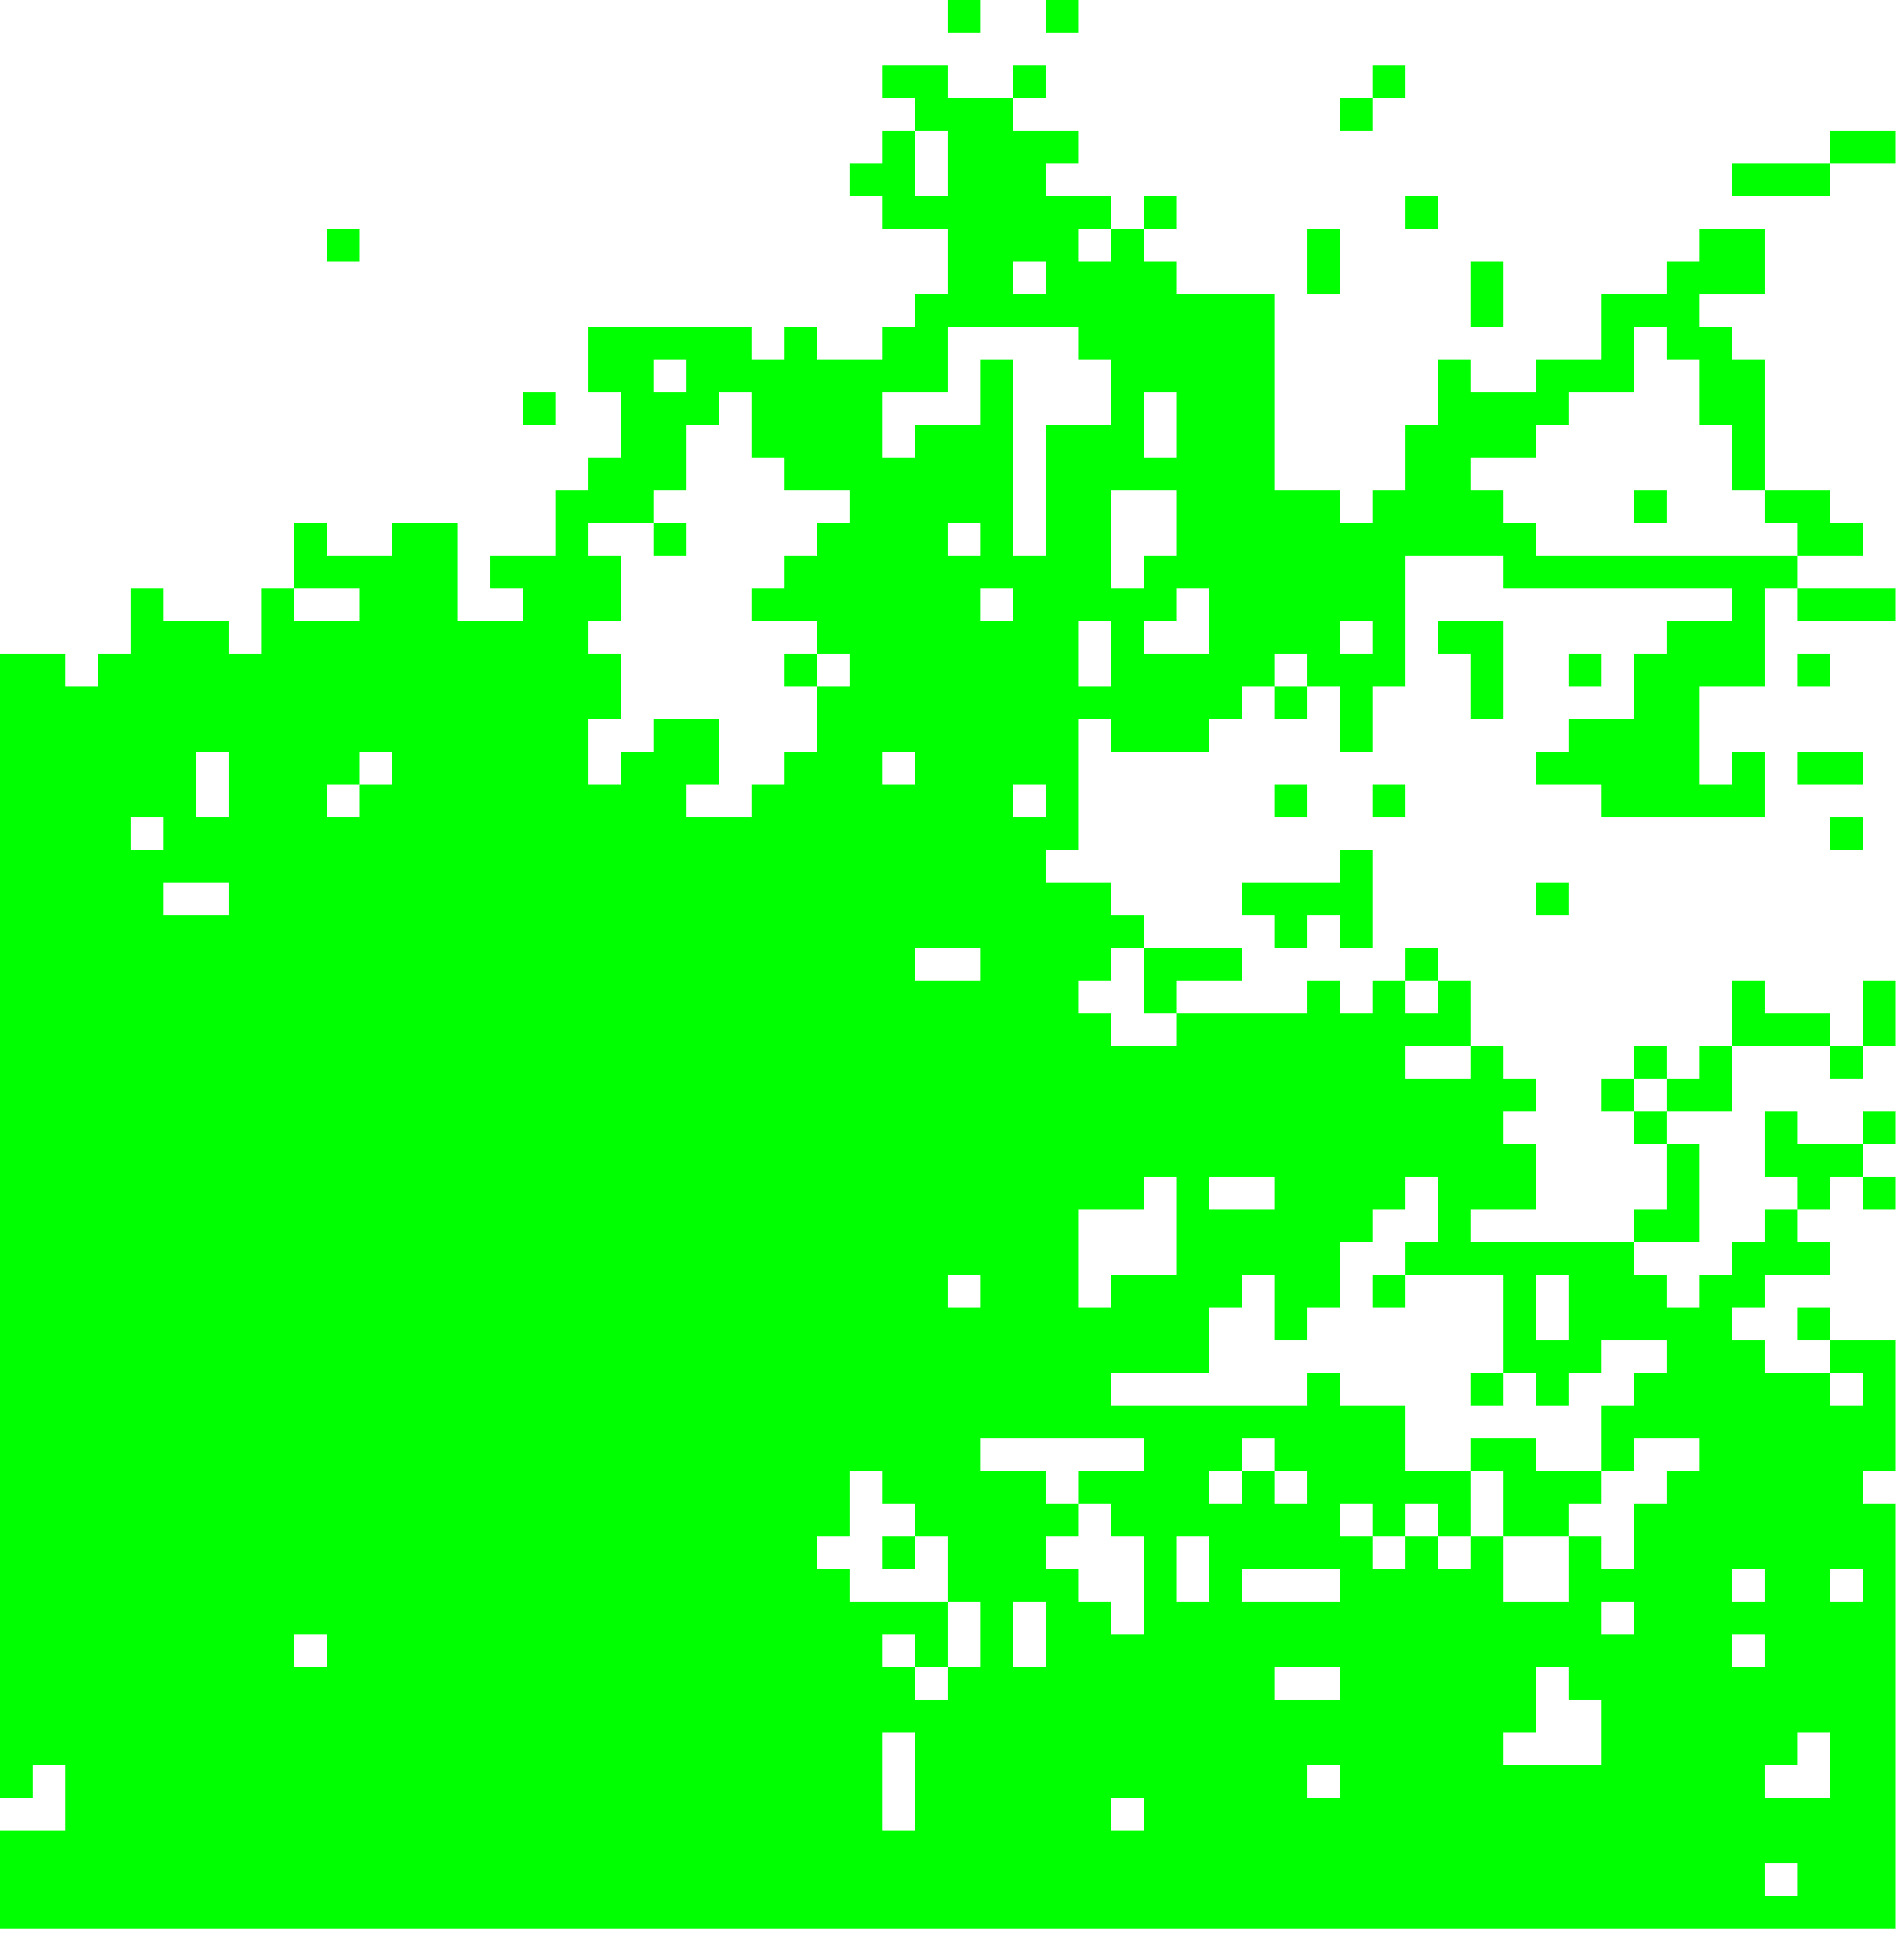
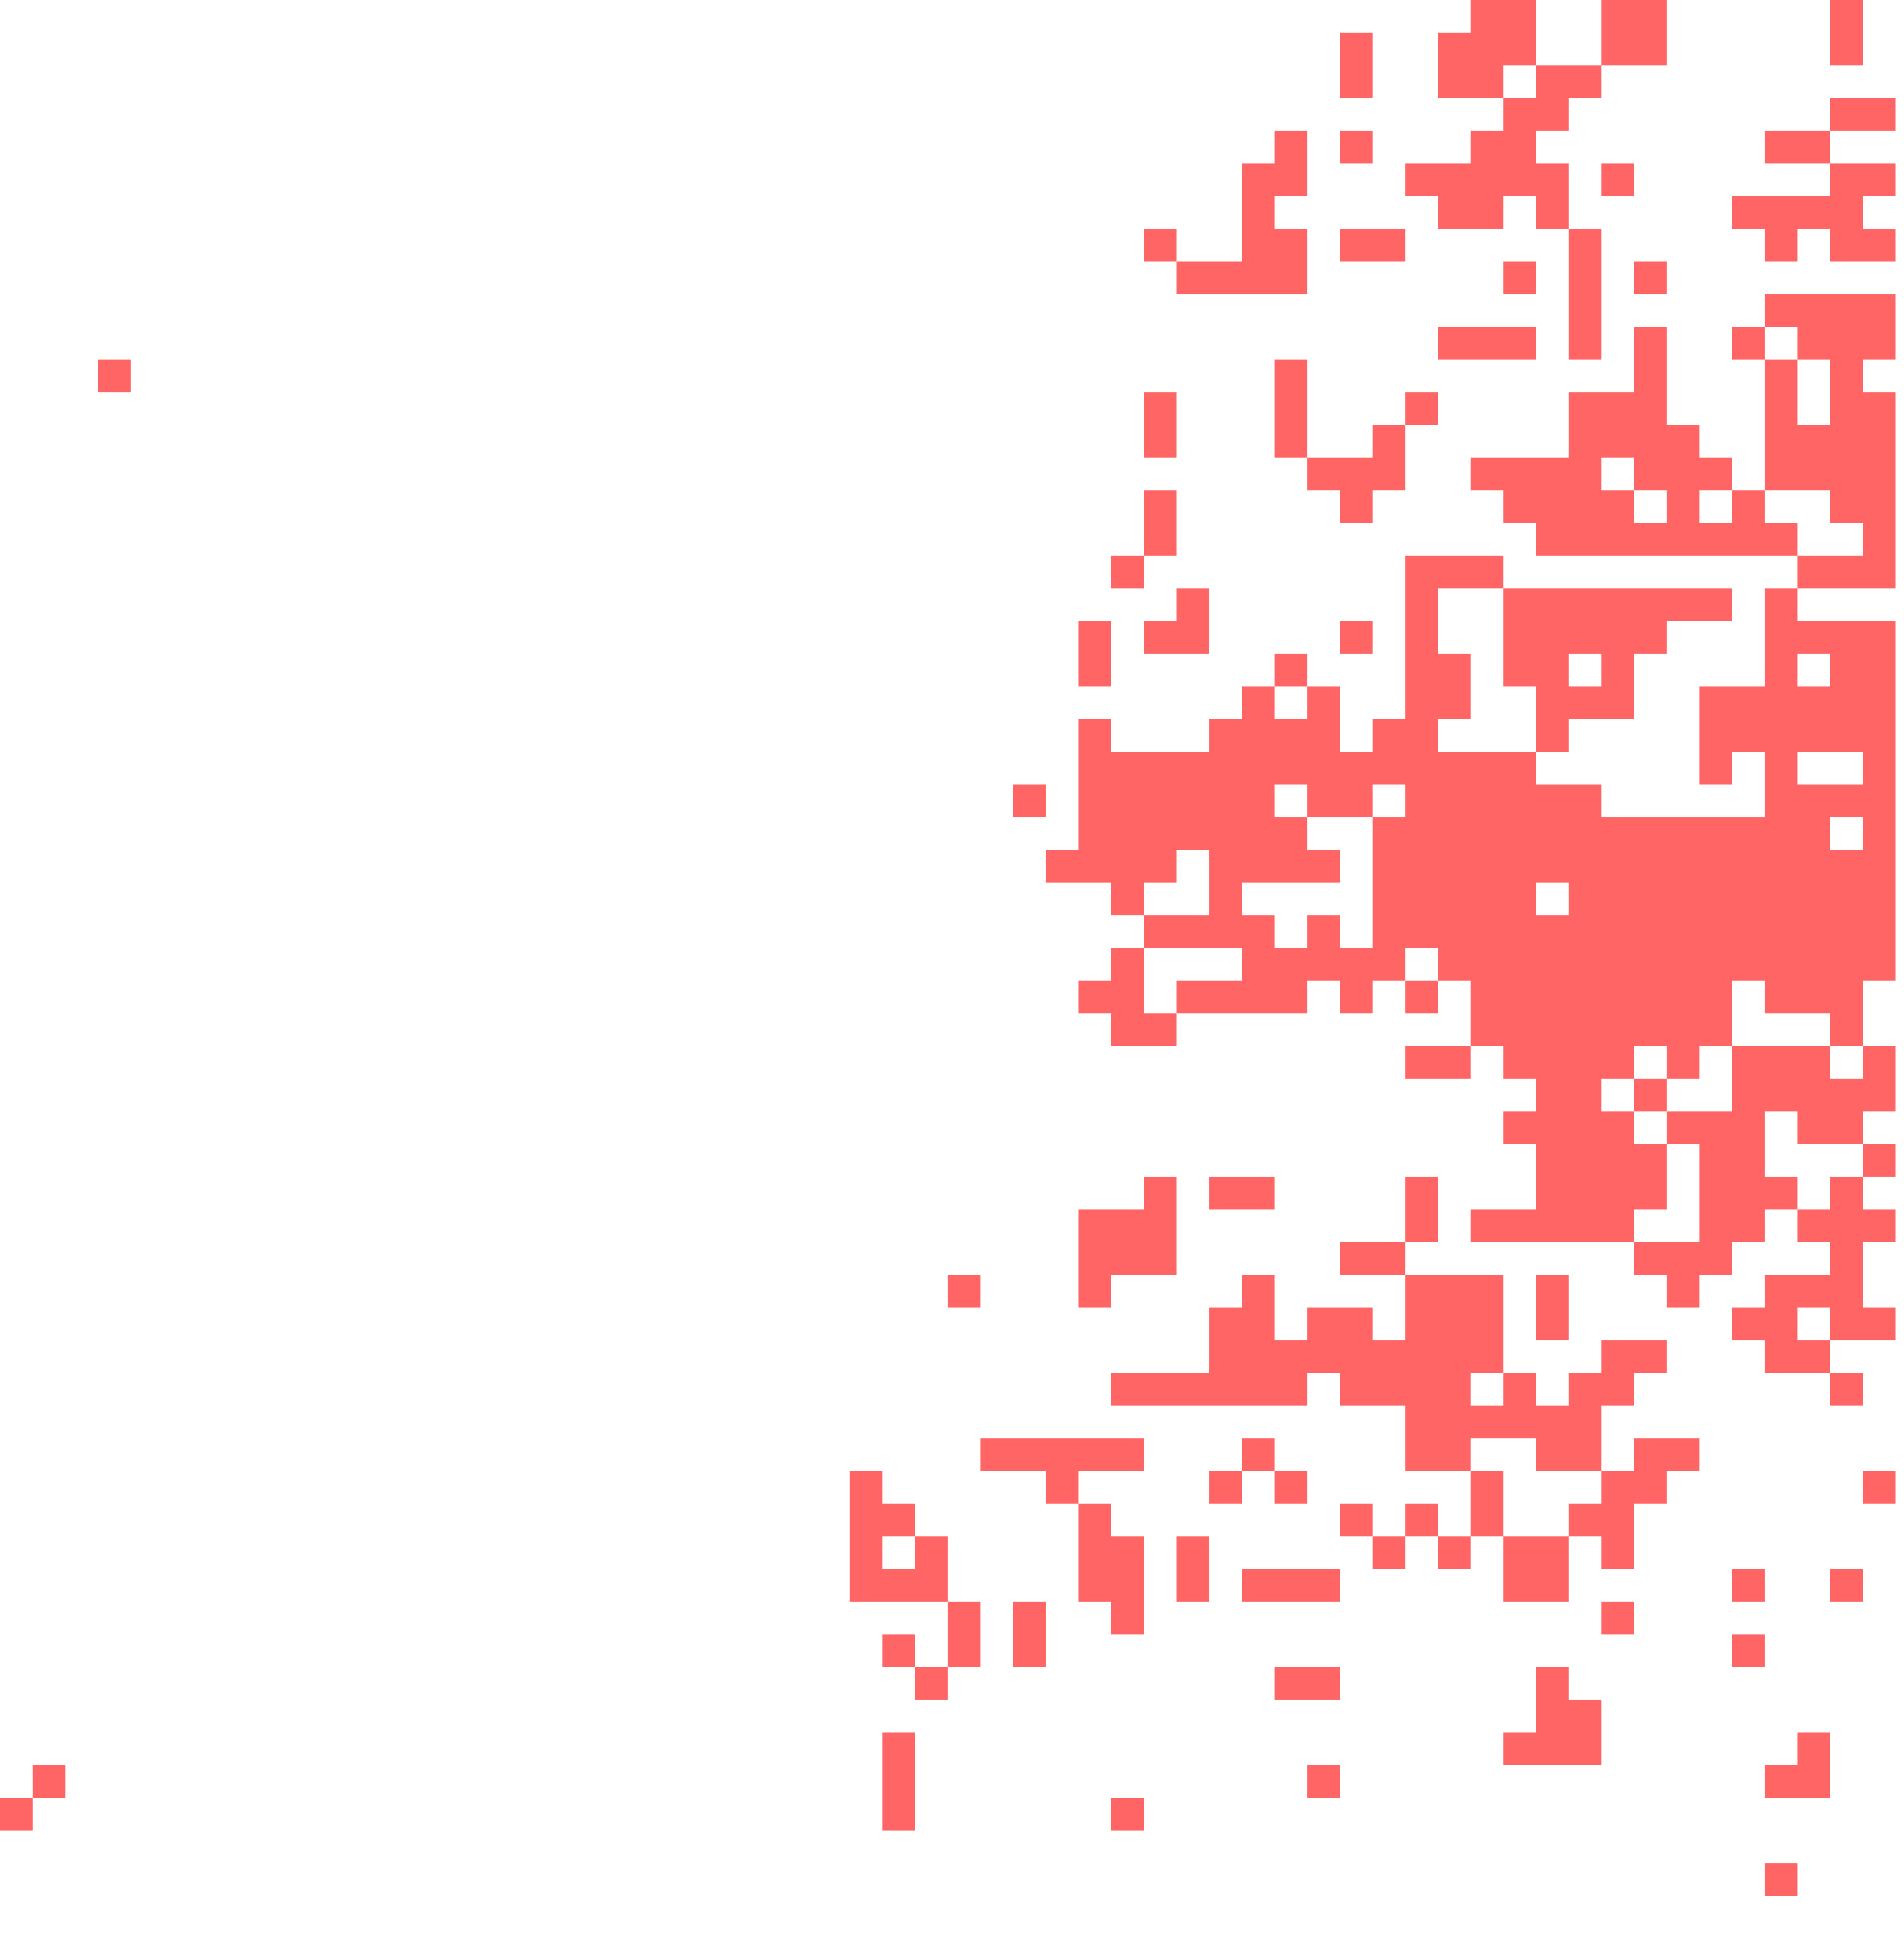
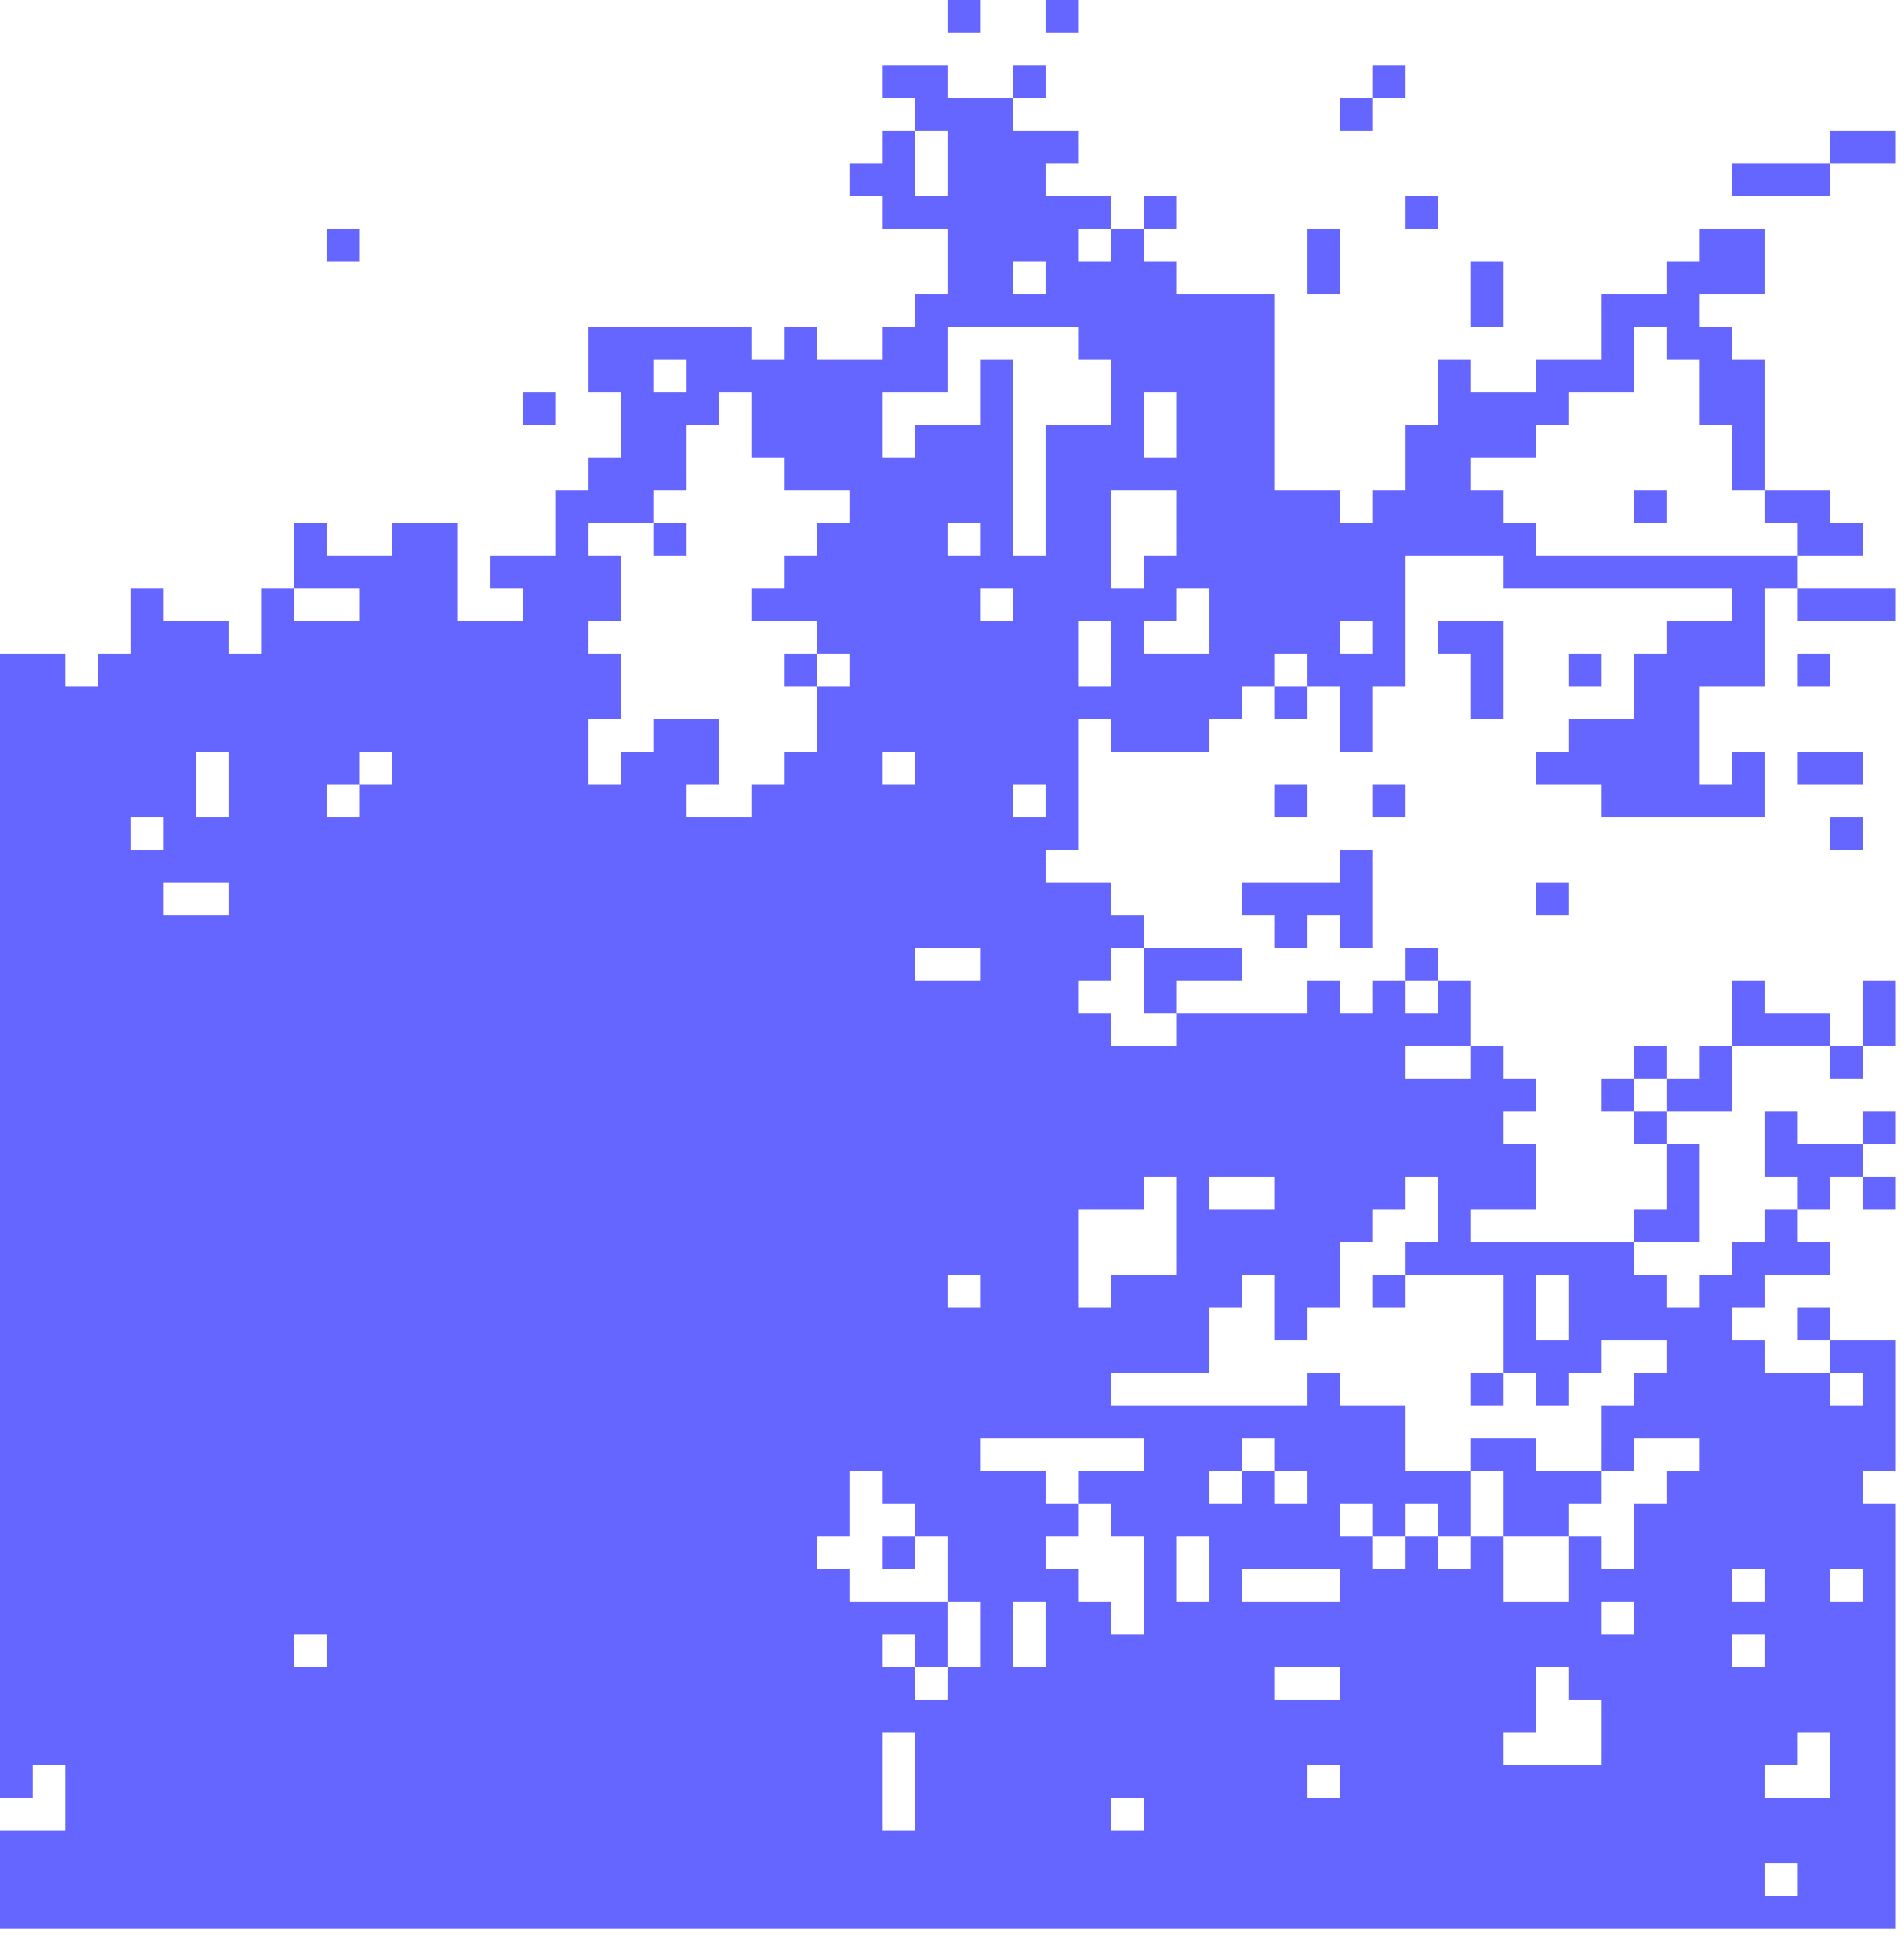
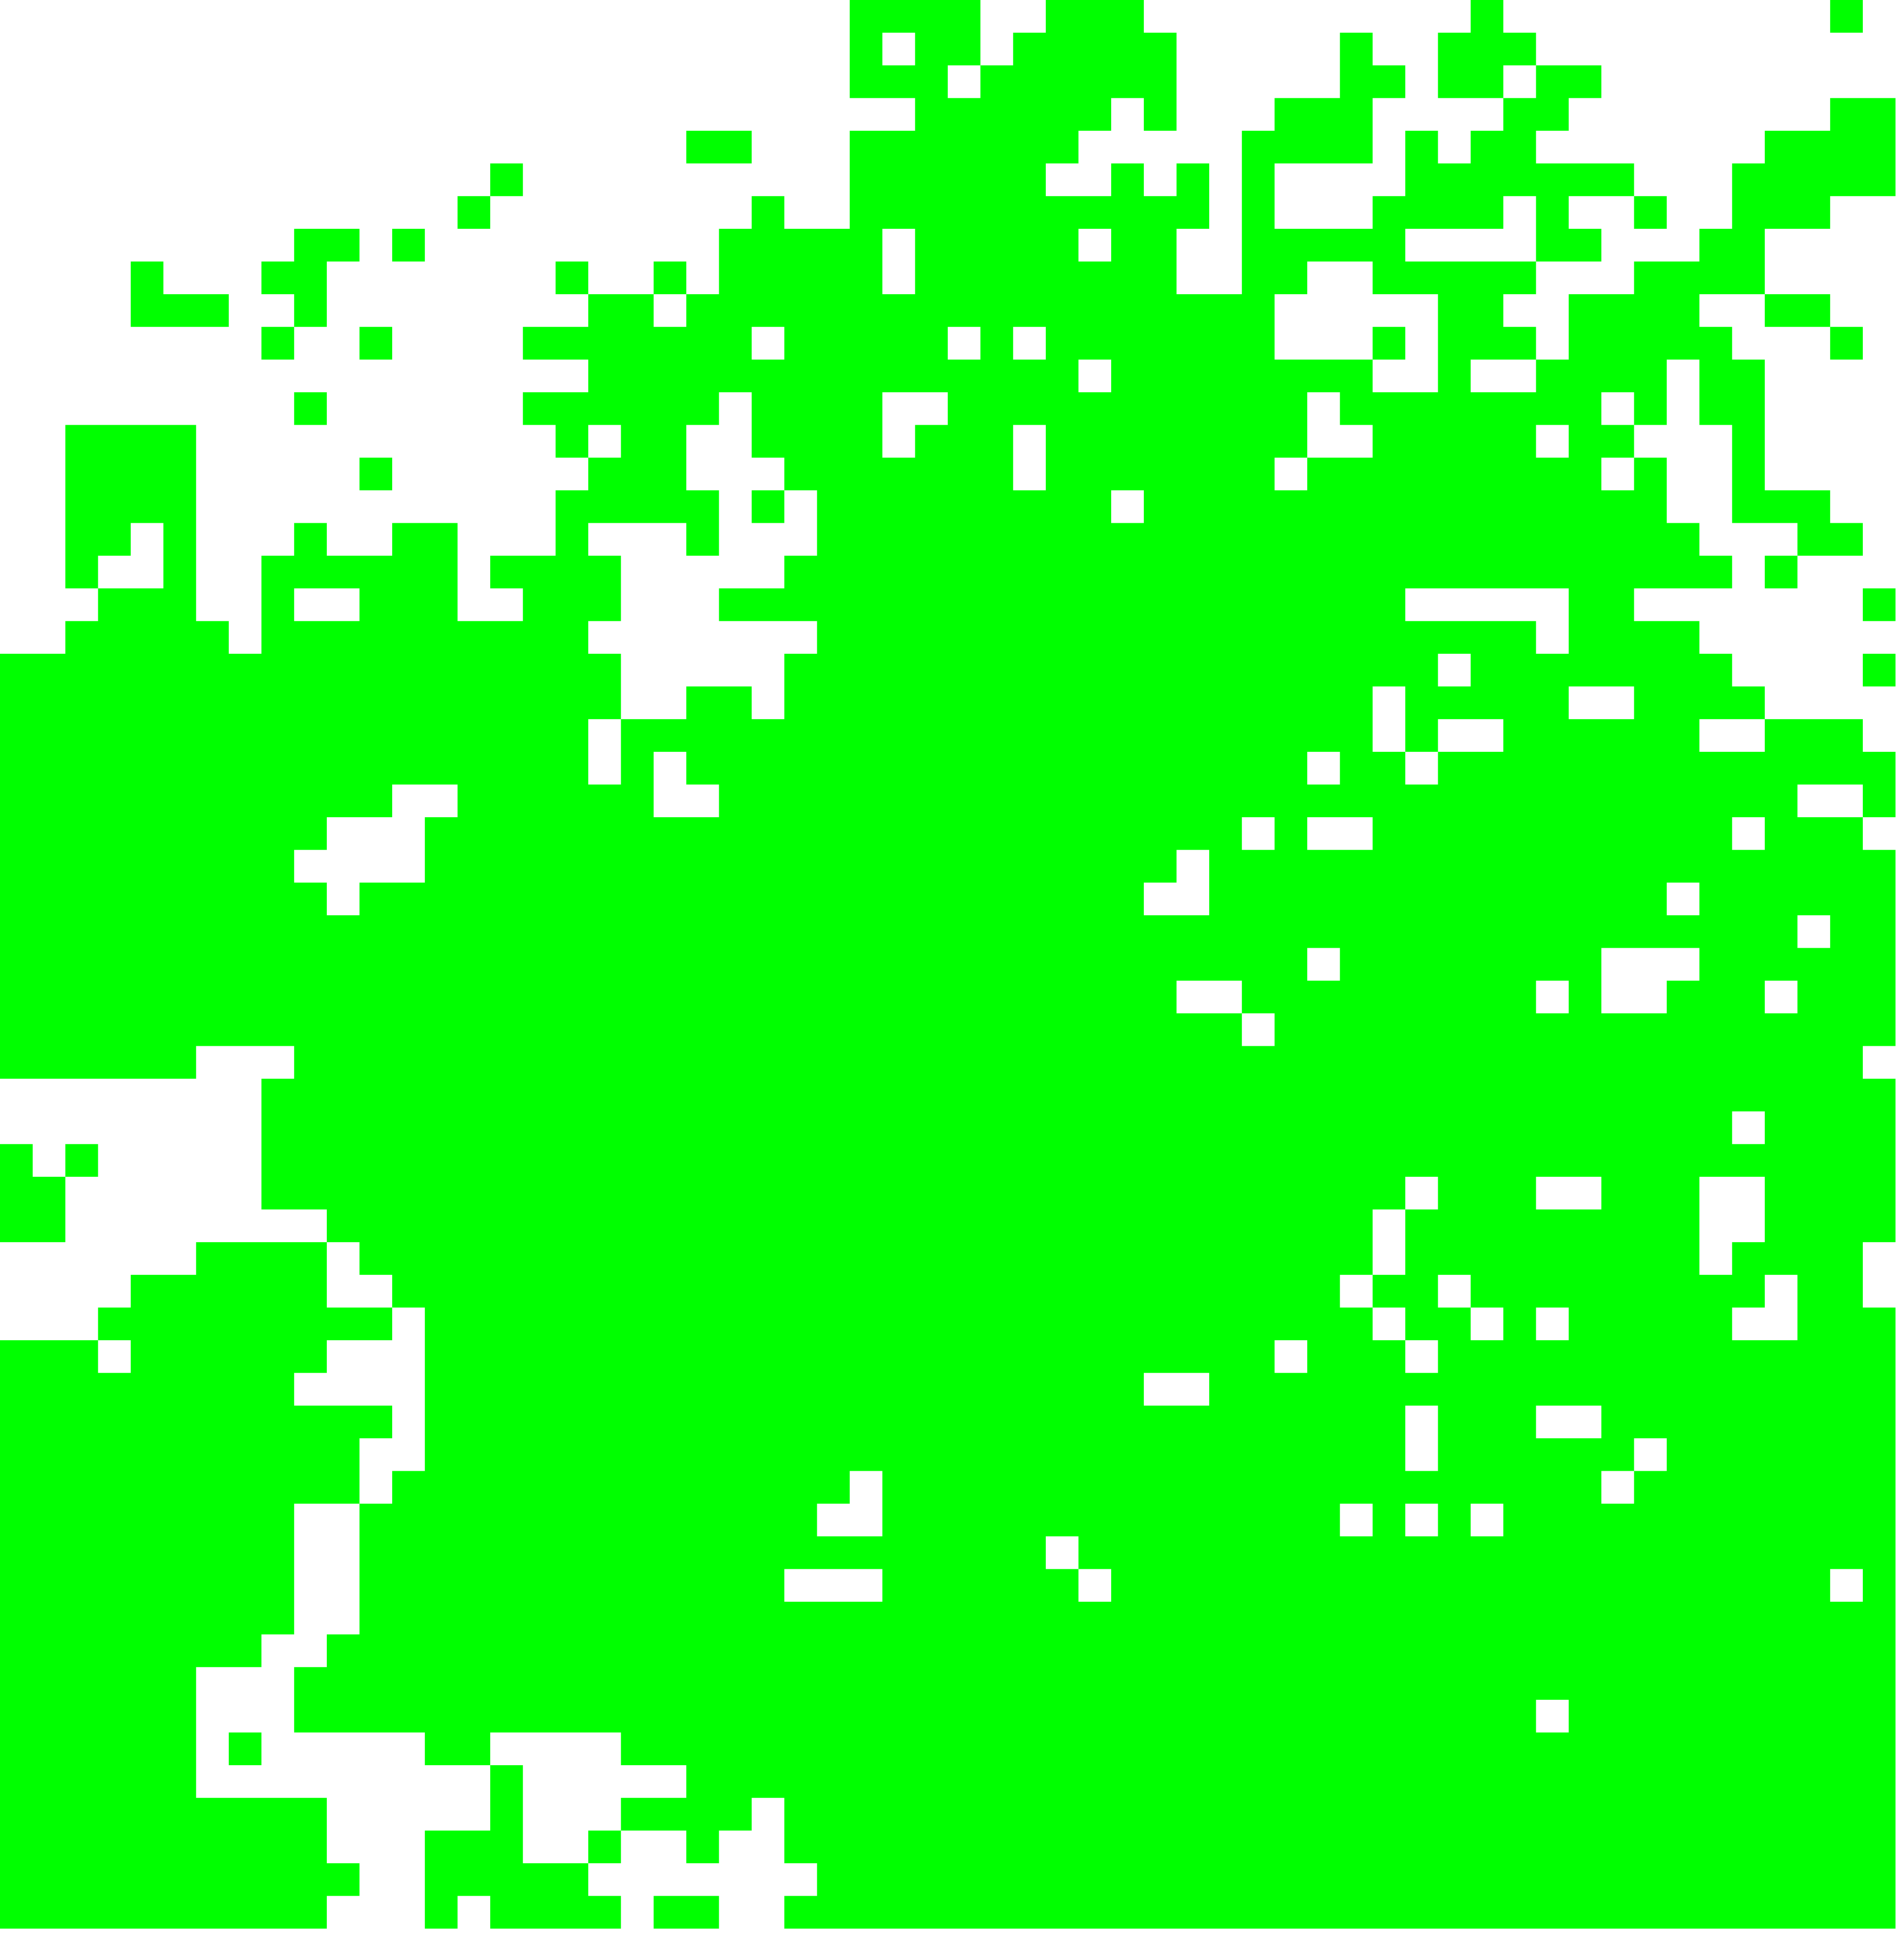
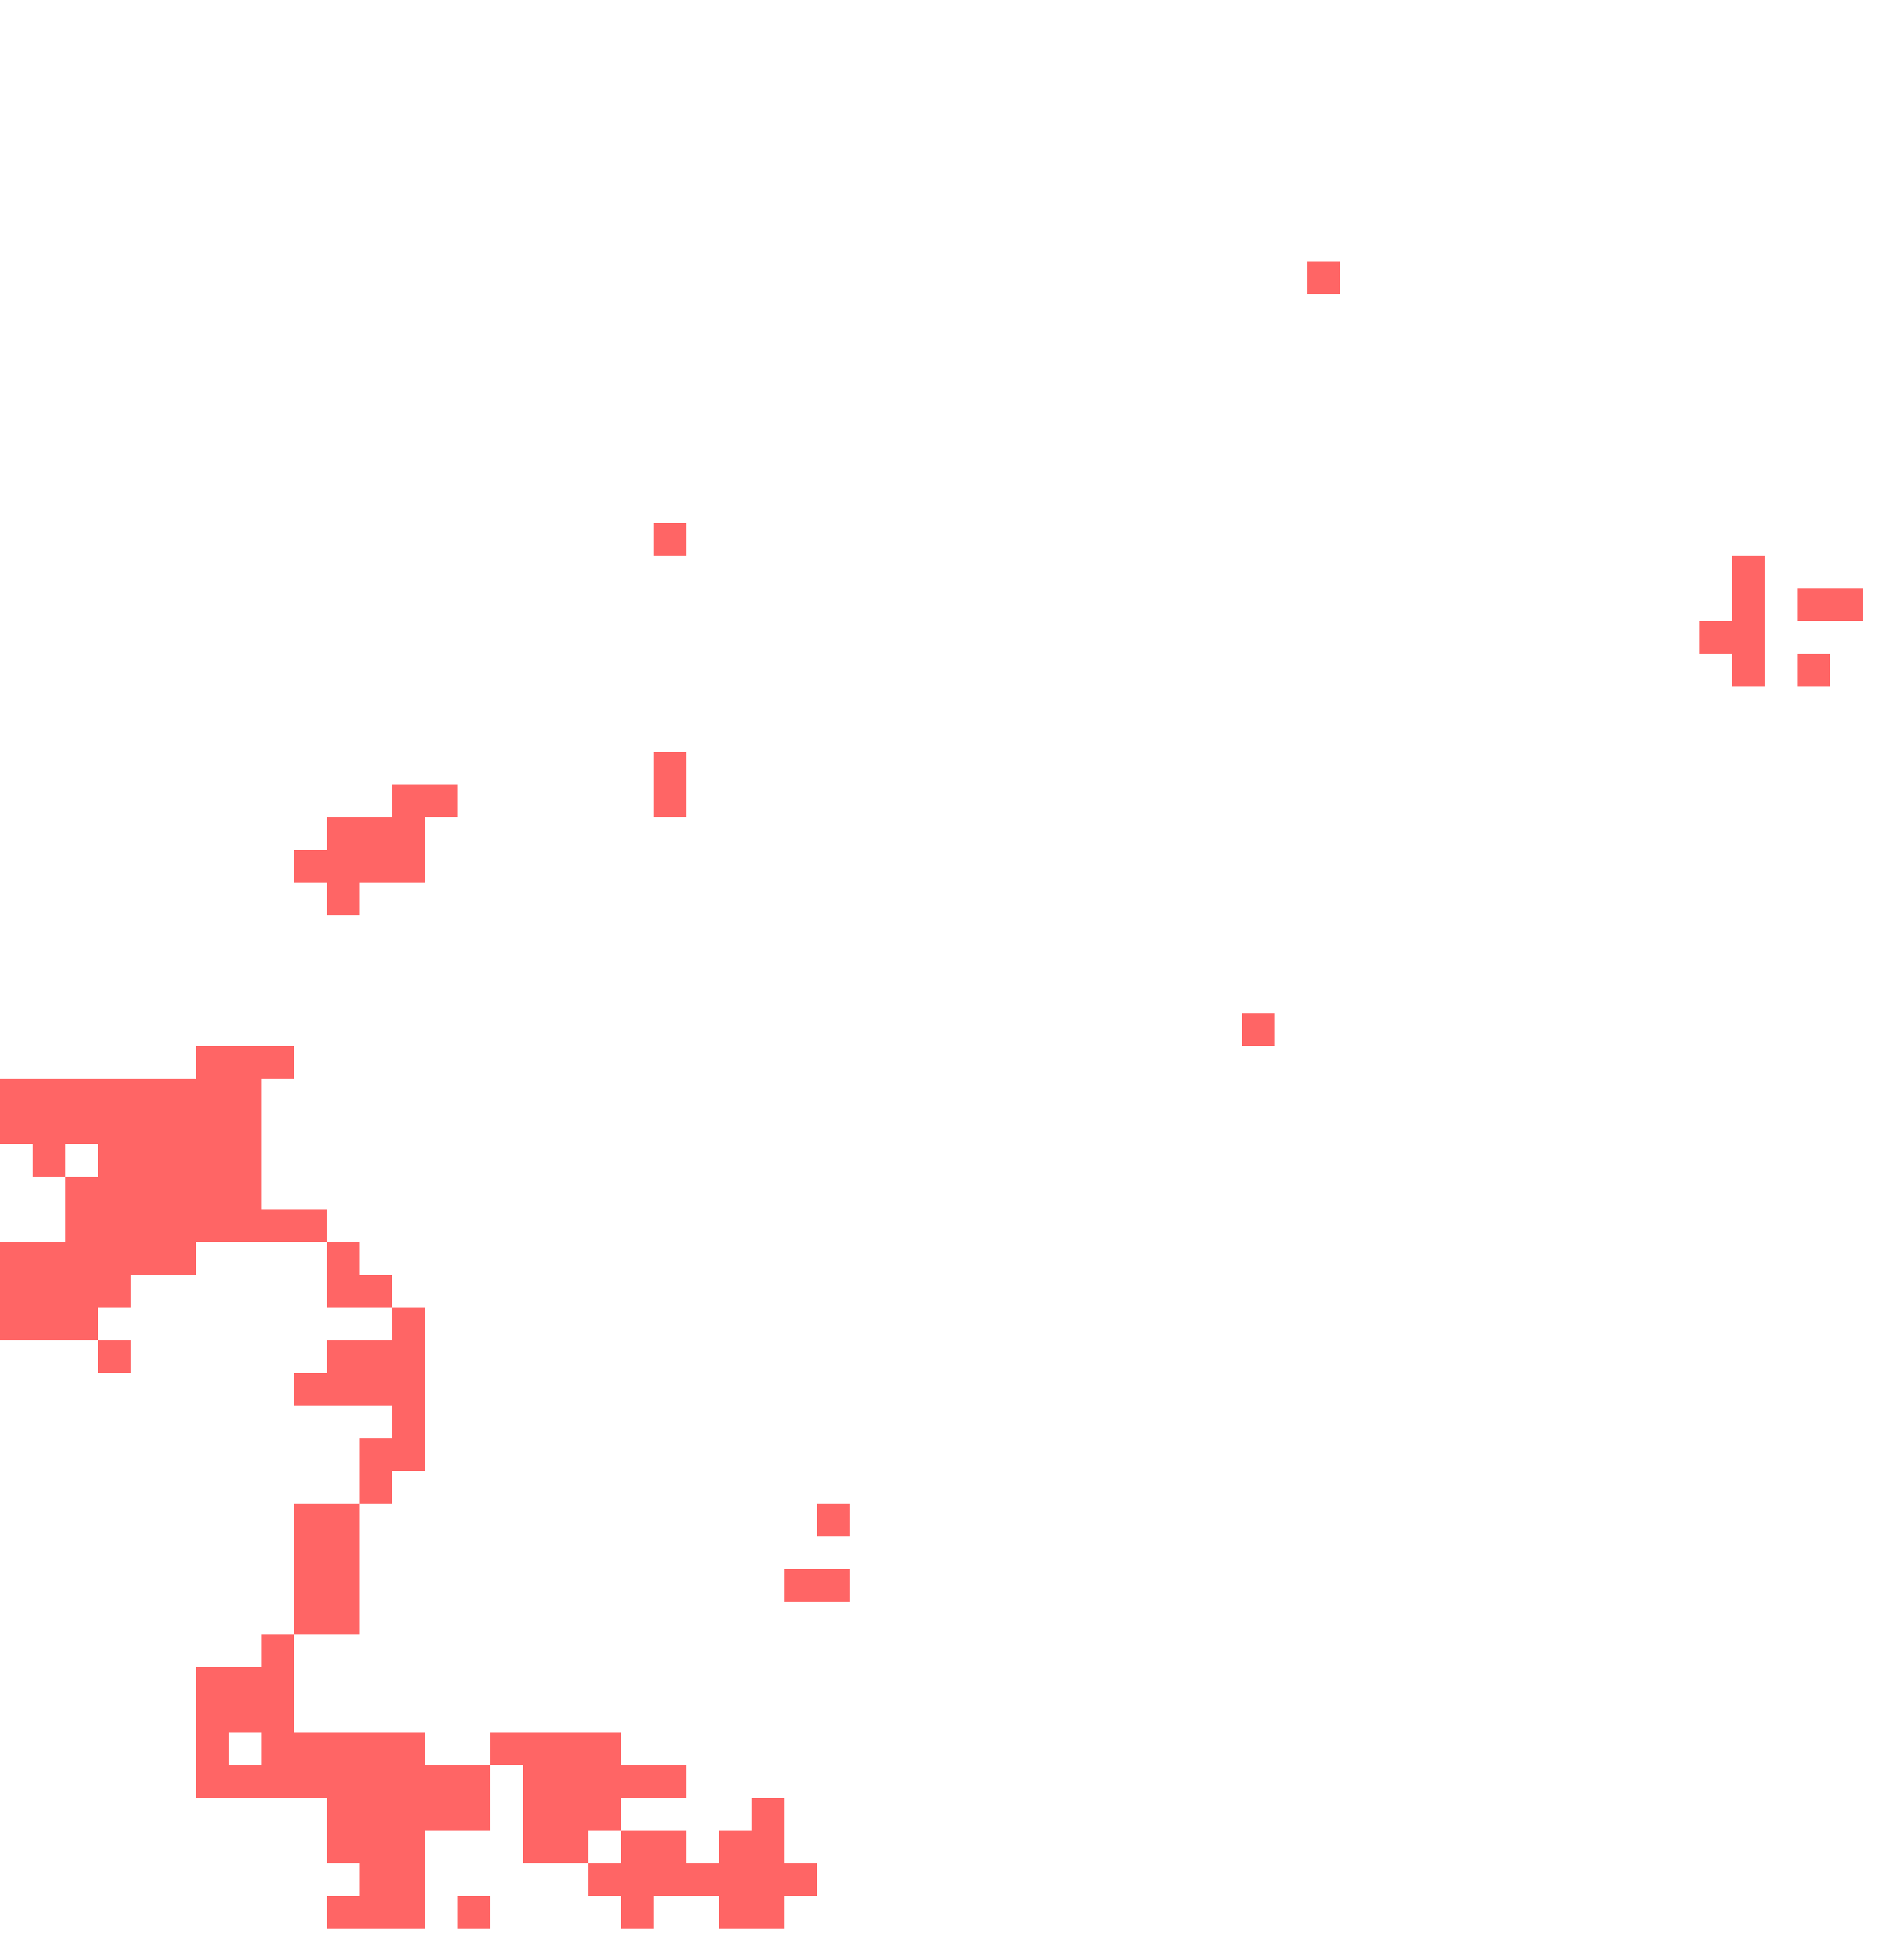
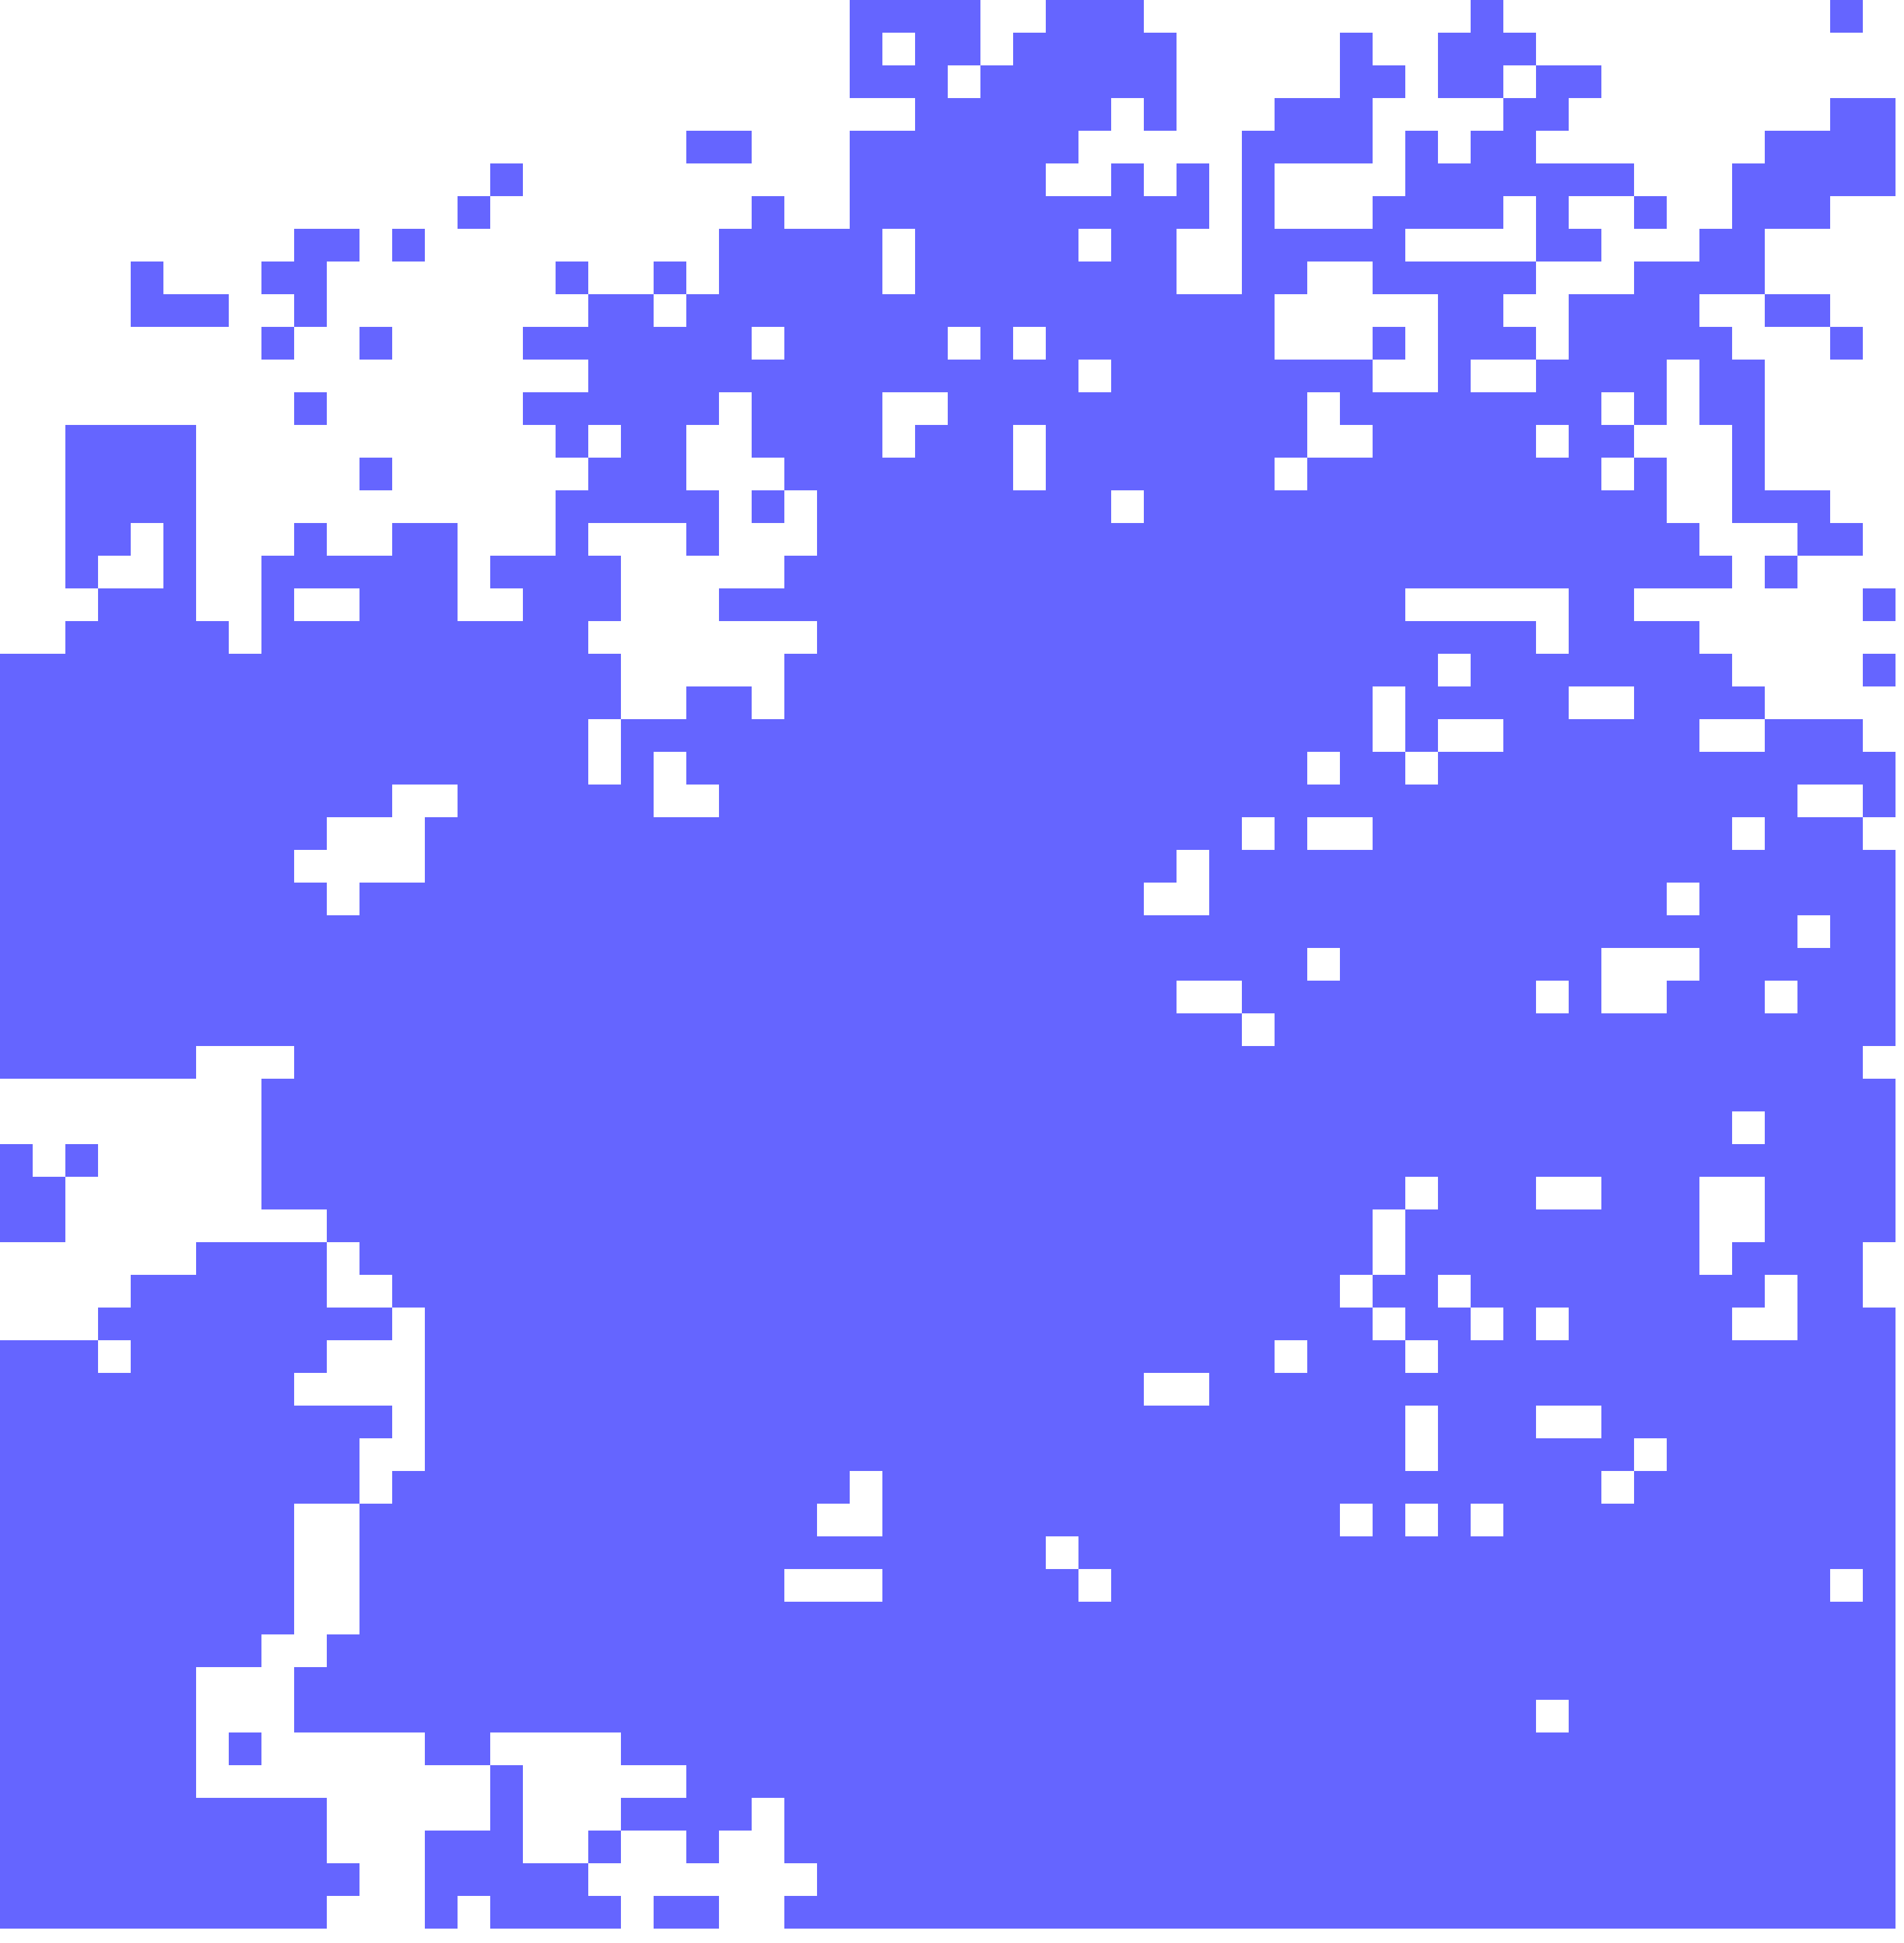
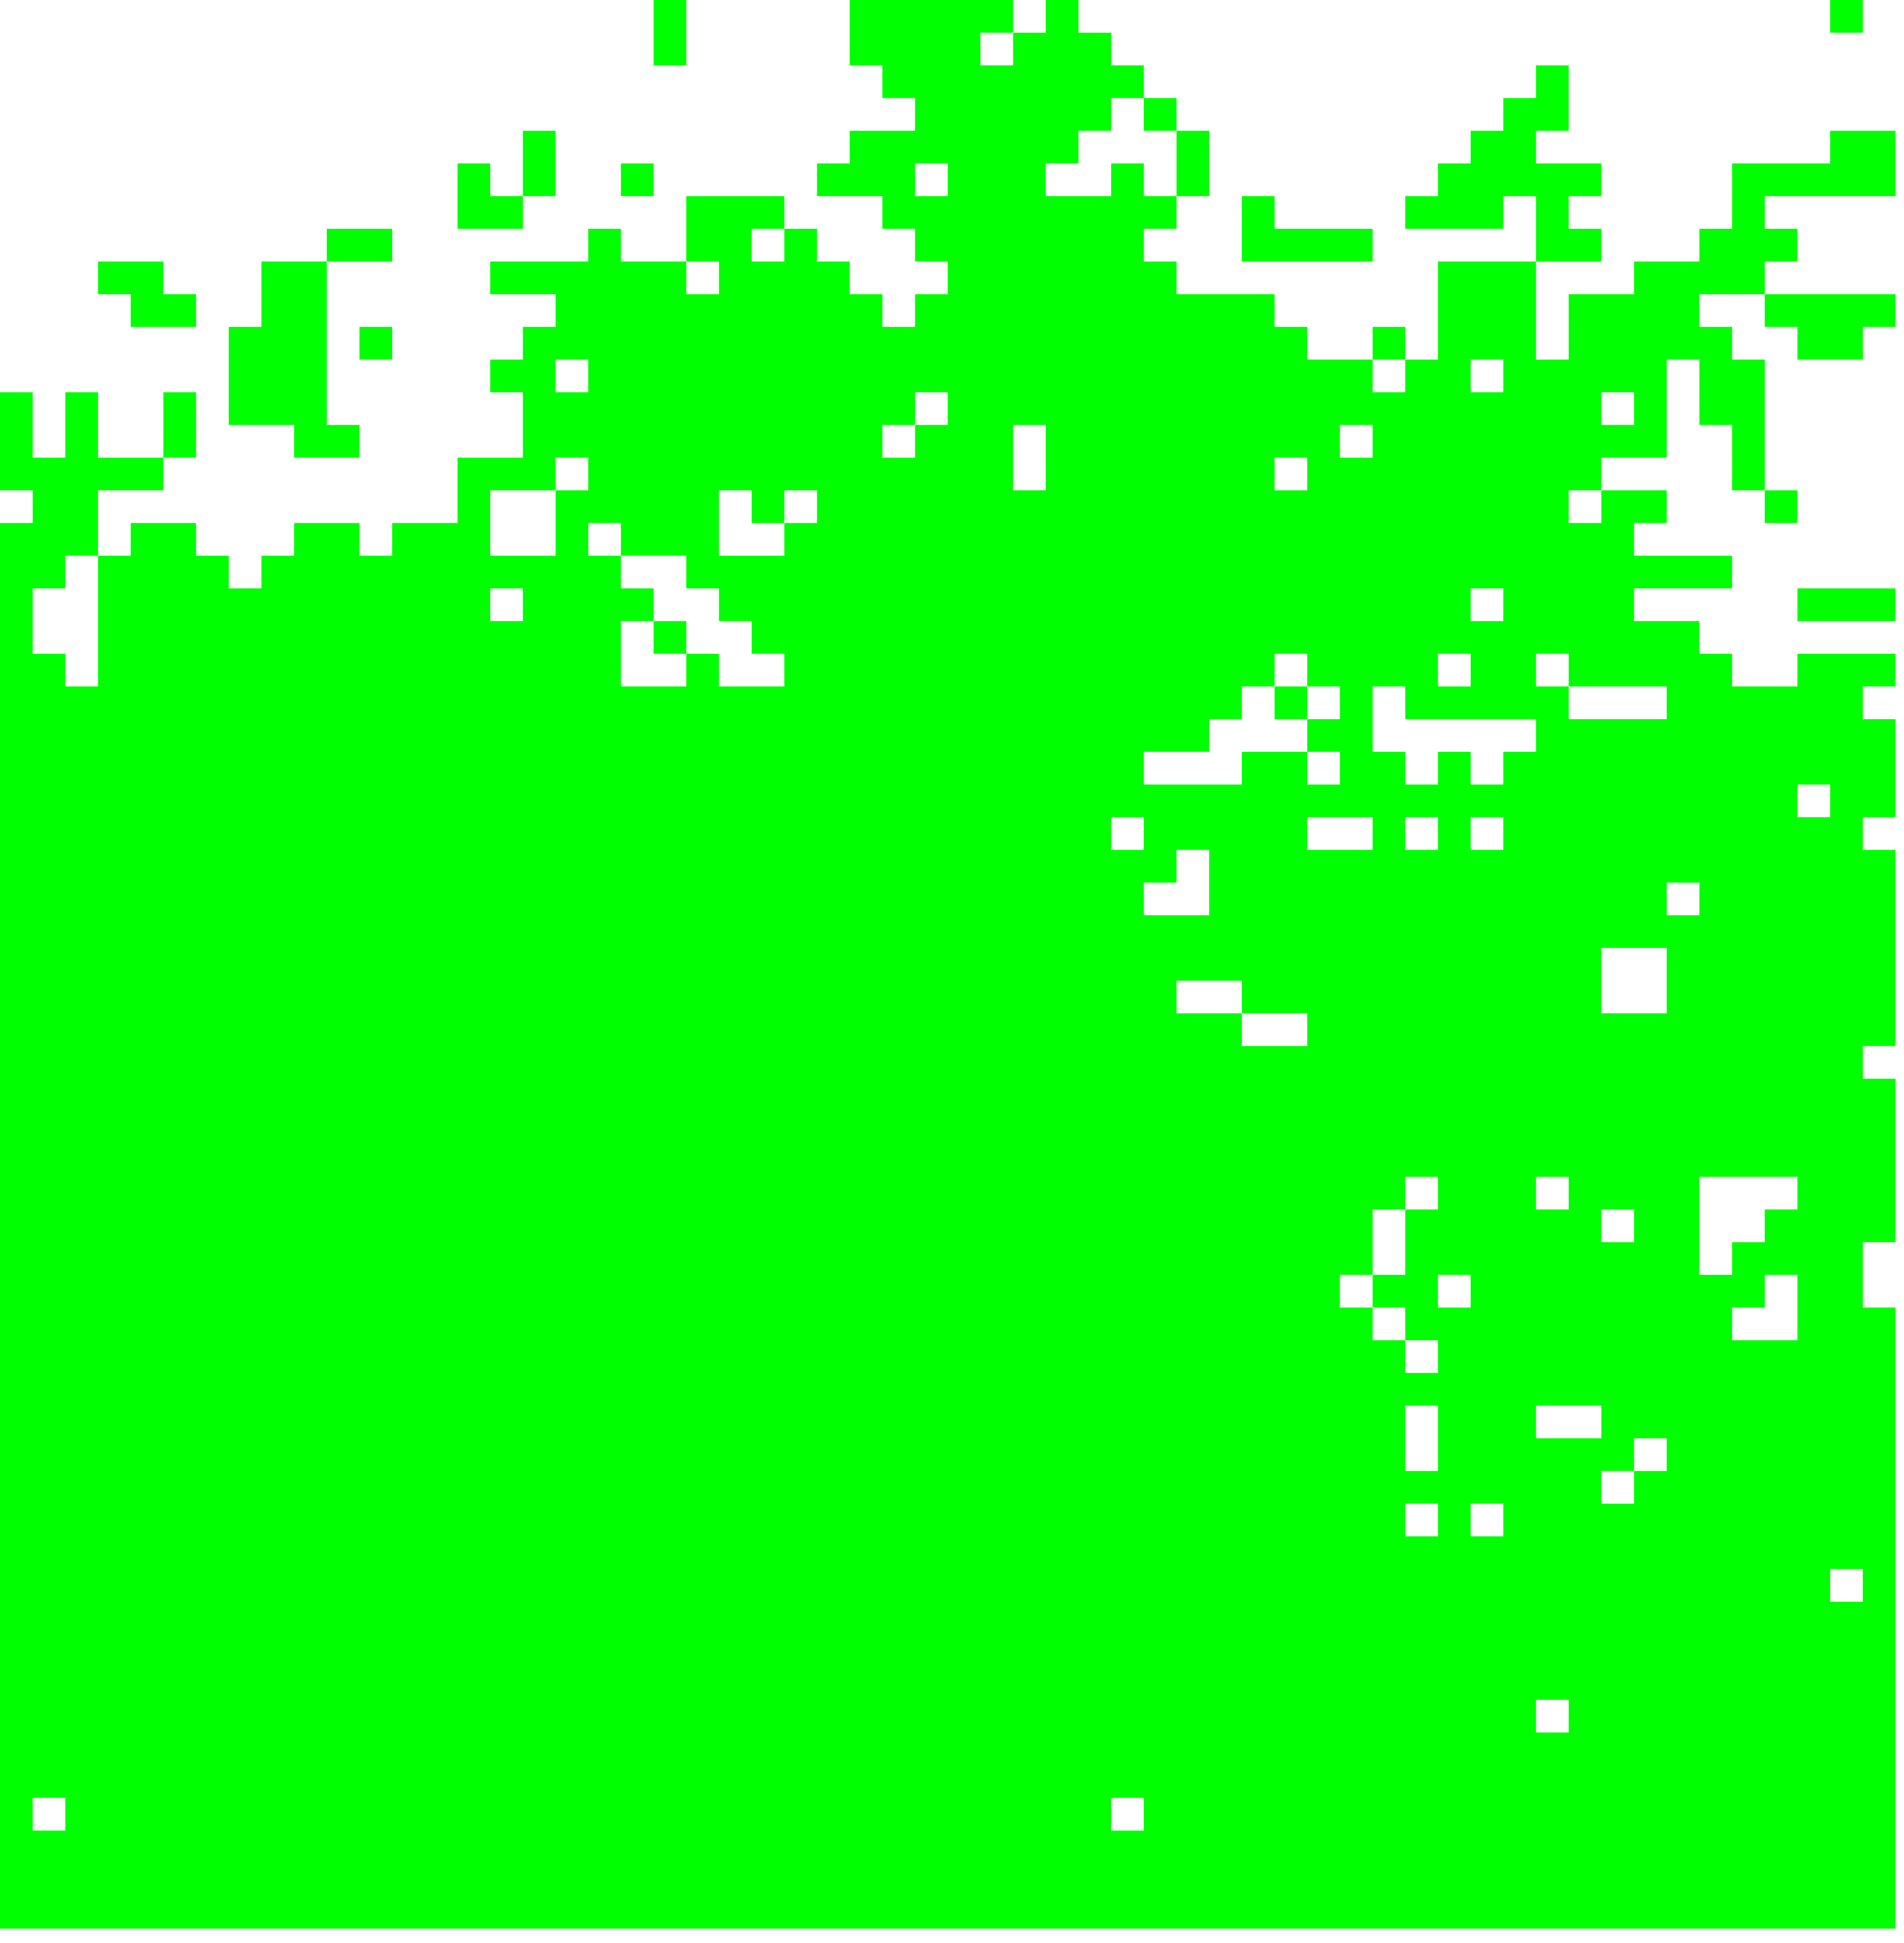
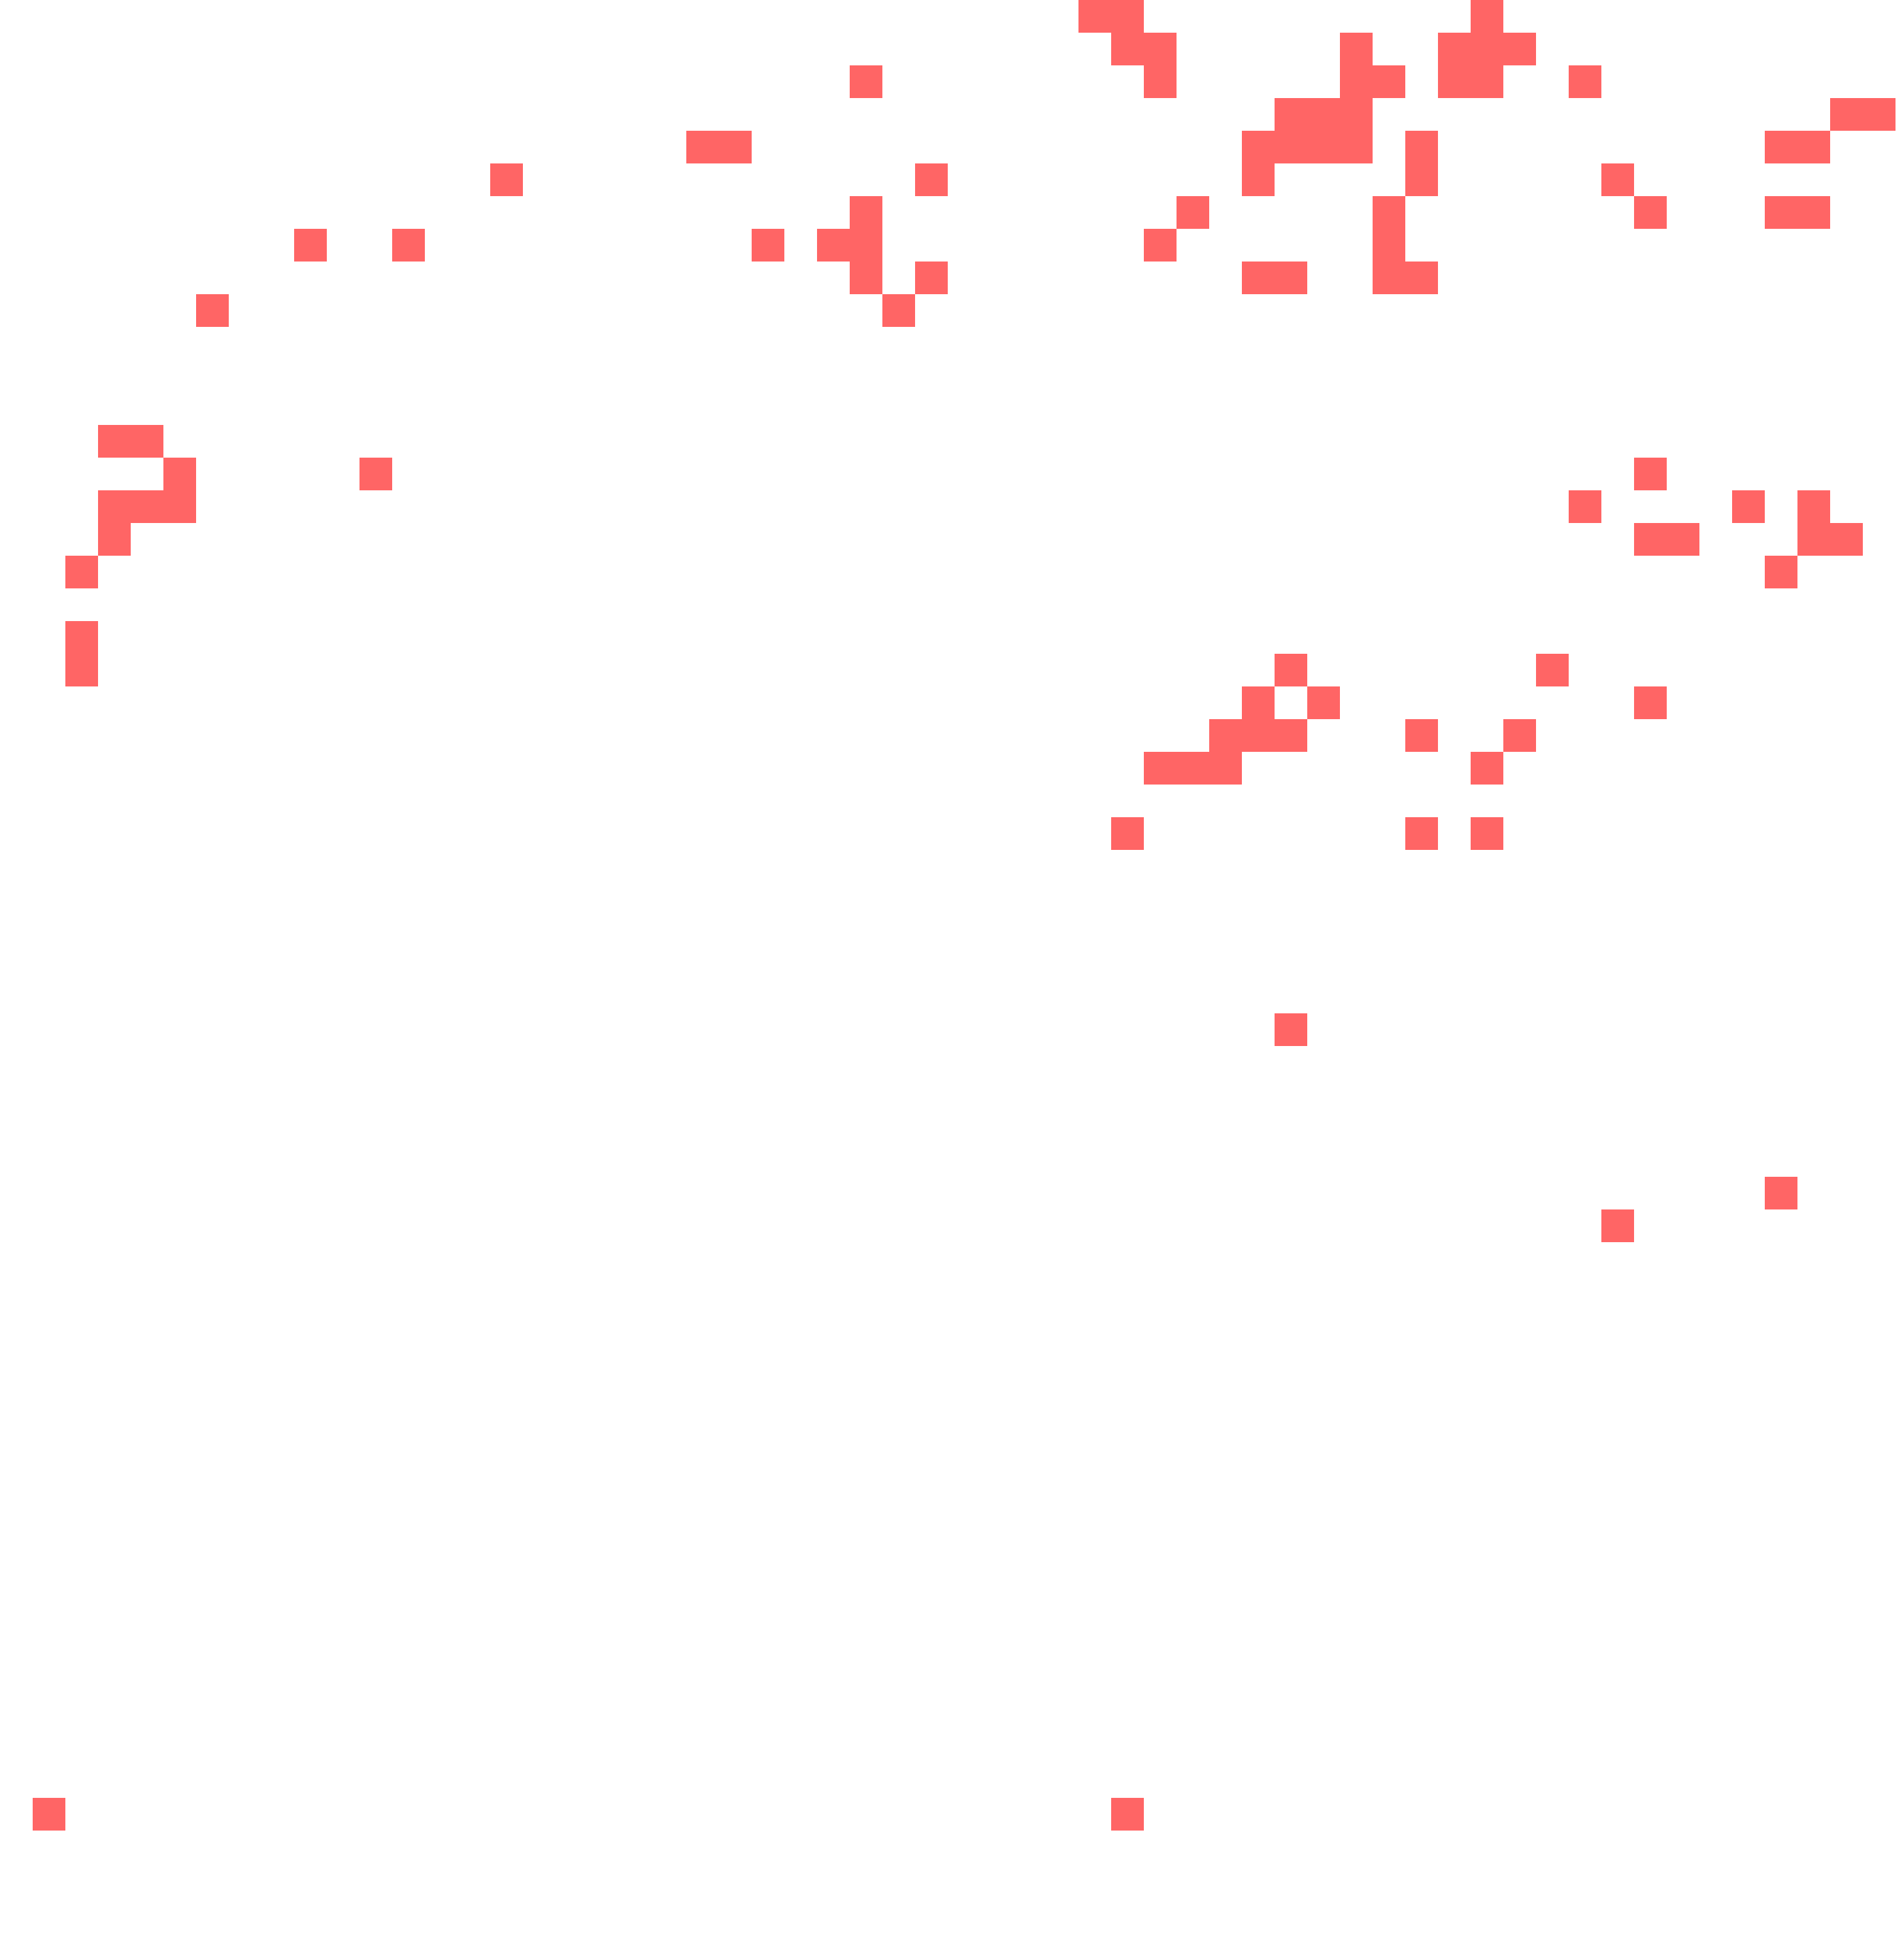
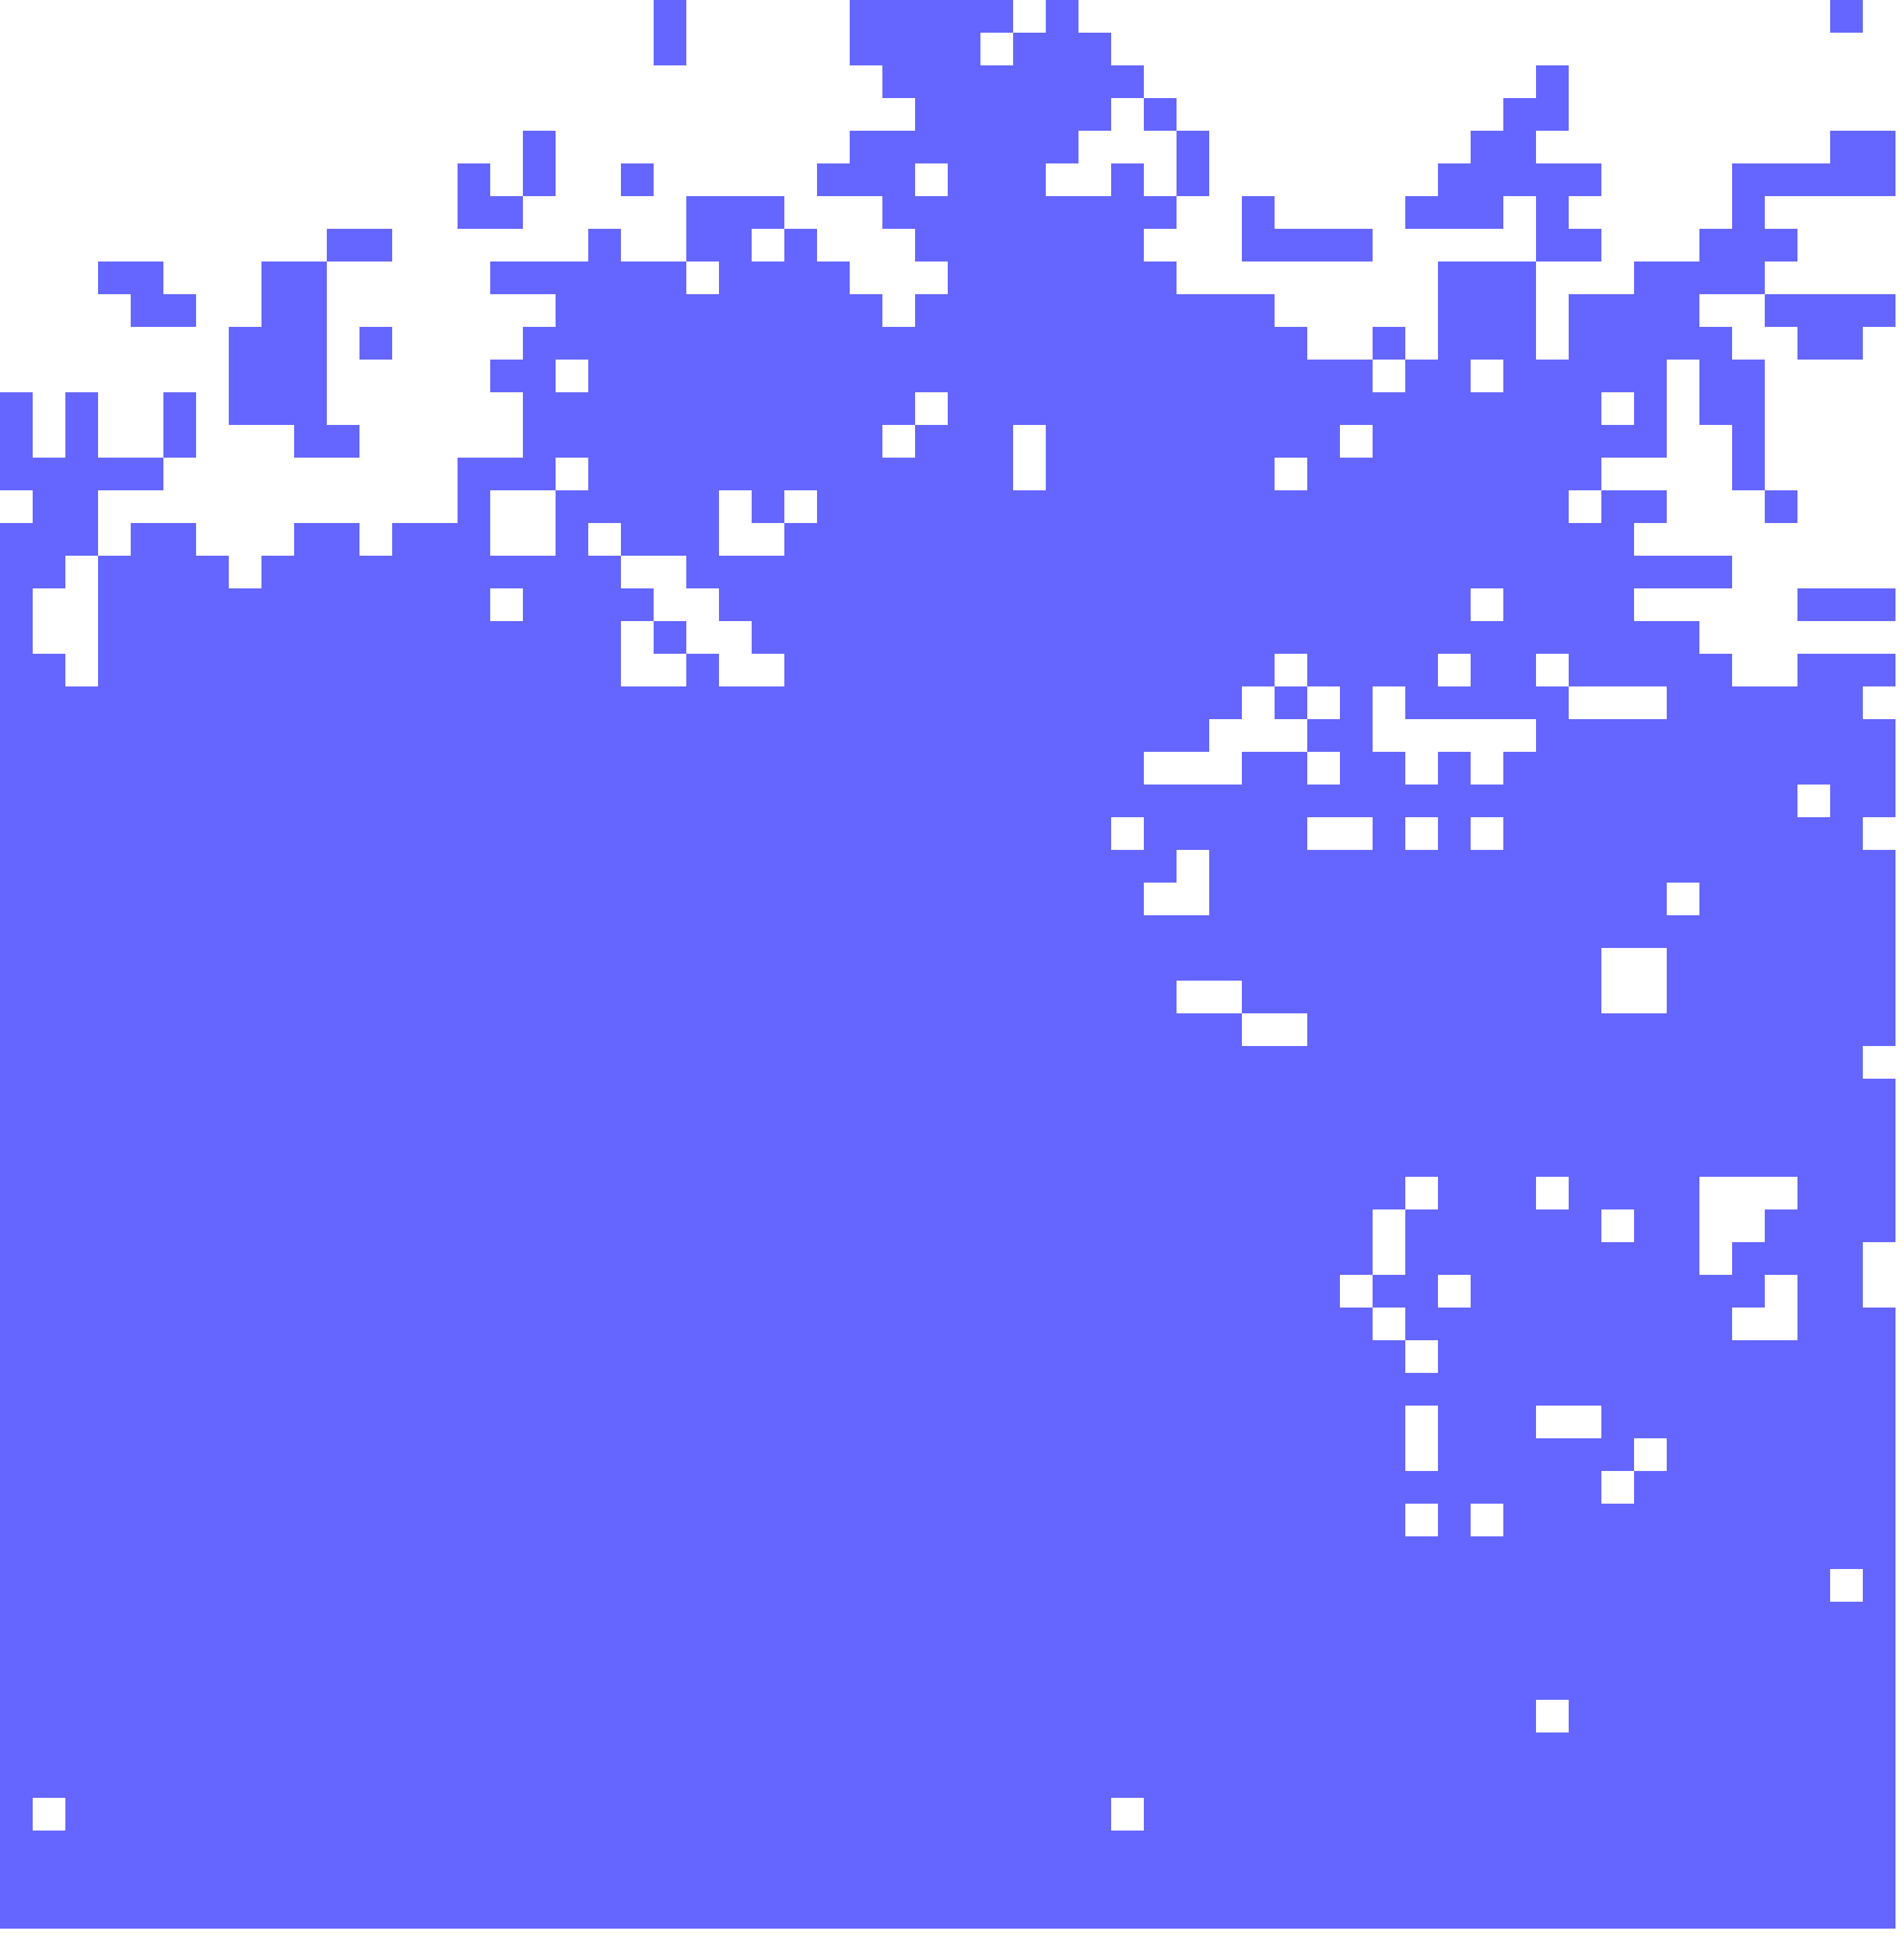
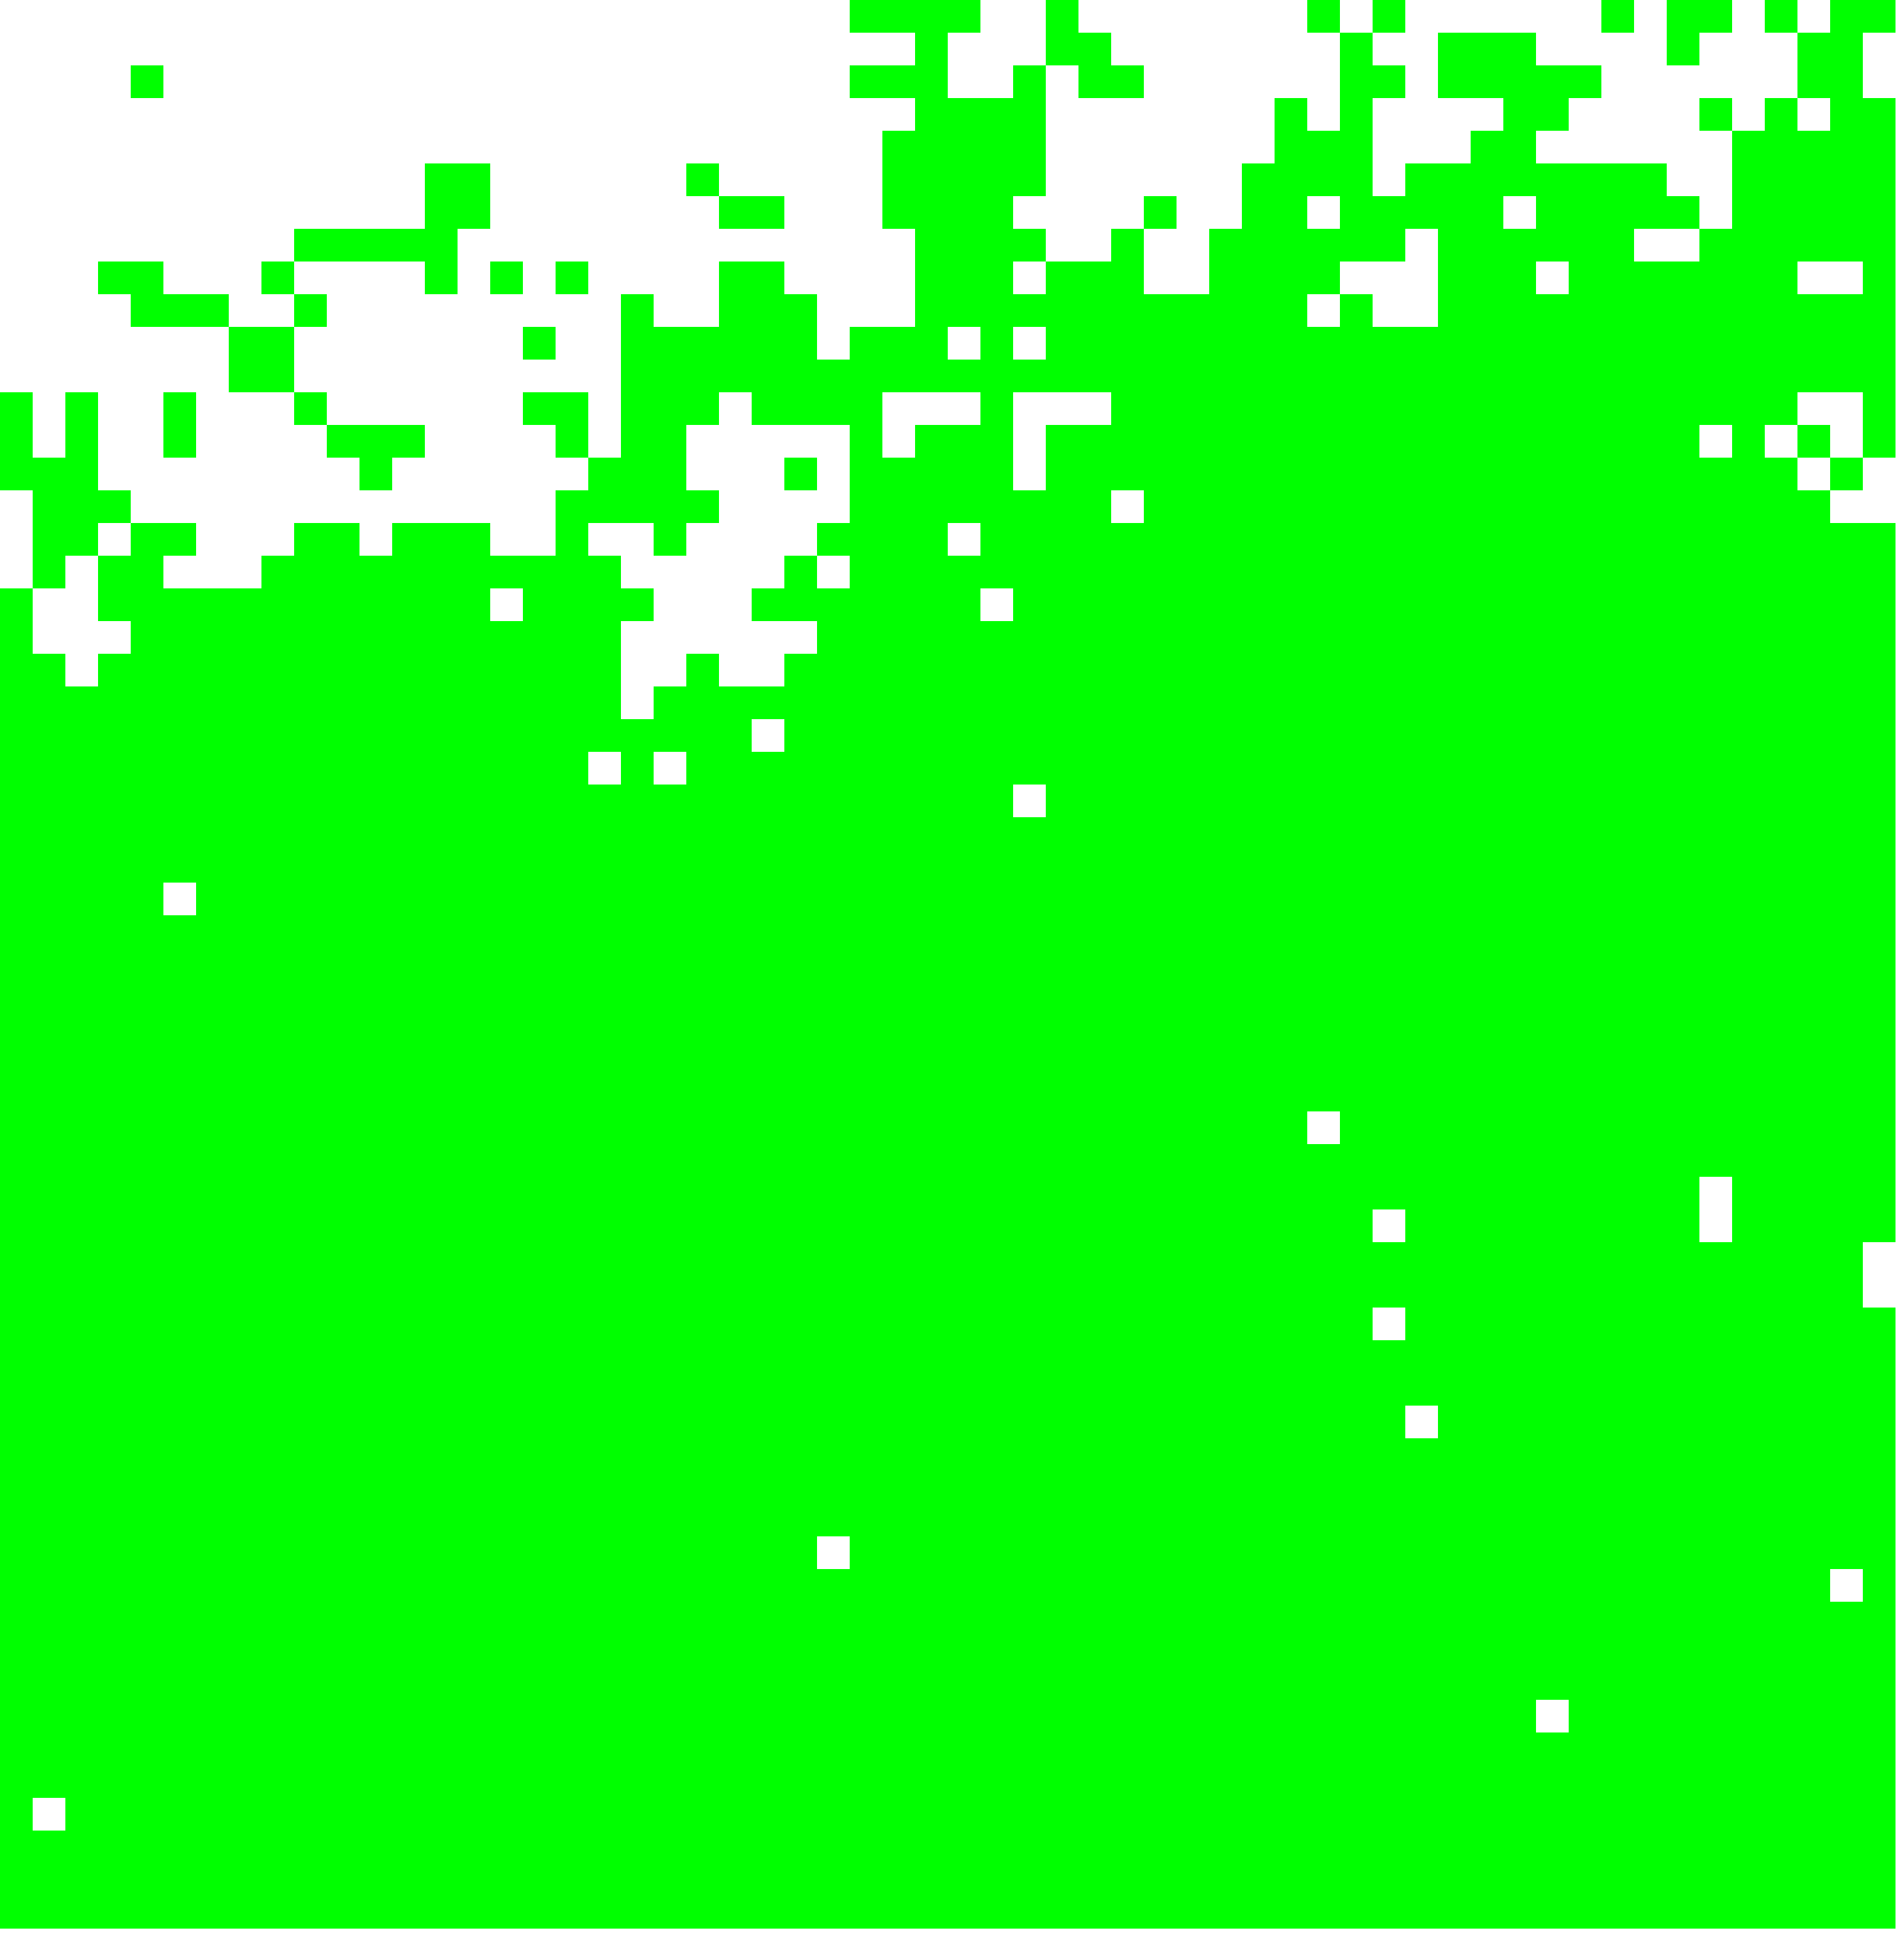
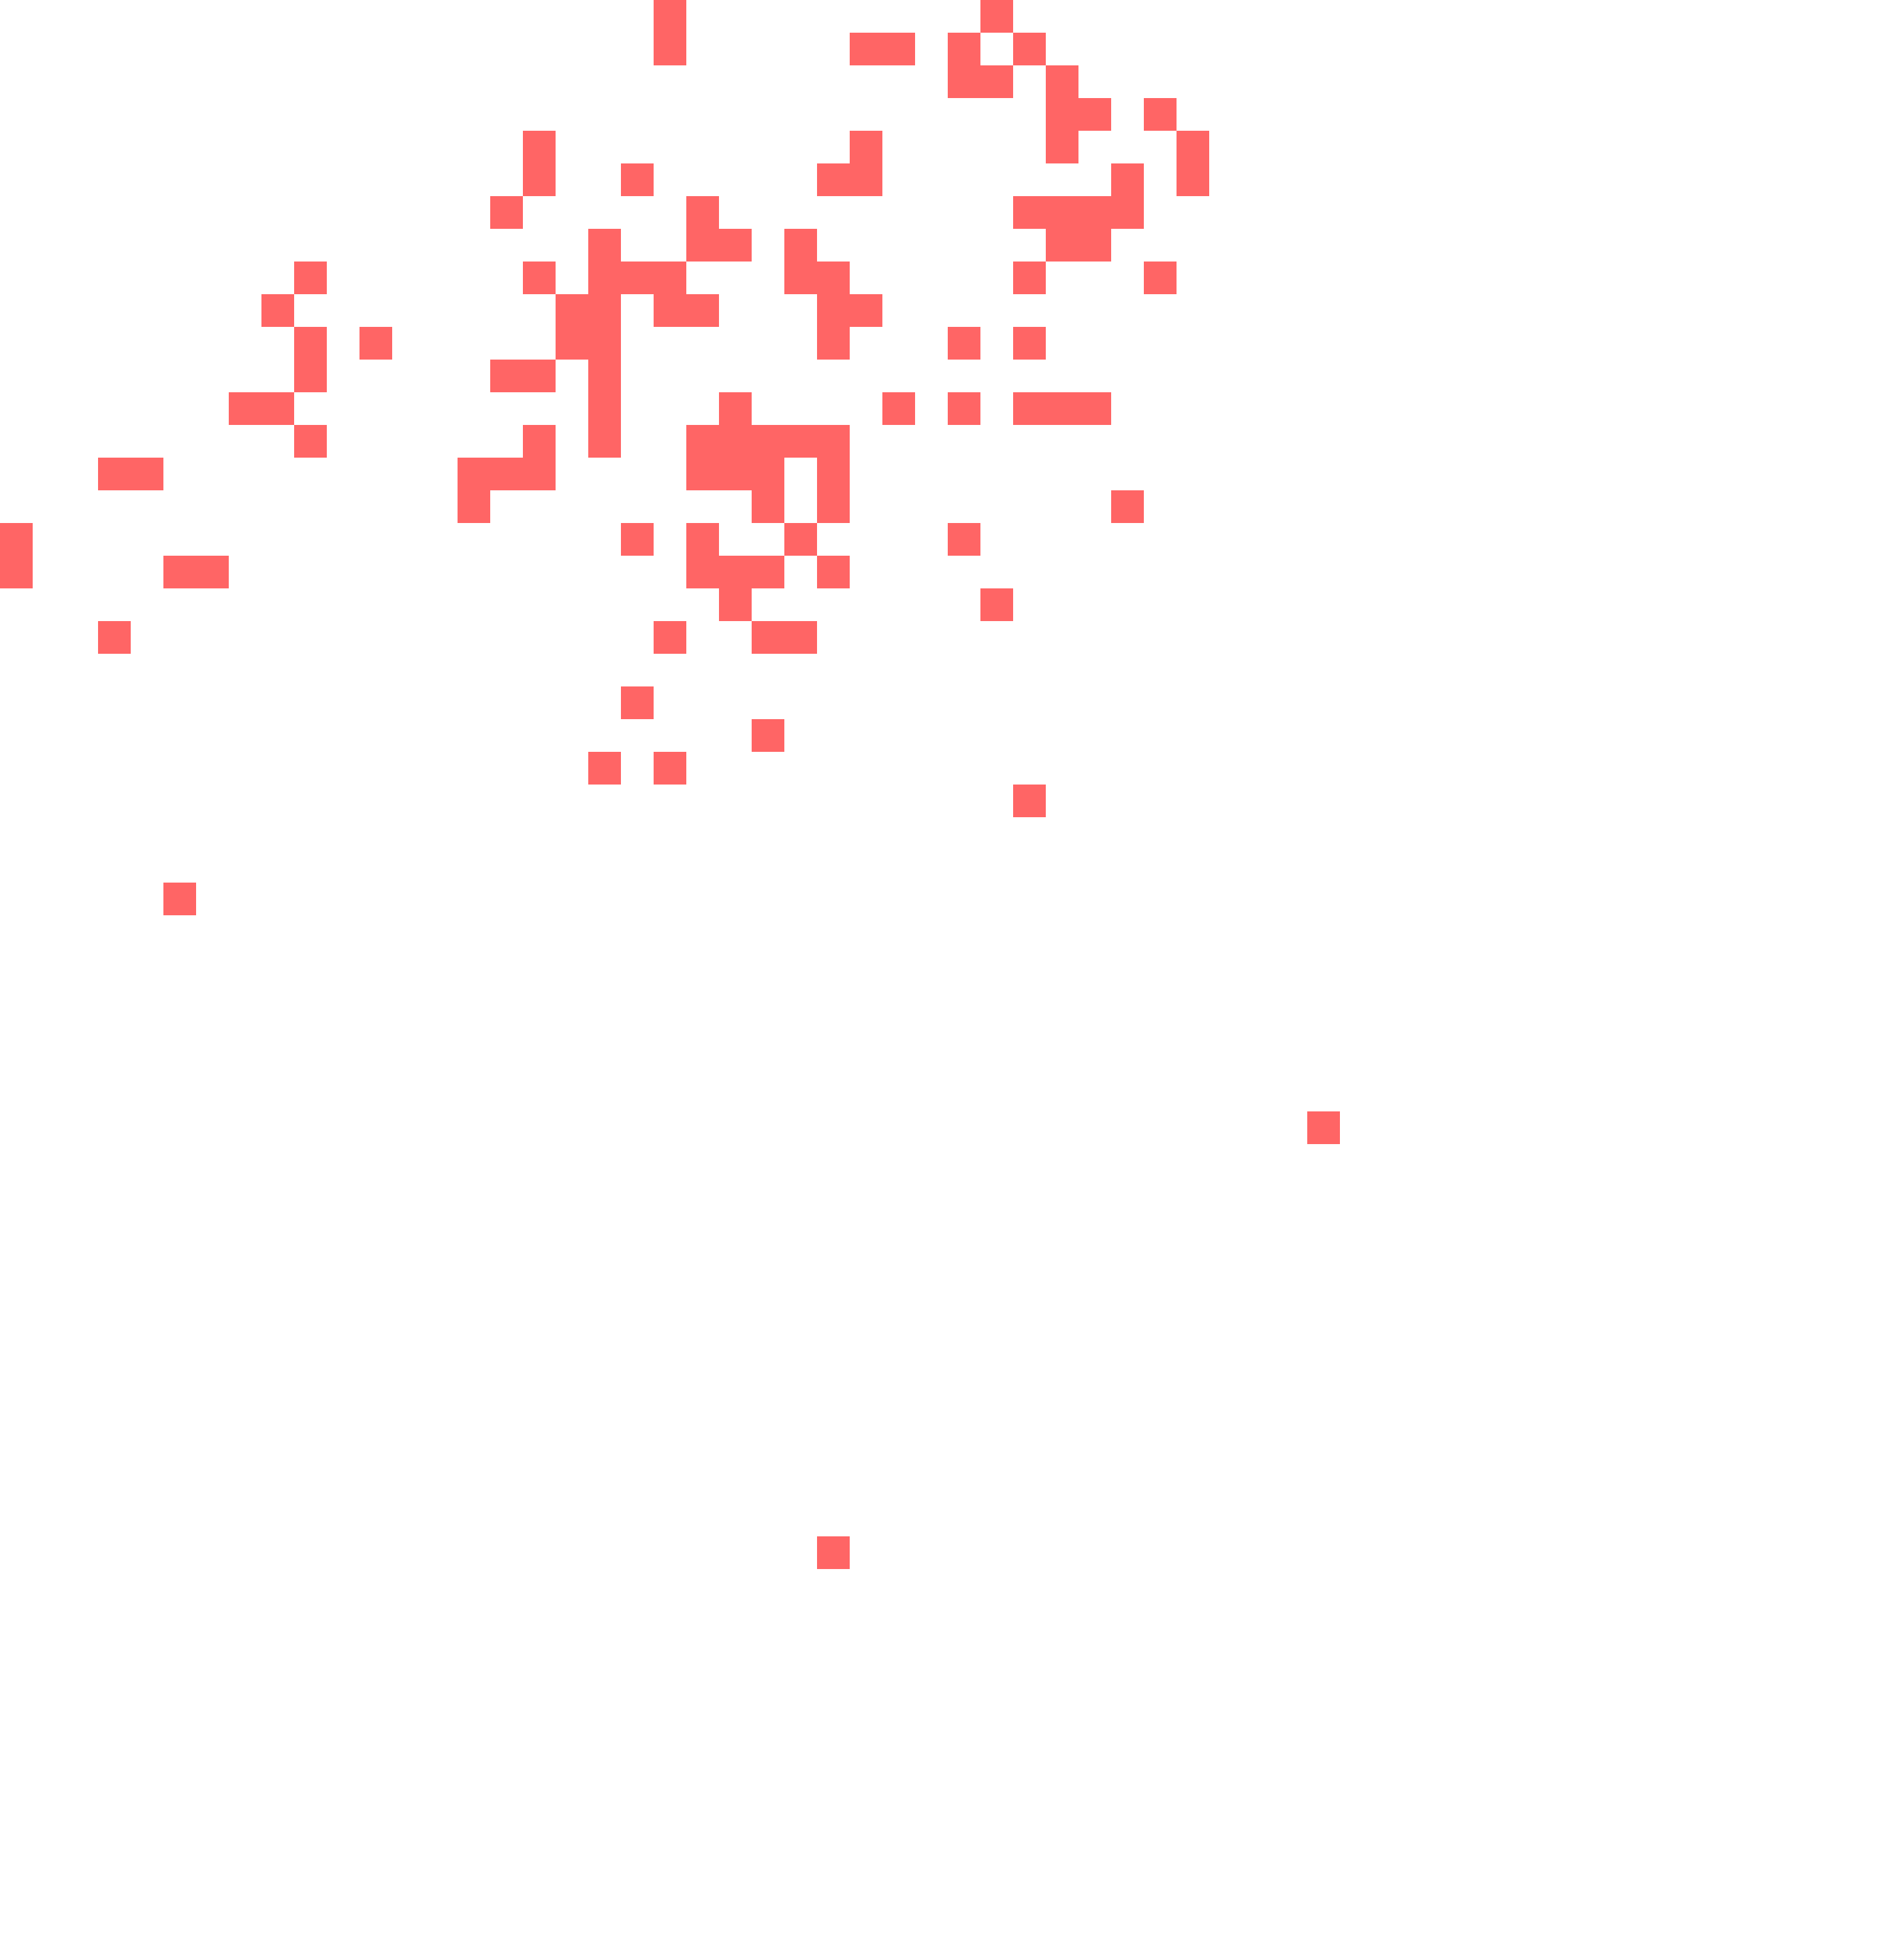
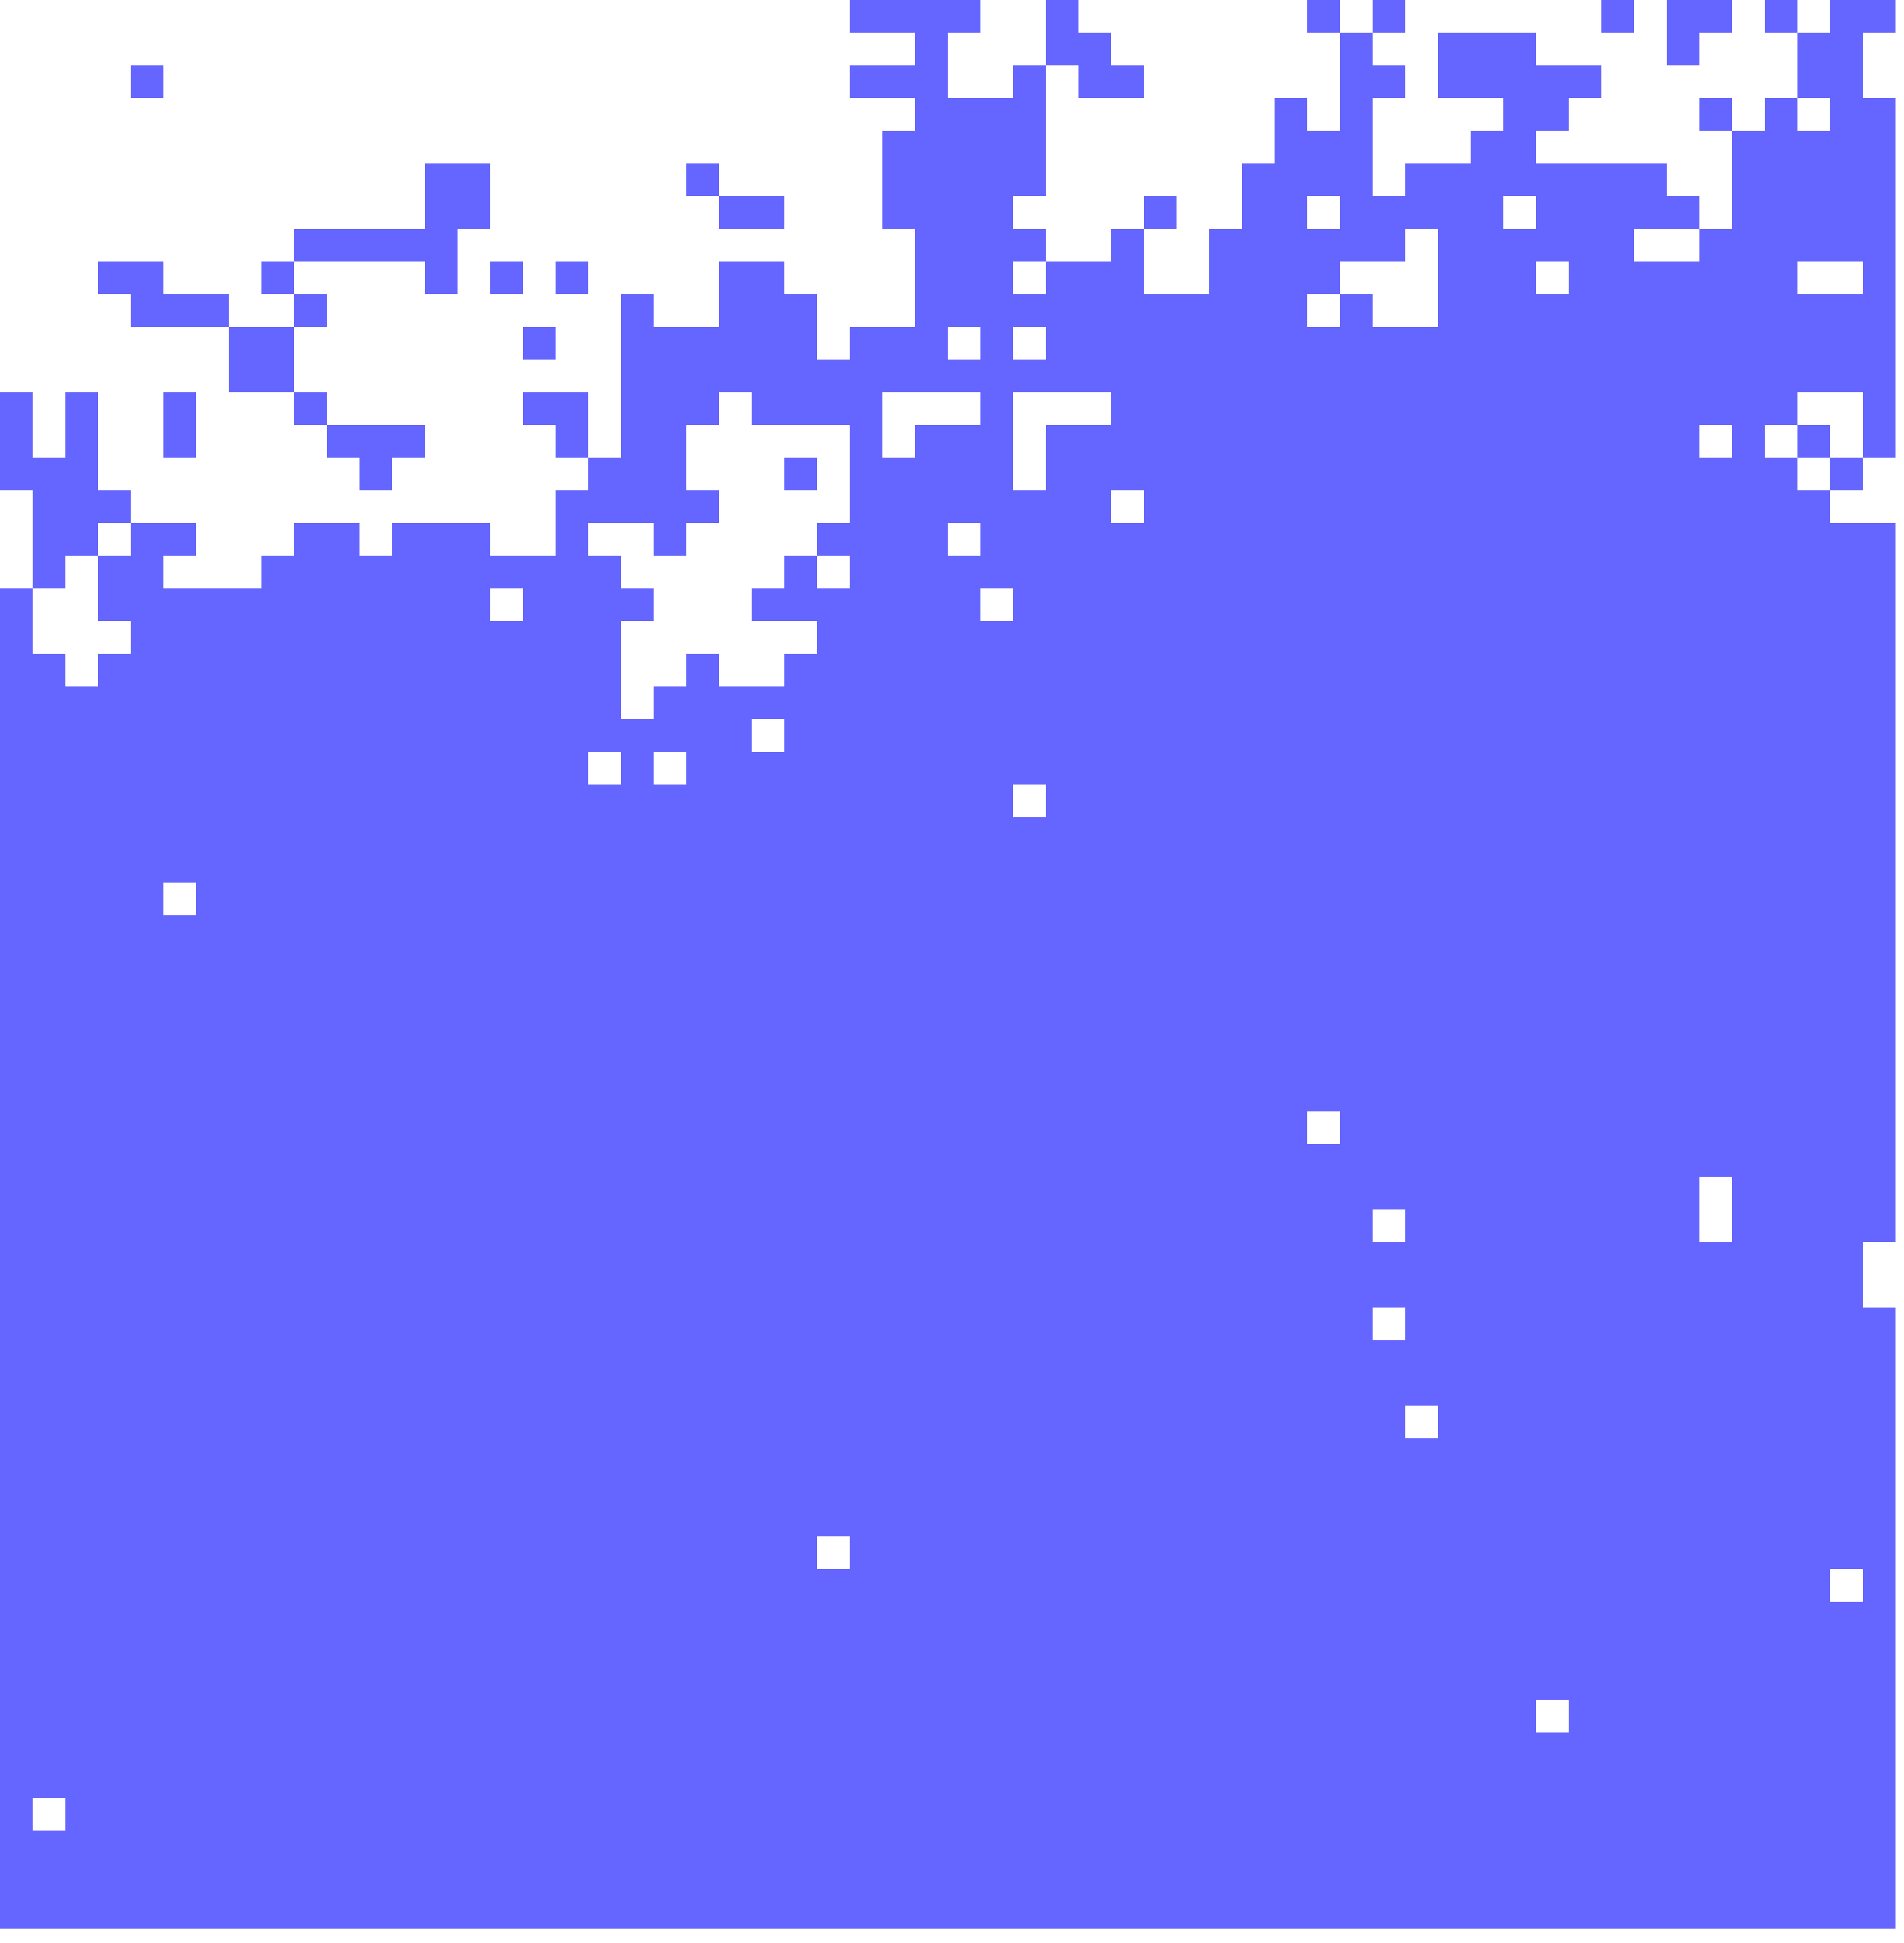

In [21]:
import numpy as np
import os
import rasterio
from PIL import Image
import folium
from folium.plugins import MiniMap
import geopandas as gpd

# Constants
PIXEL_AREA = 30 * 30
AVERAGE_CARBON_DENSITY_MATURE = 200
DEFORESTATION_THRESHOLD = 5  # 5% of the forest cover lost
CARBON_STOCK_DECREASE_THRESHOLD = 10 # 10% decrease in carbon stock

# Constants for Mapbox
MAPBOX_ACCESS_TOKEN = 'pk.eyJ1IjoiZGJjb29wZXIxOSIsImEiOiJjbGlveWZyeGgwNHNzM2xucWtmeHRtdjRjIn0.eR5g-CGcSLPyW_d_x-BAKw'
MAPBOX_SATELLITE_URL = f"https://api.mapbox.com/styles/v1/mapbox/satellite-streets-v11/tiles/256/{{z}}/{{x}}/{{y}}@2x?access_token={MAPBOX_ACCESS_TOKEN}"
MAPBOX_HYDROLOGY_URL = f"https://api.mapbox.com/styles/v1/mapbox/outdoors-v11/tiles/256/{{z}}/{{x}}/{{y}}@2x?access_token={MAPBOX_ACCESS_TOKEN}"

# Initialize folium map
center_coords = [13.0667, -12.7167]
m = folium.Map(location=center_coords, zoom_start=10, tiles=None)

# Add MiniMap
minimap = MiniMap()
m.add_child(minimap)

# Add base layers
folium.TileLayer(MAPBOX_HYDROLOGY_URL, attr="Mapbox Hydrology", name="Hydrology").add_to(m)
folium.TileLayer(MAPBOX_SATELLITE_URL, attr="Mapbox Satellite", name="Satellite Imagery").add_to(m)
folium.TileLayer('openstreetmap').add_to(m)
folium.TileLayer('Stamen Terrain').add_to(m)
folium.TileLayer('Stamen Toner').add_to(m)

# Directory for predicted images
predicted_dir = "./predicted"
predicted_image_files = sorted([os.path.join(predicted_dir, f) for f in os.listdir(predicted_dir) if f.endswith('.tif')])

previous_forest_cover = None
carbon_emission_layers = []
carbon_stock_layers = []

for f in predicted_image_files:
    with rasterio.open(f) as src:
        forest_cover = src.read(1) > 0.5

        if previous_forest_cover is not None:
            deforestation = np.logical_and(previous_forest_cover, ~forest_cover)
            carbon_emission = deforestation.astype(np.float32) * AVERAGE_CARBON_DENSITY_MATURE
            carbon_emission_layers.append(carbon_emission)
        else:
            carbon_emission_layers.append(np.zeros_like(forest_cover, dtype=np.float32))

        carbon_stock = forest_cover.astype(np.float32) * AVERAGE_CARBON_DENSITY_MATURE
        carbon_stock_layers.append(carbon_stock)

        previous_forest_cover = forest_cover

# Image bounds
image_bounds = [[13.0667 - 0.5, -12.7167 - 0.5], [13.0667 + 0.5, -12.7167 + 0.5]]

for year in range(2013, 2021):
    overlay_image_path = f"./colored_images/forest_overlay_{year}.png"
    emission_image_path = f"./emission_colored_images/carbon_emission_{year}.png"
    stock_image_path = f"./stock_colored_images/carbon_stock_{year}.png"

    img = folium.raster_layers.ImageOverlay(name=f"Predicted Forest {year}", image=overlay_image_path, bounds=image_bounds, opacity=0.6, show=False)
    img.add_child(folium.Popup(f'Predicted Forest Cover for {year}'))
    img.add_to(m)

    emission_img = folium.raster_layers.ImageOverlay(name=f"Carbon Emission {year}", image=emission_image_path, bounds=image_bounds, opacity=0.6, show=False)
    emission_img.add_to(m)

    stock_img = folium.raster_layers.ImageOverlay(name=f"Carbon Stock {year}", image=stock_image_path, bounds=image_bounds, opacity=0.6, show=False)
    stock_img.add_to(m)

# Load Niokolo-Koba Park shapefile using geopandas
shp_path = "./niokolokoshp/WDPA_WDOECM_Sep2023_Public_2580_shp_0.zip"
niokolokoba_gdf = gpd.read_file(shp_path)

# Add Niokolo-Koba Park shapefile to folium map with a distinct color
style_function_park = lambda x: {'fillColor': '#32CD32', 'color': '#32CD32', 'fillOpacity': 0.5, 'weight': 0.5}
folium.GeoJson(niokolokoba_gdf, style_function=style_function_park, name="Niokolo-Koba National Park").add_to(m)

import re

alerts = []

# Regular expression pattern to match a four-digit year
year_pattern = re.compile(r'\b\d{4}\b')

for f in predicted_image_files:
    # Extracting the year using regex
    match = year_pattern.search(f)
    if not match:
        continue  # Skip files that don't have a year in the filename
    
    year = int(match.group())

    with rasterio.open(f) as src:
        forest_cover = src.read(1) > 0.2

        if previous_forest_cover is not None:
            deforestation = np.logical_and(previous_forest_cover, ~forest_cover)
            deforestation_percentage = (deforestation.sum() / previous_forest_cover.sum()) * 100
            print(f"Deforestation percentage for {year}: {deforestation_percentage:.2f}%")
            
            if deforestation_percentage > DEFORESTATION_THRESHOLD:
                alerts.append(f"ALERT for {year}: More than 5% of the forest was cleared.")

            carbon_stock = forest_cover.astype(np.float32) * AVERAGE_CARBON_DENSITY_MATURE
            if previous_year_carbon_stock is not None:
                change_in_carbon_stock = (carbon_stock.sum() - previous_year_carbon_stock) / previous_year_carbon_stock * 100
                print(f"Change in carbon stock for {year}: {change_in_carbon_stock:.2f}%")
                
                if change_in_carbon_stock < -CARBON_STOCK_DECREASE_THRESHOLD:
                    alerts.append(f"ALERT for {year}: Carbon stock decreased by more than 10% compared to the previous year.")

            previous_year_carbon_stock = carbon_stock.sum()

        previous_forest_cover = forest_cover




# Add alerts to the folium map
for alert in alerts:
    folium.Marker(
        location=center_coords,
        popup=alert,
        icon=folium.Icon(color="red", icon="exclamation-circle")
    ).add_to(m)
    
# Enhanced legend with hover functionality
legend_html = """
<div style="position: fixed; bottom: 50px; left: 50px; z-index:9999; font-size:14px; background-color: white; padding: 10px; border-radius: 5px;">
    <b>Legend:</b><br>
    <i class="fa fa-square fa-1x" style="color:green"></i> Predicted Forest<br>
    <i class="fa fa-square fa-1x" style="color:red"></i> Carbon Emission (due to deforestation)<br>
    <i class="fa fa-square fa-1x" style="color:blue"></i> Carbon Stock<br>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Layer Control
folium.LayerControl().add_to(m)

m


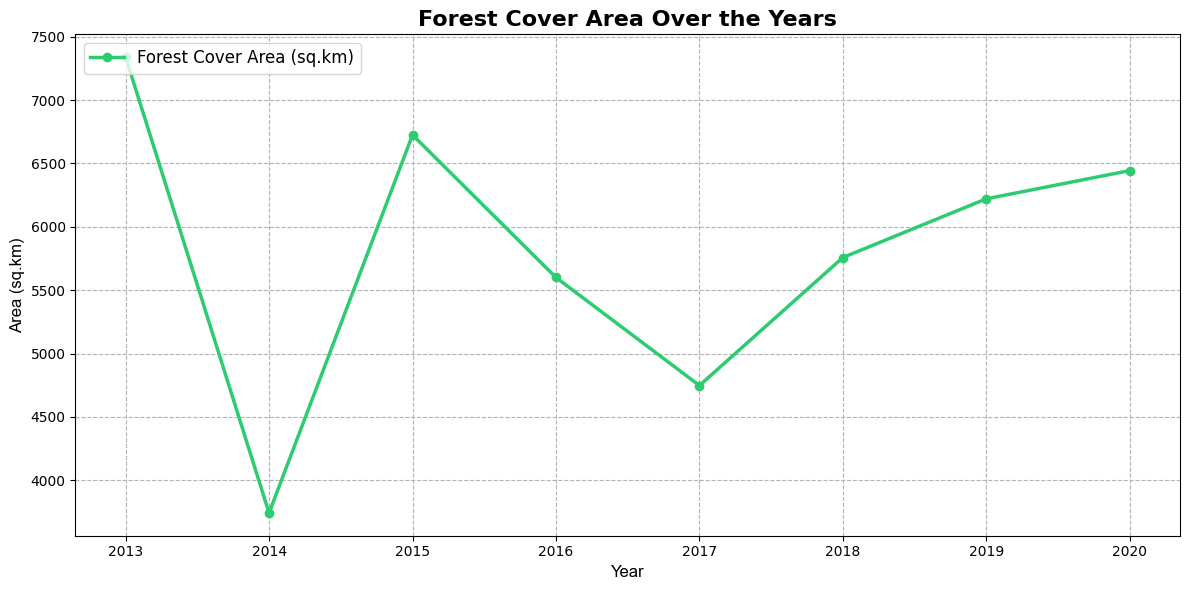

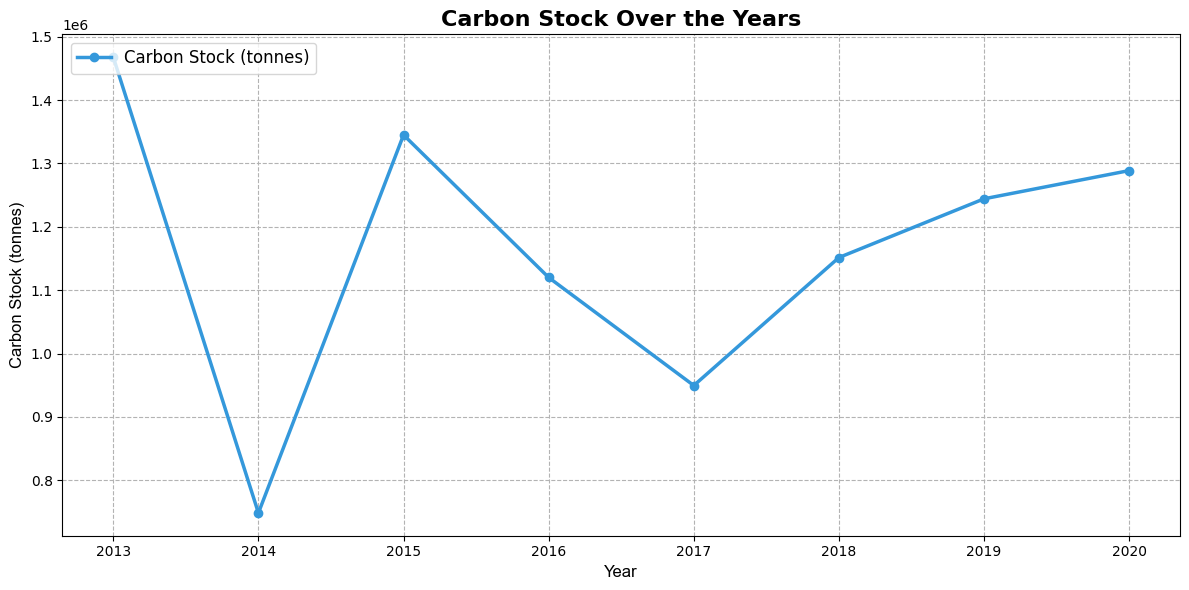

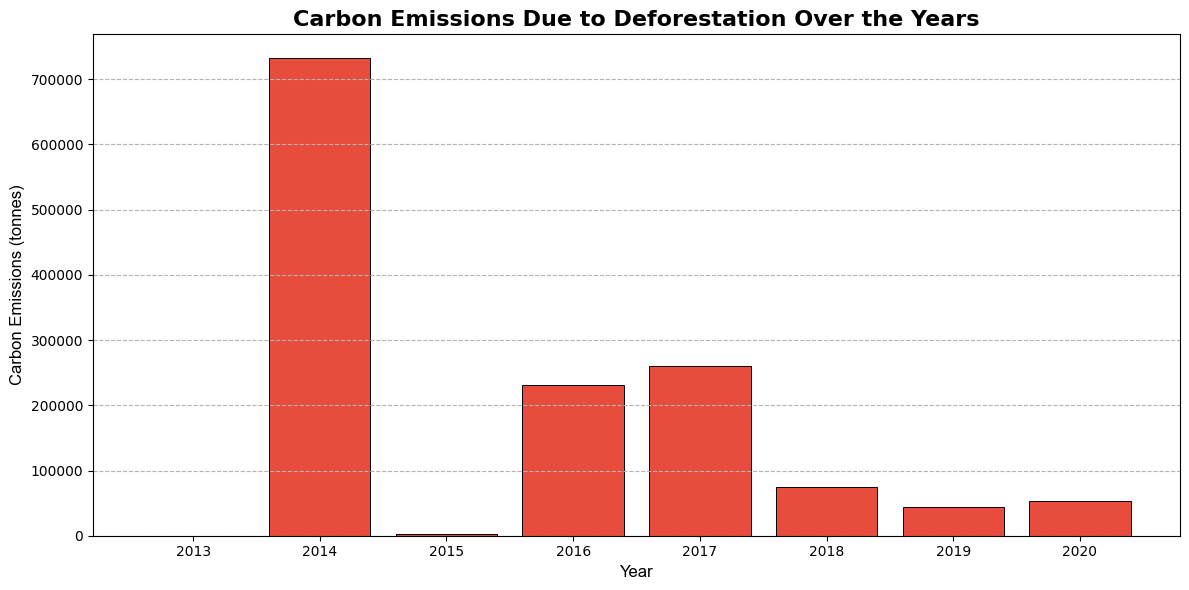

In [36]:
import numpy as np
import os
import rasterio
from matplotlib import pyplot as plt

# Directory containing the predicted images
predicted_dir = "./predicted"
predicted_image_files = sorted([os.path.join(predicted_dir, f) for f in os.listdir(predicted_dir) if f.endswith('.tif')])

# Constants
PIXEL_AREA = 30 * 30  # Assuming each pixel represents 30m x 30m
AVERAGE_CARBON_DENSITY_MATURE = 200  # Average carbon density for mature forests (tonnes per hectare)
AVERAGE_CARBON_DENSITY_YOUNG = 50  # Average carbon density for young/regrowing forests (tonnes per hectare)

forest_cover_area = []
total_carbon_stock = []
regrowth_areas = []
deforested_areas = []

previous_forest_cover = None
for f in predicted_image_files:
    with rasterio.open(f) as src:
        forest_cover = src.read(1) > 0.5
        
        # Calculate forest cover area
        forest_area = np.sum(forest_cover) * PIXEL_AREA / (10**6)  # in sq.km
        forest_cover_area.append(forest_area)
        
        # Calculate carbon stock
        carbon_stock = forest_area * AVERAGE_CARBON_DENSITY_MATURE  # in tonnes
        total_carbon_stock.append(carbon_stock)
        
        # If there's a previous year's data, calculate regrowth and deforested areas
        if previous_forest_cover is not None:
            regrowth = np.logical_and(~previous_forest_cover, forest_cover)
            deforestation = np.logical_and(previous_forest_cover, ~forest_cover)
            regrowth_areas.append(np.sum(regrowth) * PIXEL_AREA / (10**6))
            deforested_areas.append(np.sum(deforestation) * PIXEL_AREA / (10**6))
        else:
            regrowth_areas.append(0)
            deforested_areas.append(0)
        
        previous_forest_cover = forest_cover

# Carbon emissions due to deforestation
carbon_emissions = np.array(deforested_areas) * AVERAGE_CARBON_DENSITY_MATURE

# Visualization
years = list(range(2013, 2021))

# Colors and style
color_palette = ["#2ecc71", "#3498db", "#e74c3c"]
font = {'family': 'Arial', 'weight': 'normal', 'size': 12}

# Forest Cover Area Plot
plt.figure(figsize=(12, 6))
plt.plot(years, forest_cover_area, marker='o', color=color_palette[0], label="Forest Cover Area (sq.km)", linewidth=2.5)
plt.title('Forest Cover Area Over the Years', fontdict={'size': 16, 'weight': 'bold'})
plt.xlabel('Year', fontdict=font)
plt.ylabel('Area (sq.km)', fontdict=font)
plt.grid(True, which="both", ls="--", c='0.7')
plt.legend(loc="upper left", prop={'size': 12})
plt.tight_layout()
plt.show()

# Carbon Stock Plot
plt.figure(figsize=(12, 6))
plt.plot(years, total_carbon_stock, marker='o', color=color_palette[1], label="Carbon Stock (tonnes)", linewidth=2.5)
plt.title('Carbon Stock Over the Years', fontdict={'size': 16, 'weight': 'bold'})
plt.xlabel('Year', fontdict=font)
plt.ylabel('Carbon Stock (tonnes)', fontdict=font)
plt.grid(True, which="both", ls="--", c='0.7')
plt.legend(loc="upper left", prop={'size': 12})
plt.tight_layout()
plt.show()

# Carbon Emissions Bar Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(years, carbon_emissions, color=color_palette[2], edgecolor='black')
plt.title('Carbon Emissions Due to Deforestation Over the Years', fontdict={'size': 16, 'weight': 'bold'})
plt.xlabel('Year', fontdict=font)
plt.ylabel('Carbon Emissions (tonnes)', fontdict=font)
plt.grid(axis='y', which="both", ls="--", c='0.7')
# Adding shadow to bars
for bar in bars:
    bar.set_zorder(1)
    bar.set_edgecolor("black")
    bar.set_linewidth(0.7)
plt.tight_layout()
plt.show()


In [43]:
import os
import folium
from folium.plugins import MiniMap
import ipywidgets as widgets
from IPython.display import display, clear_output
import geopandas as gpd
import numpy as np
from PIL import Image

# Constants and Map Initialization
center_coords = [13.0667, -12.7167]
MAPBOX_ACCESS_TOKEN = 'pk.eyJ1IjoiZGJjb29wZXIxOSIsImEiOiJjbGlveWZyeGgwNHNzM2xucWtmeHRtdjRjIn0.eR5g-CGcSLPyW_d_x-BAKw'
MAPBOX_SATELLITE_URL = f"https://api.mapbox.com/styles/v1/mapbox/satellite-streets-v11/tiles/256/{{z}}/{{x}}/{{y}}@2x?access_token={MAPBOX_ACCESS_TOKEN}"
MAPBOX_HYDROLOGY_URL = f"https://api.mapbox.com/styles/v1/mapbox/outdoors-v11/tiles/256/{{z}}/{{x}}/{{y}}@2x?access_token={MAPBOX_ACCESS_TOKEN}"
image_bounds = [[13.0667 - 0.6, -12.7167 - 0.6], [13.0667 + 0.4, -12.7167 + 0.4]]

# Add Niokolo-Koba Park shapefile
shp_path = "./niokolokoshp/WDPA_WDOECM_Sep2023_Public_2580_shp_0.zip"
niokolokoba_gdf = gpd.read_file(shp_path)
style_function_park = lambda x: {'fillColor': '#32CD32', 'color': '#32CD32', 'fillOpacity': 0.5, 'weight': 0.5}

# ... [Rest of the data loading and processing remains unchanged]

# Define alert thresholds
FOREST_COVER_DECREASE_THRESHOLD = 10  # sq.km
FOREST_COVER_INCREASE_THRESHOLD = 10  # sq.km
CARBON_EMISSION_THRESHOLD = 1000  # tonnes
CARBON_STOCK_DECREASE_THRESHOLD = 1000  # tonnes
CARBON_STOCK_INCREASE_THRESHOLD = 1000  # tonnes

def generate_alerts(year, image_type):
    """Generate alerts based on forest data for the given year and image type."""
    alerts = []

    idx = years.index(year)
    
    if image_type == "Predicted Forest":
        # Alert for significant decrease in forest cover
        if idx > 0 and (forest_cover_area[idx-1] - forest_cover_area[idx]) >= FOREST_COVER_DECREASE_THRESHOLD:
            alerts.append("⚠️ Dramatic Deforestation Detected!")
        if idx > 0 and (forest_cover_area[idx] - forest_cover_area[idx-1]) >= FOREST_COVER_INCREASE_THRESHOLD:
            alerts.append("🌱 Significant Reforestation Detected!")

    elif image_type == "Carbon Emission":
        # Alert for high carbon emission
        if carbon_emissions[idx] >= CARBON_EMISSION_THRESHOLD:
            alerts.append(f"⚠️ High Carbon Emission Detected: {carbon_emissions[idx]:.2f} tonnes!")

    elif image_type == "Carbon Stock":
        # Alert for significant decrease in carbon stock
        if idx > 0 and (total_carbon_stock[idx-1] - total_carbon_stock[idx]) >= CARBON_STOCK_DECREASE_THRESHOLD:
            alerts.append(f"⚠️ Significant Decrease in Carbon Stock: {total_carbon_stock[idx]:.2f} tonnes!")
        # Alert for significant increase in carbon stock
        if idx > 0 and (total_carbon_stock[idx] - total_carbon_stock[idx-1]) >= CARBON_STOCK_INCREASE_THRESHOLD:
            alerts.append(f"🌱 Significant Increase in Carbon Stock: {total_carbon_stock[idx]:.2f} tonnes!")

    return alerts

def display_map(year, image_type):
    # Save current view
    global current_view
    if 'm' in globals():
        current_view = {
            "center": m.location,
            "zoom": m.zoom_start
        }

    # Create a new map
    m = folium.Map(location=current_view["center"], zoom_start=current_view["zoom"], tiles=None)
    
    # Add base layers
    folium.TileLayer(MAPBOX_HYDROLOGY_URL, attr="Mapbox Hydrology", name="Hydrology").add_to(m)
    folium.TileLayer(MAPBOX_SATELLITE_URL, attr="Mapbox Satellite", name="Satellite Imagery").add_to(m)
    folium.TileLayer('openstreetmap').add_to(m)
    folium.TileLayer('Stamen Terrain').add_to(m)
    folium.TileLayer('Stamen Toner').add_to(m)

    # Add park shapefile
    folium.GeoJson(niokolokoba_gdf, style_function=style_function_park, name="Niokolo-Koba National Park").add_to(m)
    
    # Add the layers for the selected year to the map
    overlay_image_path, emission_image_path, stock_image_path = layers_by_year[year]
    if image_type == "Predicted Forest":
        folium.raster_layers.ImageOverlay(name=f"Predicted Forest {year}", image=overlay_image_path, bounds=image_bounds, opacity=0.6).add_to(m)
    elif image_type == "Carbon Emission":
        folium.raster_layers.ImageOverlay(name=f"Carbon Emission {year}", image=emission_image_path, bounds=image_bounds, opacity=0.6).add_to(m)
    else:
        folium.raster_layers.ImageOverlay(name=f"Carbon Stock {year}", image=stock_image_path, bounds=image_bounds, opacity=0.6).add_to(m)

    # Generate and display alerts for the selected year and image type
    alerts = generate_alerts(year, image_type)
    for alert in alerts:
        folium.Marker(
            location=center_coords, 
            popup=alert,
            icon=folium.Icon(color="red", icon="warning-sign", prefix="fa")
        ).add_to(m)

    # Add LayerControl
    folium.LayerControl().add_to(m)
    
    # Display the map
    clear_output(wait=True)
    display(m)

# Create interactive widgets
year_slider = widgets.IntSlider(min=2013, max=2020, step=1, value=2013, description='Year:')
image_dropdown = widgets.Dropdown(options=["Predicted Forest", "Carbon Emission", "Carbon Stock"], value="Predicted Forest", description='Image Type:')
widgets.interactive(display_map, year=year_slider, image_type=image_dropdown)


interactive(children=(IntSlider(value=2013, description='Year:', max=2020, min=2013), Dropdown(description='Im…

&copy; Jargoñ 2023